### DIAPOSITIVAS FALTANTES
- 54 (Listo)
- 53 (Se debe checar)
- 48 (Listo)
- 43 (Listo)
- 42 (Se debe checar)
- 36 (Listo)
- 30 (Listo)
- 21 (Se debe checar)
- 13 (Listo)

In [2]:
# -*- coding: utf-8 -*-
# Diapositiva 1: Población en Sinaloa (KPI + H/M)
# Requisitos: pip install requests matplotlib
# Guarda imagen en ./salida/diapositiva_1_poblacion_en_sinaloa.png

import os, requests, json
import matplotlib.pyplot as plt
import dotenv

dotenv.load_dotenv()

API_KEY = os.getenv("INEGI_TOKEN")
GEO_EST = "25"   # Sinaloa
GEO_NAC = "00"   # México

OUT_DIR = "salida"
os.makedirs(OUT_DIR, exist_ok=True)

def fetch_series(indicator_id, geo, try_sources=("BISE","BIE")):
    """
    Descarga la serie completa para un indicador y un geo.
    Intenta primero BISE y luego BIE. Devuelve lista de observaciones [(periodo, valor_float)].
    """
    base = "https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml"
    for src in try_sources:
        url = f"{base}/INDICATOR/{indicator_id}/es/{geo}/false/{src}/2.0/{API_KEY}?type=json"
        try:
            r = requests.get(url, timeout=60)
            r.raise_for_status()
            js = r.json()
            series = js.get("Series", [])
            if not series:
                continue
            obs = series[0].get("OBSERVATIONS", [])
            out = []
            for o in obs:
                periodo = str(o.get("TIME_PERIOD", ""))
                val = o.get("OBS_VALUE", None)
                try:
                    val = float(val)
                except Exception:
                    val = None
                if val is not None:
                    out.append((periodo, val))
            if out:
                return out
        except Exception:
            continue
    return []

def pick_2020_or_latest(obs):
    """obs: lista [(periodo, valor)]. Prioriza 2020; si no, el último."""
    if not obs:
        return ("", None)
    obs2020 = [o for o in obs if "2020" in o[0]]
    sel = obs2020[-1] if obs2020 else obs[-1]
    return sel

# --- Descargas ---
total_est = fetch_series("1002000001", GEO_EST)
hom_est   = fetch_series("1002000002", GEO_EST)
muj_est   = fetch_series("1002000003", GEO_EST)
total_nac = fetch_series("1002000001", GEO_NAC)

per_total, val_total = pick_2020_or_latest(total_est)
per_hom,   val_hom   = pick_2020_or_latest(hom_est)
per_muj,   val_muj   = pick_2020_or_latest(muj_est)
_,          val_nac  = pick_2020_or_latest(total_nac)

# --- Cálculo de % nacional ---
share = None
if val_total and val_nac:
    share = (val_total / val_nac) * 100.0

# --- Render KPI (1280x720, estilo limpio) ---
plt.figure(figsize=(12.8, 7.2))
plt.axis("off")

# Título
plt.text(0.07, 0.90, "Población en Sinaloa", fontsize=28, fontweight="bold", ha="left", va="top")

# KPI central
kpi = f"{val_total:,.0f}" if val_total else "ND"
sub = f"habitantes en Sinaloa al {per_total or '2020'}"
sub2 = f"({share:.1f}% de la población nacional)" if share is not None else ""
plt.text(0.07, 0.70, kpi, fontsize=64, fontweight="bold")
plt.text(0.07, 0.62, sub, fontsize=18)
plt.text(0.07, 0.58, sub2, fontsize=14)

# H/M
txt_muj = f"{val_muj:,.0f}" if val_muj else "ND"
txt_hom = f"{val_hom:,.0f}" if val_hom else "ND"
plt.text(0.07, 0.45, "Mujeres", fontsize=16)
plt.text(0.07, 0.40, txt_muj, fontsize=22, fontweight="bold")
plt.text(0.30, 0.45, "Hombres", fontsize=16)
plt.text(0.30, 0.40, txt_hom, fontsize=22, fontweight="bold")

# Fuente
plt.text(0.07, 0.08, "Fuente: INEGI (CPV 2020) — Banco de Indicadores (API).", fontsize=12)
plt.text(0.93, 0.08, "Diapositiva 1 · Sinaloa", fontsize=12, ha="right")

# Guardar
fname = os.path.join(OUT_DIR, "diapositiva_1_poblacion_en_sinaloa.png")
plt.savefig(fname, dpi=150, bbox_inches="tight")
plt.close()
print(f"✅ Imagen guardada en {fname}")

✅ Imagen guardada en salida\diapositiva_1_poblacion_en_sinaloa.png


In [103]:
# -*- coding: utf-8 -*-
# Diapositiva 2: Tasa de crecimiento por año en Sinaloa (ajustes de estética)

import os, requests
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from math import pow
import dotenv

dotenv.load_dotenv()
API_KEY = os.getenv("INEGI_TOKEN")

GEO_EST = "25"   # Sinaloa
OUT_DIR = "salida"
os.makedirs(OUT_DIR, exist_ok=True)

# -------- Colores ----------
ORANGE = "#F28E2B"   # barras
BLUE   = "#4E79A7"   # línea y marcadores
TEAL   = "#0B6A77"   # marco exterior
TXT_DK = "#222222"
TXT_MD = "#555555"
AX_GREY = "#9AA0A6"  # eje inferior gris

# -------- Descarga (tu patrón) ----------
def fetch_series(indicator_id, geo, try_sources=("BISE","BIE")):
    base = "https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml"
    for src in try_sources:
        url = f"{base}/INDICATOR/{indicator_id}/es/{geo}/false/{src}/2.0/{API_KEY}?type=json"
        try:
            r = requests.get(url, timeout=60)
            r.raise_for_status()
            js = r.json()
            ser = js.get("Series", [])
            if not ser:
                continue
            obs = ser[0].get("OBSERVATIONS", [])
            out = []
            for o in obs:
                p = str(o.get("TIME_PERIOD",""))
                try:
                    v = float(o.get("OBS_VALUE"))
                    out.append((p, v))
                except:
                    pass
            if out:
                return out
        except Exception:
            continue
    return []

def pick_values_for_years(observations, years):
    m = {}
    for p, v in observations:
        if len(p) >= 4 and p[:4].isdigit():
            y = int(p[:4])
            if y in years:
                m[y] = v
    return {y: m.get(y) for y in years}

def compute_cagr_sequence(years, values_by_year):
    mids, tasas = [], []
    for i in range(1, len(years)):
        y0, y1 = years[i-1], years[i]
        n = y1 - y0
        v0, v1 = values_by_year.get(y0), values_by_year.get(y1)
        if v0 and v1 and v0 > 0:
            cagr = (v1 / v0) ** (1.0 / n) - 1.0
        else:
            cagr = None
        mids.append(i - 0.5)  # punto medio entre barras
        tasas.append(cagr)
    return mids, tasas

# -------- Datos --------
serie = fetch_series("1002000001", GEO_EST)
years = [1990, 1995, 2000, 2005, 2010, 2015, 2020]
vals  = pick_values_for_years(serie, years)

pobl_vals = [vals.get(y) for y in years]
x_bars = list(range(len(years)))            # 0..6
x_mid, tasas = compute_cagr_sequence(years, vals)

# -------- Render --------
fig, ax1 = plt.subplots(figsize=(19, 7.68))
fig.patch.set_facecolor("white")

# Barras: más delgadas
bar_width = 0.42
bars = ax1.bar(x_bars, pobl_vals, width=bar_width, color=ORANGE, zorder=2)

# Sin ejes laterales; eje inferior gris y separado de las etiquetas
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_yticks([])
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_color(AX_GREY)
ax1.tick_params(axis="x", colors=AX_GREY, pad=12)  # <-- más separación del eje inferior
ax1.tick_params(axis="y", length=0)

# Ticks X
ax1.set_xticks(x_bars)
ax1.set_xticklabels([str(y) for y in years], fontsize = 20)

# Dar aire arriba para que no choquen etiquetas de barras
if max(pobl_vals):
    ax1.set_ylim(0, max(pobl_vals) * 1.18)

# Etiquetas arriba de cada barra: más grandes y con mayor offset
for rect, v in zip(bars, pobl_vals):
    if v:
        ax1.annotate(f"{v:,.0f}",
                     xy=(rect.get_x() + rect.get_width()/2.0, rect.get_height()),
                     xytext=(0, 10), textcoords="offset points",  # <-- más separación
                     ha="center", va="bottom", fontsize=20, color=TXT_MD, clip_on=False)

# Línea de tasa: más gruesa; marcadores en el medio entre barras
ax2 = ax1.twinx()
ax2.set_yticks([])
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_visible(False)

ax2.plot(x_mid,
         [t*100 if t is not None else None for t in tasas],
         color=BLUE, marker="o", markersize=9, linewidth=4.0, zorder=3)

# Etiquetas de %: más grandes y con mayor offset
for xm, t in zip(x_mid, tasas):
    if t is not None:
        ax2.annotate(f"{t*100:.2f}%",
                     xy=(xm, t*100),
                     xytext=(0, 10), textcoords="offset points",  # <-- más separación
                     ha="center", va="bottom", fontsize=20, color=TXT_MD, clip_on=False)

# Título
# plt.suptitle("Tasa de crecimiento por año en Sinaloa",
#              fontsize=28, fontweight="bold", x=0.5, y=1, color=TXT_DK)

# Leyenda inferior
legend_handles = [
    mpatches.Patch(color=ORANGE, label="Población"),
    Line2D([0], [0], color=BLUE, marker='o', label="Tasa de crecimiento")
]
ax1.legend(handles=legend_handles, loc="upper center",
           bbox_to_anchor=(0.5, -0.10), ncol=2, frameon=False, fontsize=20)

# Fuente
# ax1.text(0.0, -0.27,
#          "Fuente: ADECEM con datos del INEGI, Censo de Población y Vivienda 2020. Tabulados básicos",
#          transform=ax1.transAxes, fontsize=15, color=TXT_MD)

# Guardar
fname = os.path.join(OUT_DIR, "diapositiva_04_tasa_crecimiento_sinaloa.png")
plt.savefig(fname, dpi=150, bbox_inches="tight")
plt.close()
print(f"✅ Imagen guardada en {fname}")


✅ Imagen guardada en salida\diapositiva_04_tasa_crecimiento_sinaloa.png


## Utilidades comunes (descarga, parsing, estilo, cache)

In [189]:

# === Helpers INEGI / Tabulados Interactivos / CPV 2020 =====================
# Uso: todas las celdas de diapositivas importan/usan estas utilidades.
import os, io, re, json, math, time, textwrap, warnings, pathlib, itertools
from typing import Optional, Dict, Any, List, Tuple
from pathlib import Path
import pandas as pd
import numpy as np
import requests
from urllib.parse import urlparse, parse_qs

# ---------------- Configuración y constantes ----------------
INEGI_TIMEOUT = (10, 60)   # (connect, read)
CACHE_DIR = Path("./data_cache")
CACHE_DIR.mkdir(exist_ok=True)
ENTIDAD = "Sinaloa"
ENTIDAD_CLAVE = "25"
NACIONAL = "Estados Unidos Mexicanos"

# Paleta y estilo sencillo (intenta imitar el PDF base)
import matplotlib.pyplot as plt

def estilo_base():
    plt.rcParams.update({
        "figure.figsize": (10,6),
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "font.family": "DejaVu Sans",
        "axes.grid": True,
        "grid.alpha": 0.2
    })

COL_AZUL = "#0B3D91"
COL_GRIS = "#7A7A7A"
COL_NARANJA = "#F5A623"
COL_VERDE = "#2ECC71"
COL_ROJO = "#C0392B"
COL_LILA = "#6C5CE7"

def guardar_fig(n_slide: int, nombre: str = ""):
    stem = f"slide_{n_slide:02d}" + (f"_{nombre}" if nombre else "")
    out = Path(f"./salidas/{stem}.png")
    out.parent.mkdir(exist_ok=True)
    plt.tight_layout()
    plt.savefig(out, dpi=220, bbox_inches="tight")
    print(f"[OK] Figura guardada:", out)

# ---------------- Descarga robusta ----------------
def _session():
    s = requests.Session()
    s.headers.update({"User-Agent":"Mozilla/5.0 (X11; Linux x86_64) Python Notebook autogen"})
    return s

def _download(url: str, to_path: Path) -> Path:
    to_path.parent.mkdir(exist_ok=True)
    s = _session()
    r = s.get(url, timeout=INEGI_TIMEOUT)
    r.raise_for_status()
    to_path.write_bytes(r.content)
    return to_path

# ---------------- Tabulados Interactivos (pxq) -> DataFrame ----------------
def fetch_tabla_interactiva(pxq_url: str, prefer_xlsx: bool = True) -> pd.DataFrame:
    """
    Intenta obtener la tabla de un 'Tabulado Interactivo' de INEGI:
    1) Busca enlace de descarga Excel (XLS/XLSX) en el HTML y lo descarga.
    2) Si no lo encuentra, intenta pd.read_html (si la tabla está en el HTML).
    3) Si falla, solicita al usuario descargar manualmente (se imprime ruta destino).

    Regresa un DataFrame con la primera tabla encontrada.
    """
    s = _session()
    r = s.get(pxq_url, timeout=INEGI_TIMEOUT)
    r.raise_for_status()
    html = r.text

    # Heurística 1: buscar enlaces a Excel dentro del HTML
    m = re.search(r'href="([^"]+\.(?:xls|xlsx)[^"]*)"', html, flags=re.I)
    if m:
        xurl = m.group(1)
        # Si es ruta relativa, resolverla respecto al host
        if xurl.startswith("/"):
            parsed = urlparse(pxq_url)
            xurl = f"{parsed.scheme}://{parsed.netloc}{xurl}"
        cache_name = re.sub(r'[^a-zA-Z0-9]+', "_", xurl.split("/")[-1])
        local = CACHE_DIR / cache_name
        try:
            _download(xurl, local)
            df = pd.read_excel(local, header=0)
            if df.empty:
                raise ValueError("Excel descargado sin datos")
            return df
        except Exception as e:
            warnings.warn(f"Fallo descarga/lectura Excel: {e}")

    # Heurística 2: intentar leer tablas directas con pandas
    try:
        tables = pd.read_html(html, attrs={"class": "table"})
        if not tables:
            tables = pd.read_html(html)
        if tables:
            return tables[0]
    except Exception as e:
        warnings.warn(f"read_html falló: {e}")

    # Heurística 3: intentar patrón alterno de descarga (no garantizado)
    try:
        q = parse_qs(urlparse(pxq_url).query).get("pxq", [""])[0]
        if q:
            guess = f"https://www.inegi.org.mx/app/tabulados/pxweb.ashx?downloadfile=1&pxq={q}&format=xlsx"
            local = CACHE_DIR / f"{q}.xlsx"
            _download(guess, local)
            df = pd.read_excel(local)
            return df
    except Exception as e:
        warnings.warn(f"Intento alterno de descarga falló: {e}")

    # Último recurso: pedir descarga manual
    q = parse_qs(urlparse(pxq_url).query).get("pxq", [""])[0]
    placeholder = CACHE_DIR / (q + ".xlsx" if q else "manual.xlsx")
    print("[AVISO] No fue posible descargar automáticamente el tabulado.")
    print("        Por favor, abre la URL en un navegador, usa 'Exportar Excel'")
    print(f"        y guarda el archivo como: {placeholder}")
    print("        La celda continuará si detecta ese archivo.")
    # Esperar si el archivo aparece (cuando el usuario lo guarde)
    for _ in range(3):
        time.sleep(3)
        if placeholder.exists():
            try:
                return pd.read_excel(placeholder)
            except Exception:
                pass
    raise RuntimeError("No se pudo obtener la tabla del tabulado interactivo.")

# ---------------- CPV 2020 - Tabulados básicos (XLSX) ----------------
def fetch_cpv_eum_xlsx(url_xlsx: str) -> pd.DataFrame:
    """
    Descarga un XLSX de CPV 2020 (tabulados básicos entidad-país) y devuelve un DataFrame.
    Ej: 'https://www.inegi.org.mx/contenidos/programas/ccpv/2020/tabulados/01_poblacion/cpv2020_b_eum_01_poblacion.xlsx'
    """
    fname = url_xlsx.split("/")[-1]
    local = CACHE_DIR / fname
    if not local.exists():
        _download(url_xlsx, local)
    df = pd.read_excel(local, header=0)
    return df

# ---------------- Helpers específicos ----------------
_GRUPOS_0_14 = [
    "0 a 4 años", "5 a 9 años", "10 a 14 años"
]
_GRUPOS_15_29 = [
    "15 a 19 años", "20 a 24 años", "25 a 29 años"
]
_GRUPOS_30_49 = [
    "30 a 34 años", "35 a 39 años", "40 a 44 años", "45 a 49 años"
]
_GRUPOS_50_64 = [
    "50 a 54 años", "55 a 59 años", "60 a 64 años"
]
_GRUPOS_65_MAS = [
    "65 a 69 años", "70 a 74 años", "75 a 79 años", "80 a 84 años", "85 años y más"
]

def _col_ok(cols, needle):
    for c in cols:
        if needle.lower() in str(c).lower():
            return c
    return None

def agrupar_grandes_edades(df: pd.DataFrame,
                           entidad_col_guess: str = "Entidad federativa",
                           grupo_col_guess: str = "Grupo quinquenal de edad",
                           total_col_guess: str = "Total") -> pd.DataFrame:
    """
    A partir de un tabulado con grupos quinquenales, crea grandes grupos:
    0-14, 15-29, 30-49, 50-64, 65+
    """
    cols = list(df.columns)
    ent_col = _col_ok(cols, entidad_col_guess) or _col_ok(cols, "Entidad")
    grp_col = _col_ok(cols, grupo_col_guess) or _col_ok(cols, "quinquenal")
    val_col = _col_ok(cols, total_col_guess) or _col_ok(cols, "Población")

    need = [ent_col, grp_col, val_col]
    if any(c is None for c in need):
        raise ValueError(f"No se detectaron columnas clave en el tabulado: {need}")

    d = df.copy()
    d = d[[ent_col, grp_col, val_col]].rename(columns={ent_col:"Entidad", grp_col:"Grupo", val_col:"Valor"})
    # Considerar solo los grupos estándar
    mask_std = d["Grupo"].isin(_GRUPOS_0_14 + _GRUPOS_15_29 + _GRUPOS_30_49 + _GRUPOS_50_64 + _GRUPOS_65_MAS)
    d = d[mask_std]

    def lab(g):
        if g in _GRUPOS_0_14: return "0-14"
        if g in _GRUPOS_15_29: return "15-29"
        if g in _GRUPOS_30_49: return "30-49"
        if g in _GRUPOS_50_64: return "50-64"
        if g in _GRUPOS_65_MAS: return "65+"
        return None

    d["GrupoMayor"] = d["Grupo"].map(lab)
    out = d.groupby(["Entidad","GrupoMayor"], as_index=False)["Valor"].sum()
    # % respecto al total por entidad
    tot = out.groupby("Entidad")["Valor"].transform("sum")
    out["Porc"] = 100 * out["Valor"] / tot
    # Pivot
    wide = out.pivot(index="Entidad", columns="GrupoMayor", values="Porc").reset_index()
    return wide

def seleccion_entidades(df: pd.DataFrame, entidades: List[str]) -> pd.DataFrame:
    ent_col = _col_ok(df.columns, "Entidad")
    if ent_col is None:
        raise ValueError("No se halló columna de Entidad en el DataFrame.")
    return df[df[ent_col].isin(entidades)].copy()

def etiqueta_val(v, decimals=1):
    try:
        return f"{float(v):,.{decimals}f}%"
    except:
        return str(v)


## Diapositiva 03 — Estructura por edad (CPV 2020)

In [105]:
import pandas as pd, numpy as np, re
from pathlib import Path

NACIONAL = "Estados Unidos Mexicanos"
ENTIDAD = "Sinaloa"

_GRUPOS_0_14 = ["0 a 4 años","5 a 9 años","10 a 14 años"]
_GRUPOS_15_29 = ["15 a 19 años","20 a 24 años","25 a 29 años"]
_GRUPOS_30_49 = ["30 a 34 años","35 a 39 años","40 a 44 años","45 a 49 años"]
_GRUPOS_50_64 = ["50 a 54 años","55 a 59 años","60 a 64 años"]
_GRUPOS_65_MAS = ["65 a 69 años","70 a 74 años","75 a 79 años","80 a 84 años","85 años y más"]

def _find_header_row(path: str) -> int:
    """Detecta la fila en la que aparece 'Entidad federativa' para construir el header."""
    tmp = pd.read_excel(path, header=None, nrows=40)  # suficiente para capturar encabezados
    for i, row in tmp.iterrows():
        vals = " ".join(str(x) for x in row.values if pd.notna(x)).lower()
        if "entidad federativa" in vals and "grupo quinquenal" in vals:
            return i
    # fallback: buscar solo 'Entidad federativa'
    for i, row in tmp.iterrows():
        vals = " ".join(str(x) for x in row.values if pd.notna(x)).lower()
        if "entidad federativa" in vals:
            return i
    raise ValueError("No se encontró fila de encabezados en el Excel.")

def _flatten_columns(cols) -> list:
    out = []
    for c in cols:
        if isinstance(c, tuple):
            parts = [str(x) for x in c if pd.notna(x) and str(x).strip() != ""]
            out.append(" ".join(parts))
        else:
            out.append(str(c))
    return out

def _col_like(df_cols, *needles):
    for c in df_cols:
        s = str(c)
        if all(n.lower() in s.lower() for n in needles):
            return c
    return None

def read_tabulado_quinquenal_excel(path: str) -> pd.DataFrame:
    """
    Lee el Excel descargado del tabulado interactivo (como el de la captura),
    detecta encabezados multinivel y regresa un DataFrame con columnas planas:
    ['Entidad federativa','Grupo quinquenal de edad','2005 Total','2010 Total','2020 Total', ...]
    (también pueden venir columnas '2005 Hombres', '2005 Mujeres', etc.)
    """
    hdr = 5
    # Intentar encabezado multinivel (2 filas). Si no, una sola.
    try:
        df = pd.read_excel(path, header=[hdr, hdr+1])
        df.columns = _flatten_columns(df.columns)
        if not any(re.search(r"\b2005\b", str(c)) for c in df.columns) and hdr > 0:
            # tal vez solo un header
            df = pd.read_excel(path, header=hdr)
            df.columns = [str(c) for c in df.columns]
    except Exception:
        df = pd.read_excel(path, header=hdr)
        df.columns = [str(c) for c in df.columns]

    # Normalizar nombres clave
    ent_col = _col_like(df.columns, "Entidad", "federativa") or "Entidad federativa"
    grp_col = _col_like(df.columns, "Grupo", "quinquenal") or "Grupo quinquenal de edad"
    df = df.rename(columns={ent_col: "Entidad federativa", grp_col: "Grupo quinquenal de edad"})

    # Conservar columnas de Totales por año (2000..2020). También podrían existir 1990/1995.
    year_pat = r"(1990|1995|2000|2005|2010|2015|2020)"
    keep_cols = ["Entidad federativa","Grupo quinquenal de edad"]
    for c in df.columns:
        s = str(c)
        if re.search(year_pat, s) and ("Total" in s or "Hombres" in s or "Mujeres" in s):
            keep_cols.append(c)
    df = df[keep_cols].copy()

    # Convertir números con comas
    for c in df.columns:
        if c not in ["Entidad federativa","Grupo quinquenal de edad"]:
            df[c] = pd.to_numeric(df[c].astype(str).str.replace(",",""), errors="coerce")

    # Limpiar filas vacías y de encabezados reimpresos
    df = df[df["Entidad federativa"].notna() & df["Grupo quinquenal de edad"].notna()]
    return df

def distribucion_por_edad_d3(df: pd.DataFrame, year: int = 2020) -> pd.DataFrame:
    """
    A partir del DF limpio (read_tabulado_quinquenal_excel),
    construye la distribución % por grandes grupos (0-14, 15-29, 30-49, 50-64, 65+) para
    [Estados Unidos Mexicanos, Sinaloa] en el año indicado (usar columna 'YYYY Total').
    """
    col_total = None
    for c in df.columns:
        if str(c).strip().lower() == f"{year} total".lower():
            col_total = c
            break
    if col_total is None:
        # Fallback: a veces viene 'Total {year}'
        for c in df.columns:
            if str(c).strip().lower() == f"total {year}".lower():
                col_total = c
                break
    if col_total is None:
        # Fallback 2: si solo hay 'YYYY' sin "Total", usarlo
        for c in df.columns:
            if str(c).strip() == str(year):
                col_total = c
                break
    if col_total is None:
        raise ValueError(f"No se encontró columna de Totales para {year} en el archivo.")

    sub = df[["Entidad federativa","Grupo quinquenal de edad", col_total]].copy()

    # Filtrar entidades
    sub = sub[sub["Entidad federativa"].isin([NACIONAL, ENTIDAD])]

    # Remover fila 'Total' dentro del grupo quinquenal (si existiera)
    mask_total_group = sub["Grupo quinquenal de edad"].astype(str).str.strip().str.lower() == "total"
    sub = sub[~mask_total_group].copy()

    # Mapear a grandes grupos
    def bucket(g):
        g = str(g).strip()
        if g in _GRUPOS_0_14: return "0-14"
        if g in _GRUPOS_15_29: return "15-29"
        if g in _GRUPOS_30_49: return "30-49"
        if g in _GRUPOS_50_64: return "50-64"
        if g in _GRUPOS_65_MAS: return "65+"
        return None

    sub["GrupoMayor"] = sub["Grupo quinquenal de edad"].map(bucket)
    sub = sub[sub["GrupoMayor"].notna()]

    agg = sub.groupby(["Entidad federativa","GrupoMayor"], as_index=False)[col_total].sum()
    tot = agg.groupby("Entidad federativa")[col_total].transform("sum")
    agg["Porc"] = 100 * agg[col_total] / tot

    # Formato ancho para graficar
    wide = agg.pivot(index="Entidad federativa", columns="GrupoMayor", values="Porc").reindex([NACIONAL, ENTIDAD])
    # Orden de columnas
    wide = wide[["0-14","15-29","30-49","50-64","65+"]]
    return wide

# --- Ejemplo de uso (coloca tu archivo primero) ---
excel_path = Path("data_cache/diapositiva3_poblacion_quinquenal.xlsx")
if excel_path.exists():
    df_raw = read_tabulado_quinquenal_excel(str(excel_path))
    dist2020 = distribucion_por_edad_d3(df_raw, year=2020)
    display(dist2020.round(1))
else:
    print("[INFO] Coloca el Excel de la diapositiva 3 en:", excel_path)
    print("       (Descárgalo del Tabulado Interactivo y guárdalo con ese nombre).")

GrupoMayor,0-14,15-29,30-49,50-64,65+
Entidad federativa,,,,,
Estados Unidos Mexicanos,25.5,25.0,28.0,14.1,7.4
Sinaloa,24.9,25.0,27.3,14.6,8.2


In [106]:
# Diapositiva 3 — Distribución de la población por edad (2020)
# 👉 Solo DISEÑO. Asume que ya tienes df_raw con los %:
#    index = ["Estados Unidos Mexicanos","Sinaloa"]
#    columns = ["0-14","15-29","30-49","50-64","65+"]

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path

# === Config de estilo (colores, orden y paths) ===
GRUPOS = ["65+","50-64","30-49","15-29","0-14"]  # top→bottom como en el PDF
COL_NAC = "#00A499"   # verde nacional
COL_EST = "#0B3D91"   # azul Sinaloa
COL_TXT = "white"
COL_GRID = "#C9C9C9"

# carpeta de íconos (usa cualquiera de estas dos rutas)
ICON_DIR = Path("assets/iconos_edad")
if not ICON_DIR.exists():
    ICON_DIR = Path("assets/icons_edad")

# mapeo archivo por grupo
ICON_M = {"0-14":"edad_0_14_M.png","15-29":"edad_15_29_M.png","30-49":"edad_30_49_M.png","50-64":"edad_50_64_M.png","65+":"edad_65+_M.png"}
ICON_F = {"0-14":"edad_0_14_F.png","15-29":"edad_15_29_F.png","30-49":"edad_30_49_F.png","50-64":"edad_50_64_F.png","65+":"edad_65+_F.png"}

# === Datos ya procesados (df_raw) ===
vals_nac = [float(dist2020.loc["Estados Unidos Mexicanos", g]) for g in GRUPOS]
vals_est = [float(dist2020.loc["Sinaloa", g]) for g in GRUPOS]

# === Lienzo ===
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(-9.5, 50)                       # espacio a la izquierda para íconos y pastillas
ax.set_ylim(-0.0, len(GRUPOS)-0.4)
ax.axis("off")
fig.patch.set_facecolor("white")

# Grid 0–50%
for x in range(0, 51, 10):
    ax.axvline(x, color=COL_GRID, linestyle=(0, (4,6)), linewidth=1, zorder=0)
    ax.text(x, -0.1, f"{x} %", ha="center", va="top", fontsize=16, color="black")

# Helpers
# Izquierdo plano, derecho redondeado perfecto (semicírculo)
def bar_right_round(x0, y, w, h, color, z=2):
    r = h / 2.0  # radio exacto = mitad de la altura → semicírculo perfecto
    # cuerpo recto
    ax.add_patch(
        patches.Rectangle((x0, y - h/2), max(w - r, 0), h,
                          linewidth=0, facecolor=color, zorder=z)
    )
    # círculo derecho
    if w >= r:
        ax.add_patch(
            patches.Circle((x0 + w - r, y), r,
                           linewidth=0, facecolor=color, zorder=z)
        )

# Plano por ambos lados (para la pastilla del texto)
def bar_flat(x0, y, w, h, color, z=2):
    ax.add_patch(patches.Rectangle((x0, y - h/2), w, h,
                                   linewidth=0, facecolor=color, zorder=z))

def add_icon(png_path, x, y, zoom=0.22):
    if png_path.exists():
        arr = plt.imread(str(png_path))
        ab = AnnotationBbox(OffsetImage(arr, zoom=zoom), (x, y), frameon=False, box_alignment=(0.5,0.5), zorder=5)
        ax.add_artist(ab)

# Parámetros visuales
track_h   = 0.5         # alto del “track” verde (nacional)
fill_h  = 0.2  # alto del relleno azul (Sinaloa), centrado verticalmente
left_pad  = 0.0           # el track empieza en 0 exactamente
inner_pad = 0.6           # pequeño margen visual para que el azul no “pegue” a los extremos

# Dibujo por renglón (top→bottom)
for i, g in enumerate(GRUPOS):
    y = len(GRUPOS) - 1 - i*0.8

    # --- Barra nacional (VERDE) ----
    w_nat = min(vals_nac[i], 50.0)
    bar_right_round(left_pad, y, w_nat, track_h, COL_NAC, z=2)

    # --- Barra estatal (AZUL) centrada dentro del track ---
    # La hacemos empezar ligeramente después (inner_pad) y acortar lo mismo en el extremo derecho
    # para que se vea “centrada” dentro de la píldora verde.
    w_est_raw = min(vals_est[i], 50.0)
    x_est = left_pad + inner_pad
    w_est = max(w_est_raw - inner_pad*2, 0)  # recorta ambos extremos por el mismo margen
    bar_right_round(x_est, y, w_est, fill_h, COL_EST, z=3)

    # --- Pastilla del texto del grupo (a la izquierda) ---
    pill_w, pill_h = 5.5, track_h*0.95
    gap = 0.00                  # si quieres un micro-espacio usa 0.04–0.06
    pill_x = left_pad - pill_w + gap
    bar_flat(pill_x, y, pill_w, track_h, COL_NAC, z=3)
    ax.text(pill_x + pill_w/2, y, g.replace("-", "–"), color=COL_TXT,
            fontsize=14, fontweight="bold", ha="center", va="center", zorder=6)

    # --- Íconos M/F ---
    icon_gap = 2             # separación entre F y M (sube/baja a gusto)
    icon_right_x = pill_x - 2    # ícono más cercano a la pastilla
    icon_left_x  = icon_right_x - icon_gap

    add_icon(ICON_DIR / ICON_M[g], icon_right_x, y, zoom=0.22)
    add_icon(ICON_DIR / ICON_F[g], icon_left_x,  y, zoom=0.22)

    # --- Etiqueta de valor (Sinaloa) al final del azul ---
    ax.text(x_est + w_est + 0.6, y, f"{vals_est[i]:.1f} %",
            ha="left", va="center", fontsize=12, color=COL_EST)

# Fuente
# ax.text(-9.0, -1.75,
#         "Fuente: ADECEM con datos del INEGI, Censo de Población y Vivienda 2020. Tabulados básicos",
#         fontsize=12, ha="left", va="top")

# Guardar
out = Path("salida/diapositiva_05_distribucion_edad.png")
out.parent.mkdir(exist_ok=True)
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_05_distribucion_edad.png


## Diapositiva 04 — Edad mediana (CPV 2020)

In [107]:
# Diapositiva 4 — Razón de dependencia (2005, 2010, 2015, 2020)
# Descarga → procesa → grafica. Respeta la estética del PDF.
# Placeholder para API key (no se usa en tabulados, pero lo dejamos por consistencia):
INEGI_TOKEN = os.getenv("INEGI_TOKEN")

import io, re, os, requests, pandas as pd, numpy as np, matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path

# ---------------- Configuración general ----------------
ENTIDAD = "Sinaloa"
NACIONAL = "Estados Unidos Mexicanos"
CACHE = Path("data_cache"); CACHE.mkdir(exist_ok=True)
SALIDA = Path("salida"); SALIDA.mkdir(exist_ok=True)

# URL del tabulado interactivo (serie por grupos quinquenales 1990–2020)
PXQ_URL = "https://www.inegi.org.mx/app/tabulados/interactivos/?pxq=Poblacion_Poblacion_01_e60cd8cf-927f-4b94-823e-972457a12d4b"

# Grupos para construir la razón de dependencia = (0–14 + 65+)/ (15–64)
G_0_14   = ["0 a 4 años","5 a 9 años","10 a 14 años"]
G_15_64  = ["15 a 19 años","20 a 24 años","25 a 29 años","30 a 34 años","35 a 39 años","40 a 44 años",
            "45 a 49 años","50 a 54 años","55 a 59 años","60 a 64 años"]
G_65_MAS = ["65 a 69 años","70 a 74 años","75 a 79 años","80 a 84 años","85 años y más"]
ANIOS = [2005, 2010, 2020]

# ---------------- Descarga (XLSX) ----------------
def _download_tab_xlsx(pxq_url: str, dest: Path) -> Path:
    """Intenta descargar el XLSX del tabulado (método oficial de 'downloadfile')."""
    m = re.search(r"pxq=([^&]+)", pxq_url)
    if not m:
        raise ValueError("No se encontró parámetro pxq en la URL.")
    pxq = m.group(1)
    dl = f"https://www.inegi.org.mx/app/tabulados/pxweb.ashx?downloadfile=1&pxq={pxq}&format=xlsx"
    if not dest.exists():
        r = requests.get(dl, timeout=(10,60))
        r.raise_for_status()
        dest.write_bytes(r.content)
    return dest

# ---------------- Lectura / limpieza ----------------
def _flatten_cols(cols):
    out = []
    for c in cols:
        if isinstance(c, tuple):
            out.append(" ".join([str(x) for x in c if pd.notna(x) and str(x).strip() != ""]))
        else:
            out.append(str(c))
    return out

def read_tabulado_quinquenal_excel(path: Path) -> pd.DataFrame:
    """Lee el Excel del tabulado con encabezado multinivel (fila 6 visible en Excel)."""
    hdr = 5  # en estos tabulados, la fila 6 (index=5) es el header
    try:
        df = pd.read_excel(path, header=[hdr, hdr+1])
        df.columns = _flatten_cols(df.columns)
        if not any("2005" in str(c) for c in df.columns):
            df = pd.read_excel(path, header=hdr)
            df.columns = [str(c) for c in df.columns]
    except Exception:
        df = pd.read_excel(path, header=hdr)
        df.columns = [str(c) for c in df.columns]

    # Normalizar nombres clave
    ent_col = next((c for c in df.columns if "Entidad" in c and "federativa" in c), "Entidad federativa")
    grp_col = next((c for c in df.columns if "Grupo" in c and "quinquenal" in c), "Grupo quinquenal de edad")
    df = df.rename(columns={ent_col:"Entidad federativa", grp_col:"Grupo quinquenal de edad"})

    # Conservar columnas 'YYYY Total' requeridas
    keep = ["Entidad federativa","Grupo quinquenal de edad"]
    for y in ANIOS + [1990,1995,2000]:
        for c in df.columns:
            s = str(c)
            if str(y) in s and ("Total" in s or s.strip()==str(y)):
                keep.append(c)
    df = df[keep].copy()

    # A número (quita comas)
    for c in df.columns:
        if c not in ["Entidad federativa","Grupo quinquenal de edad"]:
            df[c] = pd.to_numeric(df[c].astype(str).str.replace(",",""), errors="coerce")
    return df

# ---------------- Cálculo de razón de dependencia ----------------
def razon_dependencia_por_anio(df: pd.DataFrame, anio: int, ambito: str) -> float:
    """(0–14 + 65+)/ (15–64) * 100, usando la columna 'YYYY Total' o 'YYYY'."""
    col = None
    for c in df.columns:
        if c.strip().lower() == f"{anio} total".lower() or c.strip() == str(anio):
            col = c; break
    if col is None:
        raise ValueError(f"No se encontró columna para {anio}.")

    d = df[df["Entidad federativa"]==ambito][["Grupo quinquenal de edad", col]].copy()
    num = d[d["Grupo quinquenal de edad"].isin(G_0_14 + G_65_MAS)][col].sum()
    den = d[d["Grupo quinquenal de edad"].isin(G_15_64)][col].sum()
    return float(100 * num / den) if den else np.nan

# ---------------- Pipeline: descarga → lectura → cálculo ----------------
xlsx_path = CACHE / "cpv2020_quinquenal_serie.xlsx"
# _download_tab_xlsx(PXQ_URL, xlsx_path)
df = df_raw.copy()

sin_vals = [razon_dependencia_por_anio(df, y, ENTIDAD) for y in ANIOS]
mex_vals = [razon_dependencia_por_anio(df, y, NACIONAL) for y in ANIOS]

# ---------------- Gráfica (estética PDF) ----------------
COL_SIN  = "#F59D27"   # naranja Sinaloa
COL_MEX  = "#5AAFC7"   # azul/teal México
COL_EJE  = "#E6E6E6"
COL_TXT  = "#111111"
COL_BOX  = COL_SIN

fig, ax = plt.subplots(figsize=(19, 8))
fig.patch.set_facecolor("white")

x = np.arange(len(ANIOS))
width = 0.32
ax.bar(x - width/2, sin_vals, width=width, color=COL_SIN, label="Sinaloa", zorder=3)
ax.bar(x + width/2, mex_vals, width=width, color=COL_MEX, label="Mexico", zorder=3)

# etiquetas %
for i, v in enumerate(sin_vals):
    ax.text(x[i] - width/2, v + 1, f"{v:.0f}%", ha="center", va="bottom", fontsize=14, color=COL_TXT)
for i, v in enumerate(mex_vals):
    ax.text(x[i] + width/2, v + 1, f"{v:.0f}%", ha="center", va="bottom", fontsize=14, color=COL_TXT)

ax.set_xticks(x, [str(a) for a in ANIOS], fontsize=14, color="#7A7A7A")
ax.set_ylim(0, max(sin_vals + mex_vals) * 1.28)
ax.set_yticks([])
for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
ax.spines["bottom"].set_color(COL_EJE)

# ax.set_title("Razón de dependencia", fontsize=36, fontweight="bold", pad=12)
ax.legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, 0.90), ncol=2, fontsize=16)

# Recuadro con copy inferior
box_ax = fig.add_axes([0.18, 0.10, 0.64, 0.10]); box_ax.axis("off")
rect = patches.FancyBboxPatch((0, 0), 1, 1, boxstyle="round,pad=0.015,rounding_size=10",
                              linewidth=2.5, edgecolor=COL_BOX, facecolor="white")

# Fuente
# fig.text(0.03, 0,
#          "Fuente: ADECEM con datos del INEGI, Censo de Población y Vivienda 2020. Tabulados básicos",
#          fontsize=12, color=COL_TXT)

# Guardar
out = SALIDA / "diapositiva_06_razon_dependencia.png"
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_06_razon_dependencia.png


In [108]:
# -*- coding: utf-8 -*-
# Gráfica de "Nivel de instrucción" con estética similar a la diapositiva 7
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ------------- Datos de la gráfica -------------
NIVELES   = ["Educación básica", "Media superior", "Superior", "Sin escolaridad"]
sin_vals  = [44, 25, 27, 4]   # Valores para Sinaloa (%)
mex_vals  = [49, 24, 21, 5]   # Valores para México (%)

# Carpeta de salida
SALIDA = Path("./salida")
SALIDA.mkdir(parents=True, exist_ok=True)

# ------------- Configuración de colores -------------
COL_SIN  = "#F59D27"   # naranja para Sinaloa
COL_MEX  = "#5AAFC7"   # azul/teal para México
COL_EJE  = "#E6E6E6"   # color del eje X
COL_TXT  = "#111111"   # color de texto principal
COL_BOX  = COL_SIN     # color del marco del recuadro

# ------------- Crear la figura y el eje -------------
fig, ax = plt.subplots(figsize=(14, 7.5))
fig.patch.set_facecolor("white")  # Fondo blanco

# Posiciones y ancho de las barras
x = np.arange(len(NIVELES))
width = 0.32

# ------------- Dibujar las barras -------------
# Barras para Sinaloa
ax.bar(x - width/2, sin_vals, width=width, color=COL_SIN,
       label="Sinaloa", zorder=3)
# Barras para México
ax.bar(x + width/2, mex_vals, width=width, color=COL_MEX,
       label="México", zorder=3)

# ------------- Etiquetas de porcentaje sobre cada barra -------------
for i, v in enumerate(sin_vals):
    ax.text(x[i] - width/2, v + 1, f"{v:.0f}%",
            ha="center", va="bottom",
            fontsize=14, color=COL_TXT)
for i, v in enumerate(mex_vals):
    ax.text(x[i] + width/2, v + 1, f"{v:.0f}%",
            ha="center", va="bottom",
            fontsize=14, color=COL_TXT)

# ------------- Configuración de ejes y estilo -------------
# Etiquetas del eje X
ax.set_xticks(x)
ax.set_xticklabels(NIVELES, fontsize=14, color="#7A7A7A")
# Limitar el eje Y para que haya espacio para las etiquetas
ax.set_ylim(0, max(sin_vals + mex_vals) * 1.28)
# Ocultar las marcas y líneas del eje Y
ax.set_yticks([])

# Ocultar los bordes superiores, derechos e izquierdos
for s in ["top", "right", "left"]:
    ax.spines[s].set_visible(False)
# Colorear la línea de la base (eje X)
ax.spines["bottom"].set_color(COL_EJE)

# ------------- Título y leyenda -------------
# ax.set_title("Nivel de instrucción",
#              fontsize=36, fontweight="bold", pad=12)
ax.legend(frameon=False,
          loc="upper center", bbox_to_anchor=(0.5, 0.90),
          ncol=2, fontsize=16)

# ------------- Recuadro con texto informativo -------------
# Crear un eje adicional para el recuadro
# [x0, y0, ancho, alto] en coordenadas de la figura
box_ax = fig.add_axes([0.10, 0.12, 0.80, 0.12])
box_ax.axis("off")  # Ocultar ejes

# ------------- Pie de página con la fuente -------------
# fig.text(0.03, 0.01,
#          "Fuente: ADECEM con datos del INEGI, Censo de Población y Vivienda 2020. Tabulados básicos",
#          fontsize=12, color=COL_TXT)

# ------------- Guardar la figura -------------
out = SALIDA / "diapositiva_07_nivel_instruccion.png"
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()

print("✅ Imagen guardada en", out)

✅ Imagen guardada en salida\diapositiva_07_nivel_instruccion.png


In [109]:
# -*- coding: utf-8 -*-
# Diapositiva: "Porcentaje de población con educación media superior y superior"
# Ajustes: (1) mayor separación central, (2) rótulos centrados bajo cada panel,
# (3) 10/20/30% equiespaciados bajo cada panel.

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ------------------ Datos ------------------
ANIOS      = [2020, 2015, 2010, 2005, 2000]          # de arriba hacia abajo
MEDIA_SUP  = [25, 24, 22, 21, 19]                    # izquierda
SUPERIOR   = [27, 23, 20, 17, 13]                    # derecha
N = len(ANIOS)
ypos = np.arange(N)                                   # 0..N-1 (0 = fila superior)

# ------------------ Colores ------------------
COL_TXT   = "#111111"
COL_GRID  = "#E6E6E6"
COL_DASH  = "#CFCFCF"

COL_2020 = "#f2b21a"  # dorado
COL_2015 = "#35c9b2"  # verde agua
COL_2010 = "#006a77"  # teal oscuro
COL_2005 = "#f3c751"  # amarillo
COL_2000 = "#7bd1a7"  # verde claro
COL_BY_YEAR = {2020: COL_2020, 2015: COL_2015, 2010: COL_2010, 2005: COL_2005, 2000: COL_2000}

COL_30_L = "#d86672"  # 30% izq
COL_20   = "#23bda9"  # 20%
COL_10   = "#f2b21a"  # 10%
COL_30_R = "#3c2b63"  # 30% der

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
fig = plt.figure(figsize=(14.6, 8.2), facecolor="white")

# >>> Ajuste de posiciones para dar MÁS SEPARACIÓN central <<<
# Deja ~38% para cada panel y ~8% de gap central
LEFT_X, LEFT_W  = 0.07, 0.40
MID_X,  MID_W   = 0.48, 0.06   # <-- más ancho que antes
RIGHT_X,RIGHT_W = 0.55, 0.40
Y0, H = 0.22, 0.66

axL = fig.add_axes([LEFT_X,  Y0, LEFT_W,  H])   # panel izquierdo (negativo)
axR = fig.add_axes([RIGHT_X, Y0, RIGHT_W, H])   # panel derecho  (positivo)
axC = fig.add_axes([MID_X,   Y0, MID_W,   H])   # años al centro
axC.axis("off")

# Límites: IZQ de -30 a 0; DER de 0 a 30
axL.set_xlim(-30, 0);    axR.set_xlim(0, 30)
axL.set_ylim(-0.5, N-0.5); axR.set_ylim(-0.5, N-0.5)

# ------------- “Carriles” y guías -------------
def draw_lane_grid(ax, xmin, xmax):
    rect = patches.FancyBboxPatch((xmin, -0.5), xmax-xmin, N,
                                  boxstyle="square,pad=0",
                                  linewidth=1.2, edgecolor=COL_DASH,
                                  facecolor="white", linestyle=(0, (4, 6)), zorder=0)
    ax.add_patch(rect)
    # Guías 10/20/30
    if xmin < 0:  # panel izq
        for v in [-10, -20, -30]:
            ax.axvline(v, color=COL_GRID, linewidth=1, zorder=0)
    else:         # panel der
        for v in [10, 20, 30]:
            ax.axvline(v, color=COL_GRID, linewidth=1, zorder=0)
    # Separadores blancos entre filas
    for y in range(N-1):
        ax.axhline(y+0.5, color="white", linewidth=10, zorder=1)

draw_lane_grid(axL, -30, 0)
draw_lane_grid(axR, 0, 30)

# ------------- Barras -------------
for y, anio, val in zip(ypos, ANIOS, MEDIA_SUP):
    axL.barh(y, -val, height=0.65, color=COL_BY_YEAR[anio], zorder=3)
    axL.text(-val/2, y, f"{val}%", va="center", ha="center",
             fontsize=22, color=("white" if anio == 2010 else COL_TXT), zorder=4)

for y, anio, val in zip(ypos, ANIOS, SUPERIOR):
    axR.barh(y,  val, height=0.65, color=COL_BY_YEAR[anio], zorder=3)
    axR.text( val/2, y, f"{val}%", va="center", ha="center",
             fontsize=22, color=("white" if anio == 2010 else COL_TXT), zorder=4)

# ------------- Limpiar ejes -------------
for ax in (axL, axR):
    ax.set_yticks([])
    ax.set_xticks([])
    for s in ["top","right","left","bottom"]:
        ax.spines[s].set_visible(False)

# ------------- Años centrados (más legibles con mayor gap) -------------
axC.set_xlim(0, 1); axC.set_ylim(-0.5, N-0.5)
for y, anio in zip(ypos, ANIOS):
    axC.text(0.5, y, f"{anio}", ha="center", va="center",
             fontsize=26, color="#0b6a7a", fontweight="bold")

# Línea punteada central más visible
fig.lines.append(plt.Line2D([MID_X + MID_W/2, MID_X + MID_W/2], [Y0, Y0+H],
                            transform=fig.transFigure, color=COL_DASH,
                            linewidth=2.6, linestyle=(0, (4, 6))))

# ------------- Título -------------
# fig.text(0.5, 0.94,
#          "Porcentaje de población con educación media superior y superior",
#          ha="center", fontsize=36, fontweight="bold", color=COL_TXT)

# ------------- REGLA INFERIOR EQUYESPACIO + RÓTULOS CENTRADOS -------------
# Usamos coordenadas del eje (0..1) para que 30/20/10 queden equidistantes:
# Izquierda: 30% (x=0.02), 20% (x=0.50), 10% (x=0.98)
axL.text(0.02, -0.05, "30%", transform=axL.transAxes, ha="center", va="top",
         fontsize=18, color=COL_30_L, fontweight="bold")
axL.text(0.50, -0.05, "20%", transform=axL.transAxes, ha="center", va="top",
         fontsize=18, color=COL_20,   fontweight="bold")
axL.text(0.98, -0.05, "10%", transform=axL.transAxes, ha="center", va="top",
         fontsize=18, color=COL_10,   fontweight="bold")

# Rótulo centrado bajo el panel izquierdo
axL.text(0.50, -0.11, "Media Superior", transform=axL.transAxes,
         ha="center", va="top", fontsize=24, color="#0a4e66", fontweight="bold")

# Derecha: 10% (x=0.02), 20% (x=0.50), 30% (x=0.98)
axR.text(0.02, -0.05, "10%", transform=axR.transAxes, ha="center", va="top",
         fontsize=18, color=COL_10,   fontweight="bold")
axR.text(0.50, -0.05, "20%", transform=axR.transAxes, ha="center", va="top",
         fontsize=18, color=COL_20,   fontweight="bold")
axR.text(0.98, -0.05, "30%", transform=axR.transAxes, ha="center", va="top",
         fontsize=18, color=COL_30_R, fontweight="bold")

# Rótulo centrado bajo el panel derecho
axR.text(0.50, -0.11, "Superior", transform=axR.transAxes,
         ha="center", va="top", fontsize=24, color=COL_30_R, fontweight="bold")

# ------------- Copy inferior y fuente -------------
# fig.text(0.5, 0.05,
#          "La población con educación superior ha crecido 112.5% de 2000 a 2020.",
#          ha="center", fontsize=21, color=COL_TXT)

# fig.text(0.03, -0.01,
#          "Fuente: ADECEM con datos del INEGI, Censo de Población y Vivienda 2020. Tabulados básicos",
#          fontsize=13, color=COL_TXT)

# ------------- Guardar -------------
out = SALIDA / "diapositiva_08_media_superior_superior.png"
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_08_media_superior_superior.png


In [110]:
# -*- coding: utf-8 -*-
# Diapositiva: "Viviendas particulares habitadas"
# Basado en el último código funcional del usuario
# Ajustes: textos más grandes, números con separador de miles (comas),
# flechas más gruesas y % centrado.

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ------------------ Datos ------------------
ANIOS    = [2000, 2005, 2010, 2015, 2020]
VALORES  = [575292, 642114, 713142, 806237, 853421]
TMCAS    = [2.2, 2.1, 2.4, 1.1]

# ------------------ Colores ------------------
COL_BAR   = "#F59D27"   # naranja barras
COL_TXT   = "#111111"
COL_ARROW = "#4BA4C5"   # azul flechas

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
fig, ax = plt.subplots(figsize=(14, 7.5))
fig.patch.set_facecolor("white")

x = np.arange(len(ANIOS))

# ------------------ Barras ------------------
ax.bar(x, VALORES, color=COL_BAR, width=0.6, zorder=3,
       label="Viviendas particulares habitadas")

# Etiquetas con número absoluto (separador de miles con coma)
for i, v in enumerate(VALORES):
    ax.text(i, v + (max(VALORES)*0.012), f"{v:,.0f}",
            ha="center", va="bottom", fontsize=16, color="#555555")

# ------------------ Flechas y TMCA ------------------
for i, tmca in enumerate(TMCAS):
    x0, y0 = x[i], VALORES[i] + max(VALORES)*0.15
    x1, y1 = x[i+1], VALORES[i+1] + max(VALORES)*0.15

    print(x0, y0)
    print(x1, y1)

    # Flecha más gruesa
    ax.annotate("",
                xy=(x1, y1), xycoords="data",
                xytext=(x0, y0), textcoords="data",
                arrowprops=dict(arrowstyle="->", color=COL_ARROW, lw=4.5))  # grosor mayor

    # Punto medio para el porcentaje
    xm, ym = (x0 + x1) / 2, (y0 + y1) / 2
    ax.text(xm, ym + (max(VALORES)*0.04), f"{tmca:.1f}%",
            ha="center", va="bottom", fontsize=18,
            color=COL_ARROW, fontweight="bold")

# ------------------ Ejes y estilo ------------------
ax.set_xticks(x)
ax.set_xticklabels(ANIOS, fontsize=16, color="#7A7A7A")
ax.set_ylim(0, max(VALORES)*1.35)
ax.set_yticks([])
for s in ["top", "right", "left"]:
    ax.spines[s].set_visible(False)
ax.spines["bottom"].set_color("#E6E6E6")

# ax.set_title("Viviendas particulares habitadas",
#              fontsize=38, fontweight="bold", pad=16)

# ------------------ Leyenda derecha ------------------
ax.legend(frameon=False, loc="center left", bbox_to_anchor=(1.02, 0.65), fontsize=16)
ax.text(len(ANIOS)+0.3, max(VALORES)*0.65,
        "TMCA de las viviendas\nparticulares habitadas",
        fontsize=16, va="center", color=COL_TXT)

# ------------------ Recuadro inferior ------------------
# box_ax = fig.add_axes([0.18, 0.07, 0.64, 0.10]); box_ax.axis("off")
# rect = patches.FancyBboxPatch((0, 0), 1, 1,
#                               boxstyle="round,pad=0.015,rounding_size=10",
#                               linewidth=3, edgecolor=COL_BAR, facecolor="white")
# box_ax.add_patch(rect)
# box_ax.text(0.5, 0.5, "97.2% de las viviendas habitadas son Casas.",
#             ha="center", va="center", fontsize=20, color=COL_BAR, fontweight="bold")

# ------------------ Fuente ------------------
# fig.text(0.03, 0.01,
#          "Fuente: ADECEM con datos del INEGI, Censo 2000, Conteo 2005, Censo 2010, "
#          "Encuesta Intercensal 2015 y Censo 2020. Consulta interactiva y tabulados básicos",
#          fontsize=14, color=COL_TXT)

# ------------------ Guardar ------------------
out = SALIDA / "diapositiva_09_viviendas.png"
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)

0 703305.15
1 770127.15
1 770127.15
2 841155.15
2 841155.15
3 934250.15
3 934250.15
4 981434.15
✅ Imagen guardada en salida\diapositiva_09_viviendas.png


In [111]:
# -*- coding: utf-8 -*-
# Diapositiva: "Características viviendas habitadas"
# Barras agrupadas por año para 4 indicadores

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ------------------ Datos ------------------
ANIOS = [2000, 2005, 2010, 2015, 2020]

# % de viviendas que disponen de agua entubada
AGUA = [57.9, 89.7, 94.9, 96.9, 98.4]
# % de viviendas que disponen de energía eléctrica
LUZ  = [96.3, 97.2, 98.4, 99.3, 99.4]
# % que disponen de computadora
PC   = [6.6, 16.8, 31.1, 34.5, 38.3]
# Habitantes promedio por vivienda (valor absoluto, no %)
HAB  = [4.4, 4.0, 3.8, 3.7, 3.5]

# ------------------ Colores ------------------
COL_AGUA = "#9c622c"
COL_LUZ  = "#eb7c2d"
COL_PC   = "#f9b48c"
COL_HAB  = "#f2cbb7"
COL_TXT  = "#111111"

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
fig, ax = plt.subplots(figsize=(14, 7.5))
fig.patch.set_facecolor("white")

x = np.arange(len(ANIOS))
width = 0.18

# ------------------ Barras ------------------
b1 = ax.bar(x - 1.5*width, AGUA, width, color=COL_AGUA, label="Agua entubada")
b2 = ax.bar(x - 0.5*width, LUZ,  width, color=COL_LUZ,  label="Energía eléctrica")
b3 = ax.bar(x + 0.5*width, PC,   width, color=COL_PC,   label="Computadora")
b4 = ax.bar(x + 1.5*width, HAB,  width, color=COL_HAB,  label="Habitantes promedio")

# ------------------ Etiquetas ------------------
def add_labels(barras, porcentual=True):
    for bar in barras:
        h = bar.get_height()
        if porcentual:
            ax.text(bar.get_x() + bar.get_width()/2, h + 0.8,
                    f"{h:.1f}%", ha="center", va="bottom", fontsize=9, color="gray", fontweight="bold")
        else:
            ax.text(bar.get_x() + bar.get_width()/2, h + 0.2,
                    f"{h:.1f}", ha="center", va="bottom", fontsize=9, color="gray", fontweight="bold")

add_labels(b1, porcentual=True)
add_labels(b2, porcentual=True)
add_labels(b3, porcentual=True)
add_labels(b4, porcentual=False)

# ------------------ Ejes y estilo ------------------
ax.set_xticks(x)
ax.set_xticklabels(ANIOS, fontsize=14, color="#7A7A7A")
ax.set_ylim(0, 110)  # un poco más alto que 100 para etiquetas
ax.set_yticks([])
for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
ax.spines["bottom"].set_color("#E6E6E6")

# ax.set_title("Características viviendas habitadas",
#              fontsize=32, fontweight="bold", pad=14)

# ------------------ Leyenda ------------------
ax.legend(frameon=False,
          loc="upper center",
          bbox_to_anchor=(0.5, 1.03),  # 0.5 = centrado, 1.12 = altura (sube la leyenda)
          ncol=4,
          fontsize=14)

# ------------------ Fuente ------------------
# fig.text(0.03, 0.01,
#          "Fuente: ADECEM con datos del INEGI, Censos y Encuestas Intercensales",
#          fontsize=12, color=COL_TXT)

# ------------------ Guardar ------------------
out = SALIDA / "diapositiva_10_caracteristicas_viviendas.png"
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)

✅ Imagen guardada en salida\diapositiva_10_caracteristicas_viviendas.png


984769

In [3]:
# -*- coding: utf-8 -*-
# Diapositiva 18: "Población ocupada según actividad económica"
# Gráfico de barras horizontales con valores al final de cada barra

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ Datos ------------------
# ------------------- 2020 ------------------
# ACTIVIDADES = [
#     "Comercio",
#     "Agricultura, ganadería, silvicultura, caza y pesca",
#     "Servicios sociales",
#     "Industria manufacturera",
#     "Servicios diversos",
#     "Construcción",
#     "Restaurantes y servicios de alojamiento",
#     "Servicios profesionales, financieros y corporativos",
#     "Gobierno y organismos internacionales",
#     "Transportes, comunicaciones, correo y almacenamiento",
#     "Industria extractiva y de la electricidad"
# ]
# VALORES = [171221, 142937, 125540, 106030, 92790,
#            78916, 78831, 74078, 56371, 39264, 18791]


ACTIVIDADES = ["Agricultura, ganadería, silvicultura, caza y pesca",
"Industria extractiva y de la electricidad",
"Industria manufacturera",
"Construcción",
"Comercio",
"Restaurantes y servicios de alojamiento",
"Transportes, comunicaciones, correo y almacenamiento",
"Servicios profesionales, financieros y corporativos",
"Servicios sociales",
"Servicios diversos",
"Gobierno y organismos internacionales",
"No especificado"]
VALORES = [183516,15056,159929,109914,320371,132341,67104,97352,132480,162920,58379,9710]
PORCENTAJES = [(i/sum(VALORES))*100 for i in VALORES]

DF = pd.DataFrame({"ACTIVIDADES": ACTIVIDADES, "VALORES":VALORES})
DF.sort_values("VALORES", inplace= True, ascending= False)

# ------------------ Estilo ------------------
COL_BAR = "#F59D27"
COL_TXT = "#111111"

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
fig, ax = plt.subplots(figsize=(14, 10))
fig.patch.set_facecolor("white")

# ------------------ Barras ------------------
y_pos = range(len(DF["ACTIVIDADES"]))
bars = ax.barh(y_pos, DF["VALORES"], color=COL_BAR, zorder=3)

# Etiquetas con separador de miles
for i, (bar, v) in enumerate(zip(bars, DF["VALORES"])):
    ax.text(bar.get_width() + max(DF["VALORES"])*0.01, bar.get_y() + bar.get_height()/2,
            f"{v:,.0f}", va="center", ha="left",
            fontsize=14, color=COL_TXT)

# ------------------ Ejes y estilo ------------------
ax.set_yticks(y_pos)
ax.set_yticklabels(DF["ACTIVIDADES"], fontsize=14, color=COL_TXT)
ax.invert_yaxis()  # que Comercio aparezca arriba
ax.set_xticks([])
for s in ["top","right","left","bottom"]:
    ax.spines[s].set_visible(False)

ax.set_title("Población ocupada según actividad económica",
             fontsize=32, fontweight="bold", pad=14)

# ------------------ Guardar ------------------
out = SALIDA / "diapositiva_16_poblacion_ocupada.png"
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)

✅ Imagen guardada en salida\diapositiva_16_poblacion_ocupada.png


In [5]:
# -*- coding: utf-8 -*-
# Diapositiva 17: Posición en la ocupación de la población ocupada
# Versión sin rectángulo gris global, solo cajitas individuales

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ------------------ Datos ------------------
# 2020
# CATEGORIAS = [
#     "Trabajadores subordinados\ny remunerados",
#     "Trabajadores por cuenta propia",
#     "Empleadores",
#     "Trabajadores no remunerados"
# ]
# VALORES = [993_266, 248_477, 105_990, 40_433]
# PORCENTAJE = [72, 18, 7, 3]
# TOTAL = 1_388_166

# 2024
CATEGORIAS = [
    "Trabajadores subordinados y remunerados",
    "Trabajadores por cuenta propia",
    "Empleadores",
    "Trabajadores no remunerados"
]
VALORES = [
    1066229, 255368, 97258, 30217
]
PORCENTAJE = [(i/sum(VALORES))*100 for i in VALORES]

TOTAL = sum(VALORES)

# ------------------ Colores ------------------
COL_MAIN  = "#138a9e"
COL_BOXES = ["#23415A", "#4C8196", "#3D6B8E", "#669C9E"]
COL_BG    = "#e8ece5"
COL_TXT   = "#111111"

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(exist_ok=True)
fig = plt.figure(figsize=(15,8), facecolor="white")
gs = fig.add_gridspec(1,2,width_ratios=[1.3,1])  # izquierda y derecha

# ------------------ Panel izquierdo ------------------
ax_left = fig.add_subplot(gs[0,0]); ax_left.axis("off")

# Encabezado turquesa
ax_left.add_patch(patches.FancyBboxPatch(
    (0.05,0.85), 0.9,0.08, boxstyle="round,pad=0.02,rounding_size=10",
    linewidth=0, facecolor=COL_MAIN))
ax_left.text(0.5,0.89,"Población ocupada", ha="center", va="center",
             fontsize=18, fontweight="bold", color="white")

# Caja gris con total
ax_left.add_patch(patches.FancyBboxPatch(
    (0.05,0.74), 0.9,0.1, boxstyle="round,pad=0.02,rounding_size=10",
    linewidth=0, facecolor=COL_BG))
ax_left.text(0.5,0.79,f"{TOTAL:,.0f}", ha="center", va="center",
             fontsize=30, fontweight="bold", color=COL_TXT)

# Coordenadas para categorías (2 filas × 2 columnas)
coords = [
    (0.05,0.52), (0.52,0.52),
    (0.05,0.30), (0.52,0.30)
]

for (x,y),cat,val,pct,col in zip(coords,CATEGORIAS,VALORES,PORCENTAJE,COL_BOXES):
    # % caja
    ax_left.add_patch(patches.FancyBboxPatch(
        (x,y+0.12),0.12,0.08, boxstyle="round,pad=0.02,rounding_size=6",
        linewidth=0, facecolor=col))
    ax_left.text(x+0.06,y+0.16,f"{pct}%", ha="center", va="center",
                 fontsize=14, color="white", fontweight="bold")

    # valor caja
    ax_left.add_patch(patches.FancyBboxPatch(
        (x+0.13,y+0.12),0.25,0.08, boxstyle="round,pad=0.02,rounding_size=6",
        linewidth=0, facecolor=col))
    ax_left.text(x+0.255,y+0.16,f"{val:,.0f}", ha="center", va="center",
                 fontsize=14, color="white", fontweight="bold")

    # etiqueta gris
    ax_left.add_patch(patches.FancyBboxPatch(
        (x,y),0.38,0.1, boxstyle="round,pad=0.02,rounding_size=6",
        linewidth=0, facecolor=COL_BG))
    ax_left.text(x+0.19,y+0.05,cat, ha="center", va="center",
                 fontsize=12, color=COL_TXT)

# ------------------ Panel derecho (dona) ------------------
ax_right = fig.add_subplot(gs[0,1]); ax_right.axis("equal")
wedges,_ = ax_right.pie(VALORES, colors=COL_BOXES,
                        startangle=90, wedgeprops=dict(width=1))

# Hueco central
# circle = plt.Circle((0,0),0.35,fc=COL_BG)
# ax_right.add_artist(circle)
ax_right.text(0,0,"📈",ha="center",va="center",fontsize=40)

# ------------------ Título ------------------
fig.text(0.5,0.94,"Posición en la ocupación de la población ocupada",
         ha="center", fontsize=32, fontweight="bold", color=COL_TXT)

# ------------------ Guardar ------------------
out = SALIDA/"diapositiva_17_posicion_ocupacion.png"
plt.savefig(out,dpi=220)
plt.close()
print("✅ Imagen guardada en", out)


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
E:\Usuarios\1163752\AppData\Local\Temp\1\ipykernel_38804\2454569753.py:107: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(out,dpi=220)


✅ Imagen guardada en salida\diapositiva_17_posicion_ocupacion.png


In [6]:
# -*- coding: utf-8 -*-
# Diapositiva 18: Distribución por ingresos (salarios mínimos)

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ------------------ Datos ------------------
CATEGORIAS = [
    "Hasta un\nsalario\n mínimo",
    "Más de 1\nhasta 2\n salarios\n mínimos",
    "Más de 2\nhasta 3\n salarios\n mínimos",
    "Más de 3\nhasta 5\n salarios\n mínimos",
    "Más de 5\nsalarios\n mínimos",
    "No recibe\ningresos",
    "No especificado"
]

# VALORES = [299718, 522928, 202467, 74333, 34634, 40953, 213133]
VALORES = [425410,546152,126334,64734,13393,30217,242832]
PORCENTAJES = [(i/sum(VALORES))*100 for i in VALORES]

# ------------------ Colores ------------------
COLORES = ["#a55c25", "#cf7729", "#e48c3b", "#f6a353",
           "#f9b58b", "#f6c5a8", "#f6d2c2"]

COL_TXT = "#444444"

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(exist_ok=True)

fig, ax = plt.subplots(figsize=(14,7.5))
fig.patch.set_facecolor("white")

x = np.arange(len(CATEGORIAS))
bars = ax.bar(x, VALORES, color=COLORES, width=0.6, zorder=3)

# ------------------ Etiquetas sobre las barras ------------------
for i, bar in enumerate(bars):
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + max(VALORES)*0.01,
            f"{PORCENTAJES[i]:.1f}%",
            ha="center", va="bottom", fontsize=13, color="gray", fontweight="bold")
for i, bar in enumerate(bars):
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + max(VALORES)*0.01,
            f"{VALORES[i]:,}\n",
            ha="center", va="bottom", fontsize=13, color=COL_TXT)

# ------------------ Ejes y estilo ------------------
ax.set_xticks(x)
ax.set_xticklabels(CATEGORIAS, fontsize=13, color=COL_TXT, ha="center")
ax.set_ylim(0, max(VALORES)*1.25)
ax.set_yticks([])

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
ax.spines["bottom"].set_color("#E6E6E6")

ax.set_title("Distribución de la población ocupada por ingresos",
             fontsize=28, fontweight="bold", pad=15)

# ------------------ Guardar ------------------
out = SALIDA/"diapositiva_18_ingresos.png"
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)

✅ Imagen guardada en salida\diapositiva_18_ingresos.png


In [14]:
import xlrd

ruta_20234 = r"assets\sources\2023_trim_4_Entidad_Sinaloa.xls"
ruta_20241 = r"assets\sources\2024_trim_1_Entidad_Sinaloa.xls"
ruta_20242 = r"assets\sources\2024_trim_2_Entidad_Sinaloa.xls"
ruta_20243 = r"assets\sources\2024_trim_3_Entidad_Sinaloa.xls"
ruta_20244 = r"assets\sources\2024_trim_4_Entidad_Sinaloa.xls"
ruta_20251 = r"assets\sources\2025_trim_1_Entidad_Sinaloa.xls"
ruta_20252 = r"assets\sources\2025_trim_2_Entidad_Sinaloa.xls"

hoja_20234 = xlrd.open_workbook(ruta_20234).sheet_by_name("Sin")
hoja_20241 = xlrd.open_workbook(ruta_20241).sheet_by_name("Sin")
hoja_20242 = xlrd.open_workbook(ruta_20242).sheet_by_name("Sin")
hoja_20243 = xlrd.open_workbook(ruta_20243).sheet_by_name("Sin")
hoja_20244 = xlrd.open_workbook(ruta_20244).sheet_by_name("Sin")
hoja_20251 = xlrd.open_workbook(ruta_20251).sheet_by_name("Sin")
hoja_20252 = xlrd.open_workbook(ruta_20252).sheet_by_name("Sin")

cell = 283-1
DESOCUP  = [
    hoja_20234.cell(rowx=cell, colx=4).value, 
    hoja_20241.cell(rowx=cell, colx=4).value, 
    hoja_20242.cell(rowx=cell, colx=4).value, 
    hoja_20243.cell(rowx=cell, colx=4).value, 
    hoja_20244.cell(rowx=cell, colx=4).value, 
    hoja_20251.cell(rowx=cell, colx=4).value, 
    hoja_20252.cell(rowx=cell, colx=4).value
]

cell = 290-1
INFORMAL = [
    hoja_20234.cell(rowx=cell, colx=4).value, 
    hoja_20241.cell(rowx=cell, colx=4).value, 
    hoja_20242.cell(rowx=cell, colx=4).value, 
    hoja_20243.cell(rowx=cell, colx=4).value, 
    hoja_20244.cell(rowx=cell, colx=4).value, 
    hoja_20251.cell(rowx=cell, colx=4).value, 
    hoja_20252.cell(rowx=cell, colx=4).value
]

cell = 289-1
CRITICAS = [
    hoja_20234.cell(rowx=cell, colx=4).value, 
    hoja_20241.cell(rowx=cell, colx=4).value, 
    hoja_20242.cell(rowx=cell, colx=4).value, 
    hoja_20243.cell(rowx=cell, colx=4).value, 
    hoja_20244.cell(rowx=cell, colx=4).value, 
    hoja_20251.cell(rowx=cell, colx=4).value, 
    hoja_20252.cell(rowx=cell, colx=4).value
]

cell = 291-1
INF_LAB  = [
    hoja_20234.cell(rowx=cell, colx=4).value, 
    hoja_20241.cell(rowx=cell, colx=4).value, 
    hoja_20242.cell(rowx=cell, colx=4).value, 
    hoja_20243.cell(rowx=cell, colx=4).value, 
    hoja_20244.cell(rowx=cell, colx=4).value, 
    hoja_20251.cell(rowx=cell, colx=4).value, 
    hoja_20252.cell(rowx=cell, colx=4).value
]

cell = 13-1
POB_OCUP = [
    hoja_20234.cell(rowx=cell, colx=4).value, 
    hoja_20241.cell(rowx=cell, colx=4).value, 
    hoja_20242.cell(rowx=cell, colx=4).value, 
    hoja_20243.cell(rowx=cell, colx=4).value, 
    hoja_20244.cell(rowx=cell, colx=4).value, 
    hoja_20251.cell(rowx=cell, colx=4).value, 
    hoja_20252.cell(rowx=cell, colx=4).value
]

In [ ]:
# -*- coding: utf-8 -*-
# Desocupación e informalidad Sinaloa
# Ajuste: sin bordes top/right y línea de población ocupada abajo

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ------------------ Datos ------------------
PERIODOS = ["2023 IV","2024 I","2024 II","2024 III","2024 IV","2025 I","2025 II"]

# ------------------ Colores ------------------
COL_DESOCUP = "#f28e2b"
COL_INFORMAL = "#f1c6b4"
COL_CRITICAS = "#4e9dbb"
COL_INF_LAB = "#a9d3e6"
COL_LINE = "#f28e2b"
COL_TXT = "#222222"

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(exist_ok=True)
fig, ax = plt.subplots(figsize=(18,7.5))
fig.patch.set_facecolor("white")

x = np.arange(len(PERIODOS))
width = 0.18

# ------------------ Barras ------------------
b1 = ax.bar(x - 1.5*width, DESOCUP, width, color=COL_DESOCUP, label="Tasa de desocupación", zorder=3)
b2 = ax.bar(x - 0.5*width, INFORMAL, width, color=COL_INFORMAL, label="Tasa de ocupación en el sector informal", zorder=3)
b3 = ax.bar(x + 0.5*width, CRITICAS, width, color=COL_CRITICAS, label="Tasa de condiciones críticas de ocupación", zorder=3)
b4 = ax.bar(x + 1.5*width, INF_LAB, width, color=COL_INF_LAB, label="Tasa de informalidad laboral", zorder=3)

# Etiquetas arriba de cada barra
def add_labels(barras):
    for bar in barras:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.8, f"{h:.1f}",
                ha="center", va="bottom", fontsize=11, color=COL_TXT)

add_labels(b1); add_labels(b2); add_labels(b3); add_labels(b4)

# ------------------ Línea de población ocupada (abajo) ------------------
# La ponemos en y = -5 como base ficticia
yline = [-5]*len(POB_OCUP)
ax.plot(x, yline, color=COL_LINE, marker="o", linewidth=2.5, zorder=4)

# Etiquetas justo debajo
for i,v in enumerate(POB_OCUP):
    ax.text(x[i], -7, f"{v:,.0f}", ha="center", va="top",
            fontsize=12, fontweight="bold", color=COL_TXT)

# ------------------ Ejes y estilo ------------------
ax.set_xticks(x)
ax.set_xticklabels(PERIODOS, fontsize=12, color=COL_TXT)
ax.set_ylim(-12, 65)
ax.set_yticks([])
for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
ax.spines["bottom"].set_color("#E6E6E6")

# ax.set_title("Desocupación e informalidad Sinaloa",
#              fontsize=28, fontweight="bold", pad=15, y = 1.05)

# ------------------ Leyenda ------------------
ax.legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5,1.05),
          ncol=2, fontsize=13)

# ------------------ Guardar ------------------
out = SALIDA/"diapositiva_19_desocupacion_informalidad.png"
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_19_desocupacion_informalidad.png


In [19]:
import xlrd

ruta_20234 = r"assets\sources\2023_trim_4_Nacional.xls"
ruta_20241 = r"assets\sources\2024_trim_1_Nacional.xls"
ruta_20242 = r"assets\sources\2024_trim_2_Nacional.xls"
ruta_20243 = r"assets\sources\2024_trim_3_Nacional.xls"
ruta_20244 = r"assets\sources\2024_trim_4_Nacional.xls"
ruta_20251 = r"assets\sources\2025_trim_1_Nacional.xls"
ruta_20252 = r"assets\sources\2025_trim_2_Nacional.xls"

hoja_20234 = xlrd.open_workbook(ruta_20234).sheet_by_name("Total_423")
hoja_20241 = xlrd.open_workbook(ruta_20241).sheet_by_name("Total_124")
hoja_20242 = xlrd.open_workbook(ruta_20242).sheet_by_name("Total_224")
hoja_20243 = xlrd.open_workbook(ruta_20243).sheet_by_name("Total_324")
hoja_20244 = xlrd.open_workbook(ruta_20244).sheet_by_name("Total_424")
hoja_20251 = xlrd.open_workbook(ruta_20251).sheet_by_name("Total_125")
hoja_20252 = xlrd.open_workbook(ruta_20252).sheet_by_name("Total_225")

cell = 283
DESOCUP  = [
    hoja_20234.cell(rowx=cell, colx=4).value, 
    hoja_20241.cell(rowx=cell, colx=4).value, 
    hoja_20242.cell(rowx=cell, colx=4).value, 
    hoja_20243.cell(rowx=cell, colx=4).value, 
    hoja_20244.cell(rowx=cell, colx=4).value, 
    hoja_20251.cell(rowx=cell, colx=4).value, 
    hoja_20252.cell(rowx=cell, colx=4).value
]

cell = 290
INFORMAL = [
    hoja_20234.cell(rowx=cell, colx=4).value, 
    hoja_20241.cell(rowx=cell, colx=4).value, 
    hoja_20242.cell(rowx=cell, colx=4).value, 
    hoja_20243.cell(rowx=cell, colx=4).value, 
    hoja_20244.cell(rowx=cell, colx=4).value, 
    hoja_20251.cell(rowx=cell, colx=4).value, 
    hoja_20252.cell(rowx=cell, colx=4).value
]

cell = 289
CRITICAS = [
    hoja_20234.cell(rowx=cell, colx=4).value, 
    hoja_20241.cell(rowx=cell, colx=4).value, 
    hoja_20242.cell(rowx=cell, colx=4).value, 
    hoja_20243.cell(rowx=cell, colx=4).value, 
    hoja_20244.cell(rowx=cell, colx=4).value, 
    hoja_20251.cell(rowx=cell, colx=4).value, 
    hoja_20252.cell(rowx=cell, colx=4).value
]

cell = 291
INF_LAB  = [
    hoja_20234.cell(rowx=cell, colx=4).value, 
    hoja_20241.cell(rowx=cell, colx=4).value, 
    hoja_20242.cell(rowx=cell, colx=4).value, 
    hoja_20243.cell(rowx=cell, colx=4).value, 
    hoja_20244.cell(rowx=cell, colx=4).value, 
    hoja_20251.cell(rowx=cell, colx=4).value, 
    hoja_20252.cell(rowx=cell, colx=4).value
]

cell = 13
POB_OCUP = [
    hoja_20234.cell(rowx=cell, colx=4).value, 
    hoja_20241.cell(rowx=cell, colx=4).value, 
    hoja_20242.cell(rowx=cell, colx=4).value, 
    hoja_20243.cell(rowx=cell, colx=4).value, 
    hoja_20244.cell(rowx=cell, colx=4).value, 
    hoja_20251.cell(rowx=cell, colx=4).value, 
    hoja_20252.cell(rowx=cell, colx=4).value
]

In [21]:
# -*- coding: utf-8 -*-
# Desocupación e informalidad nacional

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ------------------ Datos ------------------
PERIODOS = ["2020 IV","2021 I","2021 II","2021 III","2021 IV","2022 I","2022 II"]

DESOCUP = [2.4, 2.5, 2.6, 2.9, 2.7, 2.7, 2.9]
INFORMAL = [21.1, 21.6, 22.2, 22.9, 22.2, 21.5, 22.7]
CRITICAS = [11.7, 13.8, 13.5, 13.5, 12.8, 20.2, 17.8]
INF_LAB  = [45.8, 47.7, 47.2, 48.2, 48.7, 48.2, 49.3]

POB_OCUP = [1267352, 1315271, 1332951, 1307894, 1342383, 1336732, 1388166]

# ------------------ Colores ------------------
COL_DESOCUP = "#f28e2b"   # naranja
COL_INFORMAL = "#f1c6b4"  # beige rosado
COL_CRITICAS = "#4e9dbb"  # azul fuerte
COL_INF_LAB = "#a9d3e6"   # azul claro
COL_LINE = "#f28e2b"
COL_TXT = "#222222"

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(exist_ok=True)
fig, ax = plt.subplots(figsize=(18,7.5))
fig.patch.set_facecolor("white")

x = np.arange(len(PERIODOS))
width = 0.18

# ------------------ Barras ------------------
b1 = ax.bar(x - 1.5*width, DESOCUP, width, color=COL_DESOCUP, label="Tasa de desocupación", zorder=3)
b2 = ax.bar(x - 0.5*width, INFORMAL, width, color=COL_INFORMAL, label="Tasa de ocupación en el sector informal", zorder=3)
b3 = ax.bar(x + 0.5*width, CRITICAS, width, color=COL_CRITICAS, label="Tasa de condiciones críticas de ocupación", zorder=3)
b4 = ax.bar(x + 1.5*width, INF_LAB, width, color=COL_INF_LAB, label="Tasa de informalidad laboral", zorder=3)

# Etiquetas arriba de cada barra
def add_labels(barras):
    for bar in barras:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.8, f"{h:.1f}",
                ha="center", va="bottom", fontsize=11, color=COL_TXT)

add_labels(b1); add_labels(b2); add_labels(b3); add_labels(b4)

# ------------------ Línea de población ocupada (abajo) ------------------
yline = [-5]*len(POB_OCUP)
ax.plot(x, yline, color=COL_LINE, marker="o", linewidth=2.5, zorder=4)

# Etiquetas debajo de la línea
for i,v in enumerate(POB_OCUP):
    ax.text(x[i], -7, f"{v:,.0f}", ha="center", va="top",
            fontsize=12, fontweight="bold", color=COL_TXT)

# ------------------ Ejes y estilo ------------------
ax.set_xticks(x)
ax.set_xticklabels(PERIODOS, fontsize=12, color=COL_TXT)
ax.set_ylim(-12, 55)
ax.set_yticks([])
for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
ax.spines["bottom"].set_color("#E6E6E6")

ax.set_title("Desocupación e informalidad nacional",
             fontsize=28, fontweight="bold", pad=15, y=1.05)

# ------------------ Leyenda ------------------
ax.legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5,1.07),
          ncol=2, fontsize=13)

# ------------------ Guardar ------------------
out = SALIDA/"diapositiva_20_desocupacion_informalidad_nacional.png"
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_20_desocupacion_informalidad_nacional.png


In [131]:
import pandas as pd
from openpyxl import load_workbook

rutaSinaloa = r"assets\sources\PIBE_73.xlsx"
wbSinaloa = load_workbook(rutaSinaloa)
hojaSinaloa = wbSinaloa["Tabulado"]  # o sheet = wb.worksheets[0]

cols = ["B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V"]

df_Sinaloa = pd.DataFrame({
    "años": [hojaSinaloa[f"{i}5"].value for i in cols],
    "pibAnual": [hojaSinaloa[f"{i}7"].value for i in cols],
    "actEconomicaTotal": [hojaSinaloa[f"{i}10"].value for i in cols],
    "actPrimaria": [hojaSinaloa[f"{i}11"].value for i in cols],
    "actSecundaria": [hojaSinaloa[f"{i}17"].value for i in cols],
    "actTerciaria": [hojaSinaloa[f"{i}36"].value for i in cols],
    "varActPrimaria": [hojaSinaloa[f"{i}57"].value for i in cols],
    "varActSecundaria": [hojaSinaloa[f"{i}63"].value for i in cols],
    "varActTerciaria": [hojaSinaloa[f"{i}82"].value for i in cols]
})

rutaNacional = r"assets\sources\PIBE_48.xlsx"
wbNacional = load_workbook(rutaNacional)
hojaNacional = wbNacional["Tabulado"]  # o sheet = wb.worksheets[0]

cols = ["B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V"]

df_Nacional = pd.DataFrame({
    "años": [hojaNacional[f"{i}5"].value for i in cols],
    "pibAnual": [hojaNacional[f"{i}7"].value for i in cols],
    "actEconomicaTotal": [hojaNacional[f"{i}10"].value for i in cols],
    "actPrimaria": [hojaNacional[f"{i}11"].value for i in cols],
    "actSecundaria": [hojaNacional[f"{i}17"].value for i in cols],
    "actTerciaria": [hojaNacional[f"{i}36"].value for i in cols]
})

In [79]:
Resultados2023Sin = df_Sinaloa.query("años == '2023R'").iloc[0]
Resultados2023Nac = df_Nacional.query("años == '2023R'").iloc[0]

print(f"Sinaloa aportó en el 2023 {round((Resultados2023Sin["pibAnual"]/ Resultados2023Nac["pibAnual"])*100, 2)} al PIB nacional")

porcentajePrimaria = round((Resultados2023Sin["actPrimaria"] / Resultados2023Sin["actEconomicaTotal"])*100)
porcentajeSecundaria = round((Resultados2023Sin["actSecundaria"] / Resultados2023Sin["actEconomicaTotal"])*100)
porcentajeTerciaria = round((Resultados2023Sin["actTerciaria"] / Resultados2023Sin["actEconomicaTotal"])*100)


Sinaloa aportó en el 2023 2.06 al PIB nacional


In [54]:
# -*- coding: utf-8 -*-
# Diapositiva 22: Estructura productiva del PIB Sinaloa
# Pie chart + recuadros inferiores (robusto, sin distorsiones)

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ------------------ Datos ------------------
CATEGORIAS = ["Actividades primarias", "Actividades secundarias", "Actividades terciarias"]
VALORES = [porcentajePrimaria, porcentajeSecundaria, porcentajeTerciaria]  # porcentajes

# ------------------ Colores ------------------
COL_PIE = ["#557EAD", "#0F7A81", "#23415A"]  # porciones y pastillas
COL_BG  = "#E8ECE5"                           # tarjetas grises
COL_TXT = "#111111"

# ------------------ Salida ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)

# ------------------ Lienzo ------------------
fig = plt.figure(figsize=(11, 7), facecolor="white")

# Título
fig.text(0.5, 0.93, "Estructura productiva del PIB Sinaloa",
         ha="center", va="center", fontsize=22, fontweight="bold", color=COL_TXT)

# ------------------ PIE CHART (eje dedicado) ------------------
pie_ax = fig.add_axes([0.28, 0.42, 0.44, 0.44])  # [x, y, w, h] en coords de figura
pie_ax.axis("equal")
wedges, _ = pie_ax.pie(VALORES, colors=COL_PIE, startangle=90)
# Opcional: borde claro para separar porciones
for w in wedges:
    w.set_linewidth(1.0)
    w.set_edgecolor("white")

# ------------------ RECUADROS (3 ejes independientes) ------------------
# Posiciones de cada columna (coordenadas de figura)
cols = [
    [0.08, 0.16, 0.26, 0.18],  # col 1
    [0.37, 0.16, 0.26, 0.18],  # col 2
    [0.66, 0.16, 0.26, 0.18],  # col 3
]

for (x, y, w, h), cat, val, col in zip(cols, CATEGORIAS, VALORES, COL_PIE):
    ax = fig.add_axes([x, y, w, h])  # eje contenedor de la columna
    ax.set_axis_off()

    # Pastillas superior izquierda (porcentaje) y derecha (“–”)
    pill_h, pill_w = 0.38, 0.46
    gap = 0.08
    # % izquierda
    p1 = patches.FancyBboxPatch((0.00, 0.56), pill_w, pill_h,
                                boxstyle="round,pad=0.02,rounding_size=8",
                                linewidth=0, facecolor=col)
    ax.add_patch(p1)
    ax.text(0.00 + pill_w/2, 0.56 + pill_h/2, f"{val}%",
            ha="center", va="center", fontsize=16, color="white", fontweight="bold")
    # “–” derecha
    p2 = patches.FancyBboxPatch((pill_w + gap, 0.56), pill_w, pill_h,
                                boxstyle="round,pad=0.02,rounding_size=8",
                                linewidth=0, facecolor=col, alpha=0.95)
    ax.add_patch(p2)
    ax.text(pill_w + gap + pill_w/2, 0.56 + pill_h/2, "–",
            ha="center", va="center", fontsize=20, color="white", fontweight="bold")

    # Tarjeta gris con etiqueta
    card = patches.FancyBboxPatch((0.00, 0.00), 1.00, 0.48,
                                  boxstyle="round,pad=0.02,rounding_size=10",
                                  linewidth=0, facecolor=COL_BG)
    ax.add_patch(card)
    ax.text(0.50, 0.24, cat, ha="center", va="center",
            fontsize=13, color=COL_TXT, fontweight="bold")

# ------------------ Guardar ------------------
out = SALIDA / "diapositiva_22_pie_y_recuadros.png"
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


✅ Imagen guardada en salida\diapositiva_22_pie_y_recuadros.png


In [77]:

# -*- coding: utf-8 -*-
# Diapositiva 23: Sinaloa (2015-2020, gráfico de barras)

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ------------------ Datos ------------------
ANIOS = df_Sinaloa["años"].tail(7).to_list()
VALORES = df_Sinaloa["pibAnual"].round().tail(7).astype('int64').to_list()

# ------------------ Colores ------------------
COL_BAR = "#F59D27"   # naranja
COL_TXT = "#111111"

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(exist_ok=True)

fig, ax = plt.subplots(figsize=(8,5))
fig.patch.set_facecolor("white")

x = np.arange(len(ANIOS))
bars = ax.bar(x, VALORES, color=COL_BAR, width=0.6, zorder=3)

# ------------------ Etiquetas sobre las barras ------------------
for i, bar in enumerate(bars):
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 2000,
            f"{VALORES[i]:,}",
            ha="center", va="bottom", fontsize=11, color=COL_TXT)

# ------------------ Ejes y estilo ------------------
ax.set_xticks(x)
ax.set_xticklabels(ANIOS, fontsize=11, color=COL_TXT)
ax.set_ylim(0, max(VALORES)*1.15)
ax.set_yticks([])

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
ax.spines["bottom"].set_color("#E6E6E6")

ax.set_title("Sinaloa", fontsize=16, fontweight="bold", pad=10)

# ------------------ Guardar ------------------
out = SALIDA/"diapositiva_23_sinaloa.png"
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_23_sinaloa.png


In [124]:
def numero_a_letra(columna):
    # Convertimos el número de columna a una letra
    letras = []
    while columna >= 0:
        remainder = columna % 26
        if remainder < 0:
            remainder += 26
        letras.append(chr(65 + remainder))  # 65 es el código ASCII para 'A'
        columna = (columna // 26) - 1  # Restamos 1 para que A sea 0
    return ''.join(reversed(letras))

def letra_a_numero(letra):
    # Convertimos una letra en el número correspondiente
    numero = 0
    for char in letra:
        numero = numero * 26 + (ord(char.upper()) - ord('A') + 1)
    return numero - 1  # Restamos 1 para que A sea 0

# ---------------------------------
import pandas as pd
from openpyxl import load_workbook

rutaITAEE = r"assets\sources\ITAEE_3.xlsx"
wbITAEE = load_workbook(rutaITAEE)
hojaITAEE = wbITAEE["Tabulado"]  # o sheet = wb.worksheets[0]

max_col = letra_a_numero("EZ")  # Columna EZ (155 en índice base 0)
indTrimSin = []
indTrimNac = []
años = []
for i in range(max_col):
    if i%7 == 0 and i != 0:
        valorIndTrimSin = hojaITAEE[f"{numero_a_letra(i)}33"].value
        valorIndTrimNac = hojaITAEE[f"{numero_a_letra(i)}8"].value
        
        indTrimSin.append(round(valorIndTrimSin, 1))
        indTrimNac.append(round(valorIndTrimNac, 1))
    
    valorAños = hojaITAEE[f"{numero_a_letra(i)}5"].value
    if i != 0 and valorAños != None:
        años.append(valorAños)

df_general = pd.DataFrame({
    "año": sorted(list(set(años))),
    "indTrimSin": indTrimSin,
    "indTrimNac": indTrimNac
})

df_general["año"] = df_general["año"].apply(lambda x: int(x[:4])).astype("int64")

In [130]:

# -*- coding: utf-8 -*-
# Diapositiva 24: Indicador Trimestral de la Actividad Económica Estatal

from pathlib import Path
import matplotlib.pyplot as plt

# ------------------ Datos ------------------
ANIOS = df_general["año"].tail(7).to_list()

NACIONAL = df_general["indTrimNac"].tail(7).to_list()
SINALOA  = df_general["indTrimSin"].tail(7).to_list()

# ------------------ Colores ------------------
COL_NAC  = "#F59D27"   # naranja
COL_SIN  = "#5AAFC7"   # azul/teal
COL_TXT  = "#111111"

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(exist_ok=True)

fig, ax = plt.subplots(figsize=(14,6))
fig.patch.set_facecolor("white")

# ------------------ Línea Nacional ------------------
ax.plot(ANIOS, NACIONAL, marker="o", color=COL_NAC, linewidth=2.5, label="Nacional", zorder=3)
for x, y in zip(ANIOS, NACIONAL):
    ax.text(x, y-1.5, f"{y:.1f}", ha="center", va="bottom", fontsize=11, color=COL_TXT)

# ------------------ Línea Sinaloa ------------------
ax.plot(ANIOS, SINALOA, marker="o", color=COL_SIN, linewidth=2.5, label="Sinaloa", zorder=3)
for x, y in zip(ANIOS, SINALOA):
    ax.text(x, y+0.5, f"{y:.1f}", ha="center", va="bottom", fontsize=11, color=COL_TXT)

# ------------------ Ejes y estilo ------------------
ax.set_xticks(ANIOS)
ax.set_xticklabels(ANIOS, fontsize=11, color=COL_TXT)
ax.set_ylim(80, 122)

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
ax.spines["bottom"].set_color("#E6E6E6")
ax.set_yticks([])

ax.legend(frameon=False, loc="upper center", ncol=2, fontsize=12, bbox_to_anchor=(0.5, 1.05))

# ------------------ Guardar ------------------
out = SALIDA/"diapositiva_24_indicador_economico.png"
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)

✅ Imagen guardada en salida\diapositiva_24_indicador_economico.png


In [148]:
# -*- coding: utf-8 -*-
# Diapositiva 25: Variación porcentual del PIB por actividad económica

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ------------------ Datos ------------------
ANIOS = df_Sinaloa["años"].apply(lambda x: int(x[:4])).tail(8).to_list()

PRIMARIAS   = df_Sinaloa["varActPrimaria"].tail(8).astype("float").round(1).to_list()
SECUNDARIAS = df_Sinaloa["varActSecundaria"].tail(8).astype("float").round(1).to_list()
TERCIARIAS  = df_Sinaloa["varActTerciaria"].tail(8).astype("float").round(1).to_list()

# ------------------ Colores ------------------
COL_PRI = "#F59D27"   # naranja (primarias)
COL_SEC = "#5AAFC7"   # azul (secundarias)
COL_TER = "#7A7A7A"   # gris (terciarias)
COL_TXT = "#111111"

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(exist_ok=True)
fig, ax = plt.subplots(figsize=(15,6))
fig.patch.set_facecolor("white")

x = np.arange(len(ANIOS))
width = 0.25

# ------------------ Barras ------------------
b1 = ax.bar(x - width, PRIMARIAS, width, color=COL_PRI, label="Actividades primarias", zorder=3)
b2 = ax.bar(x,         SECUNDARIAS, width, color=COL_SEC, label="Actividades secundarias", zorder=3)
b3 = ax.bar(x + width, TERCIARIAS,  width, color=COL_TER, label="Actividades terciarias", zorder=3)

# ------------------ Etiquetas en cada barra ------------------
def add_labels(barras, valores):
    for bar, val in zip(barras, valores):
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + (0.3 if val >= 0 else -0.6),
                f"{val:.1f}%", ha="center", va="bottom" if val >= 0 else "top",
                fontsize=8, color=COL_TXT)

add_labels(b1, PRIMARIAS)
add_labels(b2, SECUNDARIAS)
add_labels(b3, TERCIARIAS)

# ------------------ Ejes y estilo ------------------
ax.set_xticks(x)
ax.set_xticklabels(ANIOS, fontsize=11, color=COL_TXT)
ax.set_ylim(-20, 24)
ax.set_yticks([])

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
ax.spines["bottom"].set_color("#E6E6E6")

ax.axhline(0, color="#999999", linewidth=1)  # línea base en 0

ax.legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5,1.05),
          ncol=3, fontsize=11)

# ------------------ Guardar ------------------
out = SALIDA/"diapositiva_25_variacion_pib.png"
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)

✅ Imagen guardada en salida\diapositiva_25_variacion_pib.png


In [248]:
# -*- coding: utf-8 -*-
# Diapositiva 27: Unidades económicas y personal ocupado
# Cero centrado (dos paneles simétricos + eje inferior “falso”)
# Separador central blanco sin bordes para textos
# Información obtenida de cenu24_01.xlsx, 
# descargada de https://www.inegi.org.mx/programas/ce/2024/#tabulados 
#   (Total de establecimientos que iniciaron actividades en 2024 y antes de 2024, y su personal ocupado según sexo)

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def formula_TMCA(inicio, fin, años: int = 5, redondeo: int = 2):
    return round((((fin/inicio)**(1/años))-1)*100, redondeo)

# ------------------ Datos ------------------
FILAS = ["2014", "2019", "2024"]           # de arriba a abajo
y = np.arange(len(FILAS))

ESTABS = [124_398, 137_582, 153_100]       # izquierda
PERSON = [702_635, 857_005, 842_332]       # derecha

TMCA_2009_2014 = (formula_TMCA(137_582,153_100), formula_TMCA(857_005,842_332))                # entre 2019 y 2024
TMCA_2014_2019 = (formula_TMCA(124_398,137_582), formula_TMCA(702_635,857_005))                # entre 2014 y 2019

# ------------------ Estilo ------------------
COL_LEFT   = "#0F7A81"   # Establecimientos
COL_RIGHT  = "#1F6FAF"   # Personas ocupadas
COL_TMCA   = "#0F7A81"
COL_TXT    = "#111111"
COL_GRID   = "#E1E1E1"

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
fig = plt.figure(figsize=(14, 7), facecolor="white")

# Posiciones (en coords de figura) para forzar 0 centrado
LEFT_X, LEFT_W  = 0.08, 0.40
GAP_X,  GAP_W   = 0.48, 0.06   # separador central
RIGHT_X, RIGHT_W= 0.55, 0.40
Y0, H           = 0.20, 0.67

axL = fig.add_axes([LEFT_X,  Y0, LEFT_W,  H])
axR = fig.add_axes([RIGHT_X, Y0, RIGHT_W, H], sharey=axL)
axC = fig.add_axes([GAP_X,   Y0, GAP_W,   H]); axC.axis("off")

# ------------------ Barras izquierda ------------------
axL.set_xlim(160_000, 115_000)  # invertido
axL.set_ylim(-0.6, len(FILAS)-0.4)
for yi, v in zip(y, ESTABS):
    axL.barh(yi, v, color=COL_LEFT, height=0.54, edgecolor="none", zorder=3)
    axL.text(v-7500, yi, f"{v:,}", ha="right", va="center",
             fontsize=13, color="white", fontweight="bold", zorder=4)

axL.set_yticks([]); axL.set_yticklabels([])
axL.grid(axis="x", linestyle="--", color=COL_GRID, alpha=0.85, zorder=0)
for s in ["top","right","left","bottom"]:
    axL.spines[s].set_visible(False)
axL.tick_params(axis="x", labelbottom=False, bottom=False)

# ------------------ Barras derecha -------------------
axR.set_xlim(0, 900_000)
for yi, v in zip(y, PERSON):
    axR.barh(yi, v, color=COL_RIGHT, height=0.54, edgecolor="none", zorder=3)
    axR.text(v-20_000, yi, f"{v:,}", ha="right", va="center",
             fontsize=13, color="white", fontweight="bold", zorder=4)

axR.grid(axis="x", linestyle="--", color=COL_GRID, alpha=0.85, zorder=0)
for s in ["top","right","left","bottom"]:
    axR.spines[s].set_visible(False)
axR.tick_params(axis="x", labelbottom=False, bottom=False)
axR.tick_params(axis="y", left=False, labelleft=False)

# ------------------ Separador central blanco ------------------
# Rectángulo blanco que “limpia” el área central
# fig.patches.append(Rectangle((GAP_X, Y0), GAP_W, H,
#                              facecolor="white", edgecolor="none",
#                              transform=fig.transFigure, zorder=5))

# Textos “Censo económico” a la altura de cada fila
axC.set_ylim(axL.get_ylim())
for yi, anio in zip(y, FILAS):
    axC.text(0.58, yi, f"Censo\neconómico\n{anio}",
             ha="center", va="center", fontsize=11, color="gray", zorder=6)

# Bloques TMCA entre filas (en el centro)
def tmca_block(y_mid, izq, der):
    axC.text(-0.3, y_mid, f"{izq:.1f}%", ha="center", va="center",
             fontsize=13, color=COL_TXT, fontweight="bold", zorder=6)
    axC.text(0.55, y_mid, "TMCA", ha="center", va="center",
             fontsize=13, color=COL_TMCA, fontweight="bold", zorder=6)
    axC.text(1.5, y_mid, f"{der:.1f}%", ha="center", va="center",
             fontsize=13, color=COL_TXT, fontweight="bold", zorder=6)

tmca_block(0.5, *TMCA_2014_2019)  # entre 2019–2014
tmca_block(1.5, *TMCA_2009_2014)  # entre 2014–2009

# ------------------ Eje inferior único “falso” con 0 centrado ------------------
# Construimos manualmente marcas y etiquetas en coords de figura
def draw_bottom_axis(fig, ax, x0, w, y_bottom, ticks, labels):
    # ticks: lista de valores en el sistema del eje ax
    # mapeo a coords de figura
    xmin, xmax = ax.get_xlim()
    for x, lab in zip(ticks, labels):
        xf = x0 + (x - xmin) / (xmax - xmin) * w
        # línea de tick
        fig.lines.append(plt.Line2D([xf, xf], [y_bottom, y_bottom+0.008],
                                    transform=fig.transFigure, color="#777", lw=1))
        # etiqueta
        fig.text(xf, y_bottom-0.018, lab, ha="center", va="top",
                 fontsize=11, color="#555")

# línea base continua bajo ambos paneles
ybase = 0.18
fig.lines.append(plt.Line2D([LEFT_X, LEFT_X+LEFT_W], [ybase, ybase],
                            transform=fig.transFigure, color="#999", lw=1.2))
fig.lines.append(plt.Line2D([RIGHT_X, RIGHT_X+RIGHT_W], [ybase, ybase],
                            transform=fig.transFigure, color="#999", lw=1.2))

# Ticks del panel izquierdo
ticks_L   = [160_000, 130_000, 120_000]
labels_L  = ["160,000", "130,000", "120,000"]
draw_bottom_axis(fig, axL, LEFT_X, LEFT_W, ybase, ticks_L, labels_L)

# Centro: “0 M” EXACTAMENTE en el medio de la figura entre paneles
x_zero = GAP_X + GAP_W/2
fig.lines.append(plt.Line2D([x_zero, x_zero], [ybase, ybase+0.010],
                            transform=fig.transFigure, color="#777", lw=1))
fig.text(x_zero, ybase-0.018, "0", ha="center", va="top",
         fontsize=11, color="#555")

# Ticks del panel derecho
ticks_R  = [600_000, 750_000, 900_000]
labels_R = ["600,000", "750,000", "900,000"]
draw_bottom_axis(fig, axR, RIGHT_X, RIGHT_W, ybase, ticks_R, labels_R)

# ------------------ Título y rótulos de panel ------------------
fig.text(LEFT_X+LEFT_W/2, 0.85, "Establecimientos",
         ha="center", fontsize=20, fontweight="bold", color=COL_LEFT)
fig.text(RIGHT_X+RIGHT_W/2, 0.85, "Personas ocupadas",
         ha="center", fontsize=20, fontweight="bold", color=COL_RIGHT)

# ------------------ Guardar SIEMPRE con el mismo nombre ------------------
out = Path("./salida/diapositiva_27_unidades_personal.png")
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)

✅ Imagen guardada en salida\diapositiva_27_unidades_personal.png


In [275]:
import pandas as pd
from openpyxl import load_workbook

df = pd.read_excel(r"assets\sources\SAIC_Exporta_202592_175057572.xlsx", skiprows=4)
df = df.query("Municipio.notna()").copy()
df.sort_values("UE Unidades económicas", inplace= True, ascending= False)
df_cortado = df.head(5)

In [276]:
df_cortado

,Año Censal,Entidad,Municipio,Actividad económica,UE Unidades económicas,H001A Personal ocupado total
6,2023,25 Sinaloa,006 Culiacán,Total municipal,41132.0,231414.0
12,2023,25 Sinaloa,012 Mazatlán,Total municipal,24415.0,140526.0
1,2023,25 Sinaloa,001 Ahome,Total municipal,20011.0,122245.0
11,2023,25 Sinaloa,011 Guasave,Total municipal,10325.0,40183.0
15,2023,25 Sinaloa,015 Salvador Alvarado,Total municipal,4496.0,15910.0


In [281]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle, FancyBboxPatch
import numpy as np

# Configuración para relación de aspecto 16:9
plt.style.use('default')
fig, ax = plt.subplots(figsize=(16, 9))
fig.patch.set_facecolor('white')

# Remover ejes
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.axis('off')

# Colores originales de la imagen
color_establecimiento = '#4A90B8'  # Azul similar al original
color_empleo = '#E67E3A'  # Naranja similar al original

# Datos
municipios = df_cortado["Municipio"].apply(lambda x: x.split(" ")[1]).to_list()
establecimientos = df_cortado["UE Unidades económicas"].astype("int64").to_list()
porcentajes_est = [round((i/df["UE Unidades económicas"].sum())*100,1) for i in establecimientos]
empleo = df_cortado["H001A Personal ocupado total"].astype("int64").to_list()
porcentajes_emp = [round((i/df["H001A Personal ocupado total"].sum())*100,1) for i in empleo]

# Títulos de secciones - minimalista
fig.text(0.28, 0.88, 'Establecimientos', 
         ha='center', va='center', fontsize=32, fontweight='bold', color=color_establecimiento)

fig.text(0.72, 0.88, 'Personas ocupadas', 
         ha='center', va='center', fontsize=32, fontweight='bold', color=color_empleo)

# Función para crear tarjetas minimalistas
def crear_tarjeta_establecimiento(x, y, municipio, valor, porcentaje):
    # Fondo de la tarjeta - estilo original
    tarjeta = Rectangle((x, y), 40, 12, 
                       facecolor=color_establecimiento, 
                       edgecolor='none')
    ax.add_patch(tarjeta)
    
    # Flecha hacia abajo (triángulo simple)
    flecha = plt.Polygon([(x+30, y+6), (x+28, y), (x+40, y), (x+40, y+12), (x+28, y+12)], 
                        facecolor='white', alpha=0.8)
    ax.add_patch(flecha)
    
    # Nombre del municipio
    fig.text((x+3)/100, (y+8)/100, municipio, 
             ha='left', va='center', fontsize=26, fontweight='bold', color='white')
    
    # Valor principal
    fig.text((x+3)/100, (y+3)/100, f'{valor:,}', 
             ha='left', va='center', fontsize=22, fontweight='normal', color='white')
    
    # Porcentaje en burbuja blanca
    fig.text((x+32)/100, (y+5.8)/100, f'{porcentaje}%', 
             ha='left', va='center', fontsize=22, fontweight='bold', color=color_establecimiento)

def crear_tarjeta_empleo(x, y, municipio, valor, porcentaje):
    # Fondo de la tarjeta - estilo original
    tarjeta = Rectangle((x, y), 40, 12, 
                       facecolor=color_empleo, 
                       edgecolor='none')
    ax.add_patch(tarjeta)
    
    # Flecha hacia abajo (triángulo simple)
    flecha = plt.Polygon([(x+30, y+6), (x+28, y), (x+40, y), (x+40, y+12), (x+28, y+12)], 
                        facecolor='white', alpha=0.8)
    ax.add_patch(flecha)
    
    # Nombre del municipio
    fig.text((x+3)/100, (y+8)/100, municipio, 
             ha='left', va='center', fontsize=26, fontweight='bold', color='white')
    
    # Valor principal
    fig.text((x+3)/100, (y+3)/100, f'{valor:,}', 
             ha='left', va='center', fontsize=22, fontweight='normal', color='white')
    
    # Porcentaje
    fig.text((x+32)/100, (y+5.8)/100, f'{porcentaje}%', 
             ha='left', va='center', fontsize=22, fontweight='bold', color=color_empleo)

# Crear encabezados de sección con fondo de color

# Crear tarjetas para establecimientos
y_positions = [70, 56, 42, 28, 14]

for i, (municipio, est, pct) in enumerate(zip(municipios, establecimientos, porcentajes_est)):
    crear_tarjeta_establecimiento(8, y_positions[i], municipio, est, pct)

# Crear tarjetas para empleo
for i, (municipio, emp, pct) in enumerate(zip(municipios, empleo, porcentajes_emp)):
    crear_tarjeta_empleo(52, y_positions[i], municipio, emp, pct)

# Ajustar el layout
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Para guardar la imagen en alta resolución (opcional)
out = Path("./salida/diapositiva_29_establecimientos_y_personas_ocupadas.png")
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)

print(f"En 5 municipios se concentra el {sum(porcentajes_est)}% de las empresas, y el {sum(porcentajes_emp)} del personal ocupado")

✅ Imagen guardada en salida\diapositiva_29_establecimientos_y_personas_ocupadas.png
En 5 municipios se concentra el 81.80000000000001% de las empresas, y el 86.8 del personal ocupado


In [101]:
import pandas as pd

data = pd.read_excel(r"E:\Usuarios\1163752\Downloads\SAIC_Exporta_20251024_11345795.xlsx", skiprows=4)
data[
    (data["Año Censal"] == 2023) &
    (data["Entidad"] == "25 Sinaloa") &
    (data["Estrato"] == "Suma de estratos") &
    (data["Actividad económica"] == "Total estatal")
]

data[
    (data["Año Censal"] == 2023) &
    # (data["Entidad"] == "25 Sinaloa") &
    (data["Estrato"] == "Suma de estratos") &
    (data["Actividad económica"] == "Total estatal")
].sort_values("UE Unidades económicas", ascending= False).reset_index(drop=True)

data[
    (data["Año Censal"] == 2023) &
    (data["Entidad"] == "25 Sinaloa") &
    (data["Estrato"] != "Suma de estratos") &
    (data["Actividad económica"] == "Total estatal")
]

114853/122935

data[
    (data["Año Censal"] == 2023) &
    (data["Entidad"] == "25 Sinaloa") &
    (data["Estrato"] == "Suma de estratos") &
    (data["Actividad económica"] != "Total estatal")
]

(4154+45295)/122935

0.4022369544881441

In [285]:
# -*- coding: utf-8 -*-
# Diapositiva 31: Tamaño de los establecimientos (pastel limpio, sin borde,
# slices pequeñas "fuera")

from pathlib import Path
import matplotlib.pyplot as plt

# ---------------- Datos ----------------
labels = ["Micro", "Pequeña", "Mediana", "Grande"]
valores = [114853, 6774, 1157, 151]
vals = [round((i/sum(valores))*100,1) for i in valores]

# Colores consistentes
COL_MICRO = "#F59D27"   # naranja
COL_PEQ   = "#5AAFC7"   # teal
COL_MED   = "#9E7B5A"   # café claro
COL_GDE   = "#C48B55"   # café anaranjado
colors    = [COL_MICRO, COL_PEQ, COL_MED, COL_GDE]

# Explode: solo las rebanadas pequeñas se separan más
explode = [0.0, 0.15, 0.20, 0.25]

# ---------------- Salida ----------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_31_tamano_establecimientos.png"

# ---------------- Gráfico ----------------
fig, ax = plt.subplots(figsize=(13, 6.5))
fig.patch.set_facecolor("white")

# Función para mostrar porcentajes con 2 decimales
def fmt_pct(p):
    return f"{p:.2f}%" if p > 0 else ""

# Pastel
wedges, texts, autotexts = ax.pie(
    vals,
    colors=colors,
    explode=explode,
    startangle=130,
    autopct=fmt_pct,
    pctdistance=0.75,
    counterclock=False,
    shadow=False,
    wedgeprops=dict(linewidth=0, edgecolor="none")  # sin borde
)

# Estética de los porcentajes
for t in autotexts:
    t.set_color("#444444")
    t.set_fontsize(11)
    t.set_fontweight("bold")

# Leyenda a la derecha
ax.legend(wedges, labels,
          loc="center left",
          bbox_to_anchor=(1.02, 0.5),
          frameon=False,
          fontsize=13)

ax.set_aspect("equal")

# Guardar
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_31_tamano_establecimientos.png


In [97]:
# -*- coding: utf-8 -*-
# Diapositiva 32: Porcentaje de unidades económicas con ingresos no mayores a 2 MDP

from pathlib import Path
import matplotlib.pyplot as plt

# ---------------- Datos ----------------
categorias = [
    "Comercio",
    "Industrias\nmanufactureras",
    "Servicios \nde salud \ny asistencia social",
    "Servicios de\nalojamiento \ntemporal",
    "Otros servicios"
]
valores = [95.77, 94.65, 94.08, 92.89, 92.01]

# Colores (según la lámina)
colors = ["#F59D27", "#5AAFC7", "#7F7F7F", "#B3581B", "#2F6D73"]

# ---------------- Salida ----------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_32_ingresos.png"

# ---------------- Gráfico ----------------
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor("white")

bars = ax.bar(categorias, valores, color=colors, width=0.65)

# Etiquetas arriba de cada barra
for bar, val in zip(bars, valores):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.3,
            f"{val:.2f}%", ha="center", va="bottom", fontsize=11, color="#333333")

# Estilo del eje
ax.set_ylim(0, 100)
ax.set_yticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Rotulación
ax.set_title("Porcentaje de unidades económicas con ingresos no mayores a 2 MDP",
             fontsize=16, fontweight="bold", pad=15)

# Eje X más legible
plt.xticks(fontsize=11, color="#333333")

# Guardar
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_32_ingresos.png


In [ ]:
# -*- coding: utf-8 -*-
# Diapositiva 33: Porcentaje de unidades económicas con ingresos no mayores a 2 MDP (formato condicional de color)

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# ---------------- Datos ----------------
categorias = [
    "Comercio al por menor de productos textiles",
    "Industria de las bebidas y del tabaco",
    "Industria alimentaria",
    "Fabricación de muebles, colchones y persianas",
    "Fabricación de productos a base de minerales no metálicos",
    "Servicios inmobiliarios",
    "Telecomunicaciones",
    "Servicios de apoyo a los negocios",
    "Industria química",
    "Trabajos especializados para la construcción",
    "Asociaciones y organizaciones",
    "Residencias de asistencia social y para el cuidado de la salud",
    "Servicios relacionados con el transporte",
    "Servicios de alojamiento temporal",
    "Fabricación de maquinaria y equipo",
    "Otros servicios de información",
    "Impresión e industrias conexas",
    "Servicios profesionales, científicos y técnicos",
    "Servicios educativos",
    "Otros servicios"
]

valores = [
    96.49, 95.99, 95.43, 93.15, 91.23,
    91.02, 89.29, 82.95, 82.35, 75.30,
    73.88, 69.32, 68.09, 64.97, 61.43,
    50.00, 46.22, 43.97, 34.26, 33.00
]

# ---------------- Colores condicionales ----------------
# Normalizamos los valores entre 0 y 1 y aplicamos un colormap
norm = plt.Normalize(min(valores), max(valores))
cmap = plt.cm.Blues  # azul con gradiente

colors = [cmap(norm(v)) for v in valores]

# ---------------- Salida ----------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_33_sectores.png"

# ---------------- Gráfico ----------------
fig, ax = plt.subplots(figsize=(9, 8))
fig.patch.set_facecolor("white")

ypos = np.arange(len(categorias))

bars = ax.barh(ypos, valores, color=colors, height=0.6)

# Etiquetas de porcentaje al final de cada barra
for bar, val in zip(bars, valores):
    ax.text(val + 1, bar.get_y() + bar.get_height()/2,
            f"{val:.2f}%", va="center", ha="left", fontsize=10, color="#333333")

# Configuración de ejes
ax.set_yticks(ypos)
ax.set_yticklabels(categorias, fontsize=10, ha="right")
ax.invert_yaxis()  # mayor valor arriba

ax.set_xlim(0, 100)
ax.set_xticks([])

# Quitar bordes
for spine in ["top","right","left","bottom"]:
    ax.spines[spine].set_visible(False)

# Título
ax.set_title("Porcentaje de unidades económicas con ingresos no mayores a 2 MDP\npor sector",
             fontsize=14, fontweight="bold", pad=15)

plt.tight_layout()
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)

✅ Imagen guardada en salida\diapositiva_33_sectores.png


In [288]:
# -*- coding: utf-8 -*-
# Diapositiva 34: Porcentaje de establecimientos (barras agrupadas)

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Datos ----------------
categorias = [
    "De reciente creación\n(hasta 2 años)",
    "Jóvenes (de 3 a 5 años)",
    "Adultos (de 6 a 10 años)",
    "Mayores (más de 10 años)"
]

cantidad_nacional = [1237720,926569,1358057,1945834]
cantidad_sinaloa = [26084,20787,29967,46097]

total_nacional = [round((i/sum(cantidad_nacional))*100,1) for i in cantidad_nacional]
sinaloa        = [round((i/sum(cantidad_sinaloa))*100,1) for i in cantidad_sinaloa]

# Colores según la lámina
COL_NAC = "#F59D27"   # naranja
COL_SIN = "#5AAFC7"   # azul teal

# ---------------- Salida ----------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_34_establecimientos.png"

# ---------------- Gráfico ----------------
x = np.arange(len(categorias))
width = 0.35

fig, ax = plt.subplots(figsize=(9,6))
fig.patch.set_facecolor("white")

# Barras
bars1 = ax.bar(x - width/2, total_nacional, width, label="Total nacional", color=COL_NAC)
bars2 = ax.bar(x + width/2, sinaloa,        width, label="Sinaloa",        color=COL_SIN)

# Etiquetas arriba de cada barra
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.5,
            f"{height:.1f}%", ha="center", va="bottom", fontsize=10, color="#333333")

# Ejes y estilo
ax.set_ylim(0, 40)
ax.set_xticks(x)
ax.set_xticklabels(categorias, fontsize=11)
ax.set_yticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Leyenda
ax.legend(frameon=False, fontsize=11, loc="upper left")

plt.tight_layout()
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_34_establecimientos.png


In [2]:
import re

def clasificar_sector(sector_texto):
    """
    Clasifica un sector individual basado en su código o descripción
    """
    if pd.isna(sector_texto):
        return 'Sin clasificar'
    
    # Convertir a string y limpiar
    sector_str = str(sector_texto).strip().upper()
    
    # Extraer número de sector usando regex
    match_numero = re.search(r'SECTOR\s*(\d+(?:-\d+)?)', sector_str)
    sector_numero = match_numero.group(1) if match_numero else None
    
    # COMERCIO
    sectores_comercio = ['46', '43']
    if (sector_numero in sectores_comercio or 
        'COMERCIO AL POR MENOR' in sector_str or 
        'COMERCIO AL POR MAYOR' in sector_str):
        return 'Comercio'
    
    # MANUFACTURAS
    sectores_manufacturas = ['31-33']
    if (sector_numero in sectores_manufacturas or 
        'INDUSTRIAS MANUFACTURERAS' in sector_str or 
        'MANUFACTURA' in sector_str):
        return 'Manufacturas'
    
    # SERVICIOS PRIVADOS NO FINANCIEROS
    sectores_servicios = [
        '81', '72', '62', '53', '54', '71', '61', '56', '51'
    ]
    servicios_keywords = [
        'OTROS SERVICIOS EXCEPTO ACTIVIDADES GUBERNAMENTALES',
        'SERVICIOS DE ALOJAMIENTO TEMPORAL',
        'PREPARACIÓN DE ALIMENTOS Y BEBIDAS',
        'SERVICIOS DE SALUD',
        'ASISTENCIA SOCIAL',
        'SERVICIOS INMOBILIARIOS',
        'ALQUILER DE BIENES MUEBLES',
        'SERVICIOS PROFESIONALES',
        'CIENTÍFICOS Y TÉCNICOS',
        'SERVICIOS DE ESPARCIMIENTO',
        'CULTURALES Y DEPORTIVOS',
        'SERVICIOS RECREATIVOS',
        'SERVICIOS EDUCATIVOS',
        'SERVICIOS DE APOYO A LOS NEGOCIOS',
        'MANEJO DE RESIDUOS',
        'INFORMACIÓN EN MEDIOS MASIVOS'
    ]
    
    if (sector_numero in sectores_servicios or 
        any(keyword in sector_str for keyword in servicios_keywords)):
        return 'Servicios privados no financieros'
    
    # OTRAS ACTIVIDADES
    sectores_otras = [
        '11', '52', '23', '48-49', '21', '22', '55'
    ]
    otras_keywords = [
        'AGRICULTURA',
        'CRÍA Y EXPLOTACIÓN DE ANIMALES',
        'APROVECHAMIENTO FORESTAL',
        'PESCA Y CAZA',
        'SERVICIOS FINANCIEROS',
        'SEGUROS',
        'CONSTRUCCIÓN',
        'TRANSPORTES',
        'CORREOS Y ALMACENAMIENTO',
        'MINERÍA',
        'GENERACIÓN, TRANSMISIÓN, DISTRIBUCIÓN',
        'ENERGÍA ELÉCTRICA',
        'SUMINISTRO DE AGUA',
        'GAS NATURAL',
        'DIRECCIÓN Y ADMINISTRACIÓN',
        'GRUPOS EMPRESARIALES',
        'CORPORATIVOS'
    ]
    
    if (sector_numero in sectores_otras or 
        any(keyword in sector_str for keyword in otras_keywords)):
        return 'Otras actividades'
    
    # Si no coincide con ninguna categoría
    return 'Sin clasificar'

import pandas as pd

df = pd.read_excel(r"E:\Usuarios\1163752\Downloads\SAIC_Exporta_202592_183646459.xlsx", skiprows=4)
df = df[df['Actividad económica'] != 'Total estatal'].copy()
df["agrupado"] = df["Actividad económica"].apply(lambda x: clasificar_sector(x))
df_agrupado = df.groupby("agrupado").sum().reset_index()
del df
df_agrupado = df_agrupado.query("agrupado != 'Sin clasificar' ").sort_values(["UE Unidades económicas", "H001A Personal ocupado total"], ascending= False)

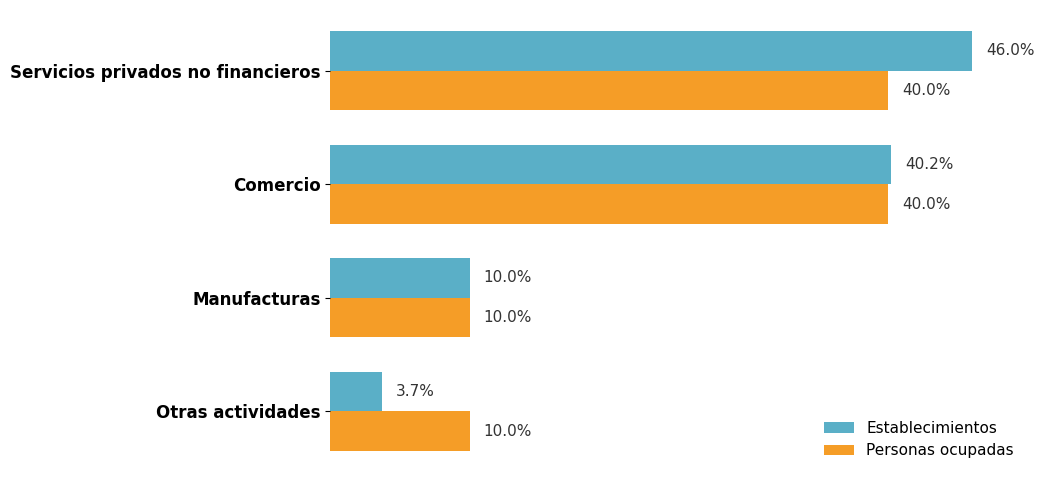

✅ Imagen guardada en salida\diapositiva_35_unidades_actividad.png


In [10]:
# -*- coding: utf-8 -*-
# Diapositiva 35: Unidades económicas según actividad económica

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

establecimientos = df_agrupado["UE Unidades económicas"].to_list()
personal = df_agrupado["H001A Personal ocupado total"].to_list()
# ---------------- Datos ----------------
categorias = df_agrupado["agrupado"].to_list()
establecimientos = [round((i/sum(establecimientos))*100, 1) for i in establecimientos]
ocupados         = [round((i/sum(ocupados))*100, 1) for i in ocupados]

# Colores según lámina
COL_EST = "#5AAFC7"  # azul teal
COL_OCU = "#F59D27"  # naranja

# ---------------- Salida ----------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_35_unidades_actividad.png"

# ---------------- Gráfico ----------------
y = np.arange(len(categorias))
height = 0.35

fig, ax = plt.subplots(figsize=(9,6))
fig.patch.set_facecolor("white")

# Barras
bars1 = ax.barh(y - height/2, establecimientos, height, color=COL_EST, label="Establecimientos")
bars2 = ax.barh(y + height/2, ocupados,        height, color=COL_OCU, label="Personas ocupadas")

# Etiquetas de porcentaje al final de cada barra
for bar, val in zip(bars1, establecimientos):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
            f"{val:.1f}%", va="center", ha="left", fontsize=11, color="#333333")

for bar, val in zip(bars2, ocupados):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
            f"{val:.1f}%", va="center", ha="left", fontsize=11, color="#333333")

# Ejes y estilo
ax.set_yticks(y)
ax.set_yticklabels(categorias, fontsize=12, fontweight="bold")
ax.invert_yaxis()

ax.set_xlim(0, 50)
ax.set_xticks([])

for spine in ["top","right","left","bottom"]:
    ax.spines[spine].set_visible(False)

# Título
# ax.set_title("Unidades económicas según actividad económica", fontsize=16, fontweight="bold", pad=15)
ax.legend(frameon=False, fontsize=11, loc="lower right")

# Subtítulos de series en la parte superior
# ax.text(22, -1.0, "Establecimientos", ha="center", fontsize=13, color=COL_EST, fontweight="bold")
# ax.text(42, -1.0, "Personas ocupadas", ha="center", fontsize=13, color=COL_OCU, fontweight="bold")

# plt.tight_layout()
plt.show()
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


In [79]:
import pandas as pd

data = pd.read_excel(r"E:\Usuarios\1163752\Downloads\SAIC_Exporta_20251024_11345795.xlsx", skiprows=4)

In [88]:
data[
    (data["Entidad"] == "25 Sinaloa") &
    (data["Año Censal"] == 2023) &
    (data["Estrato"] == "Suma de estratos") &
    (data["Actividad económica"] == "Total estatal")
]

data[
    # (data["Entidad"] == "25 Sinaloa") &
    (data["Año Censal"] == 2023) &
    (data["Estrato"] == "Suma de estratos") &
    (data["Actividad económica"] == "Total estatal")
].sort_values("H001A Personal ocupado total", ascending= False).reset_index(drop = True)

data[
    (data["Entidad"] == "25 Sinaloa") &
    (data["Año Censal"] == 2023) &
    (data["Estrato"] != "Suma de estratos") &
    (data["Actividad económica"] == "Total estatal")
]

dict_aux = {
 'Total nacional':'Total',
 'Total estatal':'Total',
 'Sector 43 Comercio al por mayor':'Comercio',
 'Sector 46 Comercio al por menor':'Comercio',
 'Sector 51 Información en medios masivos':'Servicios privados no financieros',
 'Sector 52 Servicios financieros y de seguros':'Servicios privados no financieros',
 'Sector 53 Servicios inmobiliarios y de alquiler de bienes muebles e intangibles':'Servicios privados no financieros',
 'Sector 54 Servicios profesionales, científicos y técnicos':'Servicios privados no financieros',
 'Sector 55 Dirección y administración de grupos empresariales o corporativos':'Servicios privados no financieros',
 'Sector 56 Servicios de apoyo a los negocios y manejo de residuos, y servicios de remediación':'Servicios privados no financieros',
 'Sector 61 Servicios educativos':'Servicios privados no financieros',
 'Sector 62 Servicios de salud y de asistencia social':'Servicios privados no financieros',
 'Sector 71 Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos':'Servicios privados no financieros',
 'Sector 72 Servicios de alojamiento temporal y de preparación de alimentos y bebidas':'Servicios privados no financieros',
 'Sector 81 Otros servicios excepto actividades gubernamentales':'Resto de actividades',
 'Sector 31-33 Industrias manufactureras':'Manufacturas',
 'Sector 22 Generación, transmisión, distribución y comercialización de energía eléctrica, suministro de agua y de gas natural por ductos al consumidor final':'Resto de actividades',
 'Sector 11 Agricultura, cría y explotación de animales, aprovechamiento forestal, pesca y caza':'Resto de actividades',
 'Sector 48-49 Transportes, correos y almacenamiento':'Resto de actividades',
 'Sector 23 Construcción':'Resto de actividades',
 'Sector 21 Minería':'Resto de actividades'
}

new_data = data[
    (data["Entidad"] == "25 Sinaloa") &
    (data["Año Censal"] == 2023) &
    (data["Estrato"] != "Suma de estratos") &
    (data["Actividad económica"] != "Total estatal")
]

new_data["Actividad"] = new_data["Actividad económica"].apply(lambda x: dict_aux[x])
new_data.groupby("Actividad").sum()

E:\Usuarios\1163752\AppData\Local\Temp\1\ipykernel_33512\1194423822.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data["Actividad"] = new_data["Actividad económica"].apply(lambda x: dict_aux[x])


,Año Censal,Entidad,Estrato,Actividad económica,UE Unidades económicas,H001A Personal ocupado total
Actividad,,,,,,
Comercio,16184,25 Sinaloa25 Sinaloa25 Sinaloa25 Sinaloa25 Sin...,0 a 1011 a 5051 a 250251 y más0 a 1011 a 5051 ...,Sector 43 Comercio al por mayorSector 43 Comer...,49449.0,218904.0
Manufacturas,8092,25 Sinaloa25 Sinaloa25 Sinaloa25 Sinaloa,0 a 1011 a 5051 a 250251 y más,Sector 31-33 Industrias manufacturerasSector 3...,12290.0,85244.0
Resto de actividades,36414,25 Sinaloa25 Sinaloa25 Sinaloa25 Sinaloa25 Sin...,0 a 1011 a 5051 a 250251 y más11 a 5051 a 2502...,"Sector 11 Agricultura, cría y explotación de a...",25872.0,139355.0
Servicios privados no financieros,40460,25 Sinaloa25 Sinaloa25 Sinaloa25 Sinaloa25 Sin...,0 a 1011 a 5051 a 2500 a 1011 a 500 a 1011 a 5...,Sector 53 Servicios inmobiliarios y de alquile...,29457.0,154915.0


In [15]:
import pandas as pd

aux = {"0 a 10":"Micro",
"11 a 50":"Pequeña",
"51 a 250":"Mediana",
"251 y más":"Grande"}

df = pd.read_excel(r"E:\Usuarios\1163752\Downloads\SAIC_Exporta_2025924_172157711.xlsx", skiprows=4)
df = df.query(" Entidad == '25 Sinaloa'")
df["Estrato"] = df["Estrato"].apply(lambda x: aux[x])

In [21]:
# -*- coding: utf-8 -*-
# Diapositiva 37: Personal ocupado según tamaño de establecimiento

from pathlib import Path
import matplotlib.pyplot as plt

# ---------------- Datos ----------------
labels = df["Estrato"].to_list()
valores = [round((i/sum(df["H001A Personal ocupado total"].to_list()))*100, 1) for i in df["H001A Personal ocupado total"].to_list()]

# Colores aproximados de la lámina
COL_MICRO   = "#F59D27"   # naranja
COL_PEQUENA = "#5AAFC7"   # azul teal
COL_MEDIANA = "#7F7F7F"   # gris
COL_GRANDE  = "#B3581B"   # café/naranja oscuro

colors = [COL_MICRO, COL_PEQUENA, COL_MEDIANA, COL_GRANDE]

# ---------------- Salida ----------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_37_personal_ocupado.png"

# ---------------- Gráfico ----------------
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_facecolor("white")

# Pastel
wedges, texts, autotexts = ax.pie(
    valores,
    labels=None,
    colors=colors,
    startangle=90,
    autopct="%.1f%%",
    pctdistance=0.8,
    wedgeprops=dict(width=1, edgecolor="white")
)

# Ajuste de los porcentajes
for t in autotexts:
    t.set_color("#333333")
    t.set_fontsize(11)
    t.set_fontweight("bold")

# Leyenda
ax.legend(wedges, labels,
          loc="lower center",
          bbox_to_anchor=(0.5, -0.1),
          ncol=4,
          frameon=False,
          fontsize=11)

# Título
# plt.title("Personal ocupado según tamaño de establecimiento",
#           fontsize=16, fontweight="bold", pad=15)

ax.set_aspect("equal")

# Guardar
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)

✅ Imagen guardada en salida\diapositiva_37_personal_ocupado.png


In [35]:
import pandas as pd


df = pd.read_excel(r"E:\Usuarios\1163752\Downloads\SAIC_Exporta_2025924_173157782.xlsx", skiprows=4)
df = df.query(" Entidad == '25 Sinaloa'")
# df["Estrato"] = df["Estrato"].apply(lambda x: aux[x])
row = df.iloc[0]

row["H010A Personal remunerado total"]
row["H020A Personas propietarias, familiares y otro personal no remunerado total"]
row["I000A Personal no dependiente de la razón social total"]
row["H001A Personal ocupado total"]


print(f"personas por establecimiento: {round(row["H001A Personal ocupado total"]/row["UE Unidades económicas"])}")
print(" ")

print(f"total: {row["H001A Personal ocupado total"]}")
print(f"Personal remunerado total: {round((row["H010A Personal remunerado total"]/row["H001A Personal ocupado total"])*100,1)}")
print(f"propietarias, familiares y otro personal no remunerado total: {round((row["H020A Personas propietarias, familiares y otro personal no remunerado total"]/row["H001A Personal ocupado total"])*100,1)}")
print(f"no dependiente de la razón social total: {round((row["I000A Personal no dependiente de la razón social total"]/row["H001A Personal ocupado total"])*100,1)}")

print(" ")
print(f"no dependiente de la razón social total: {row["I000A Personal no dependiente de la razón social total"]}")

personas por establecimiento: 5
 
total: 634394.0
Personal remunerado total: 75.8
propietarias, familiares y otro personal no remunerado total: 22.1
no dependiente de la razón social total: 2.2
 
no dependiente de la razón social total: 13642.0


In [ ]:
import pandas as pd

dict_aux = {
 'Total estatal':'Total Sinaloa',
 'Sector 43 Comercio al por mayor':'Comercio',
 'Sector 46 Comercio al por menor':'Comercio',
 'Sector 51 Información en medios masivos':'Servicios',
 'Sector 52 Servicios financieros y de seguros':'Servicios',
 'Sector 53 Servicios inmobiliarios y de alquiler de bienes muebles e intangibles':'Servicios',
 'Sector 54 Servicios profesionales, científicos y técnicos':'Servicios',
 'Sector 55 Dirección y administración de grupos empresariales o corporativos':'Servicios',
 'Sector 56 Servicios de apoyo a los negocios y manejo de residuos, y servicios de remediación':'Servicios',
 'Sector 61 Servicios educativos':'Servicios',
 'Sector 62 Servicios de salud y de asistencia social':'Servicios',
 'Sector 71 Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos':'Servicios',
 'Sector 72 Servicios de alojamiento temporal y de preparación de alimentos y bebidas':'Servicios',
 'Sector 81 Otros servicios excepto actividades gubernamentales':'Servicios',
 'Sector 31-33 Industrias manufactureras':'Manufacturas',
 'Sector 22 Generación, transmisión, distribución y comercialización de energía eléctrica, suministro de agua y de gas natural por ductos al consumidor final':'Electricidad, agua y gas',
 'Sector 11 Agricultura, cría y explotación de animales, aprovechamiento forestal, pesca y caza':'Pesca y acuicultura',
 'Sector 48-49 Transportes, correos y almacenamiento':'Transportes, correo y almacenamiento',
 'Sector 23 Construcción':'Construcción',
 'Sector 21 Minería':'Minería'
}

custom_order = {
    'Total Sinaloa': 0,
    'Comercio': 1,
    'Servicios': 2,
    'Manufacturas': 3,
    'Electricidad, agua y gas': 4,
    'Pesca y acuicultura': 5,
    'Transportes, correo y almacenamiento': 6,
    'Construcción': 7,
    'Minería': 8
}

df = pd.read_excel(r"E:\Usuarios\1163752\Downloads\SAIC_Exporta_2025924_18043545.xlsx", skiprows=4)
df = df.query(" Entidad == '25 Sinaloa'")
df["Actividad económica"] = df["Actividad económica"].apply(lambda x: dict_aux[x])
df_agrupado = df.groupby("Actividad económica").sum().reset_index()
del df

df_agrupado["Hombres"] = df_agrupado["H001B Personal ocupado total, hombres"]/(df_agrupado["H001B Personal ocupado total, hombres"] + df_agrupado["H001C Personal ocupado total, mujeres"])
df_agrupado["Mujeres"] = df_agrupado["H001C Personal ocupado total, mujeres"]/(df_agrupado["H001B Personal ocupado total, hombres"] + df_agrupado["H001C Personal ocupado total, mujeres"])

df_agrupado["Hombres"] = df_agrupado["Hombres"].apply(lambda x: round(x*100,1))
df_agrupado["Mujeres"] = df_agrupado["Mujeres"].apply(lambda x: round(x*100,1))

df_agrupado["custom_order"] = df_agrupado["Actividad económica"].apply(lambda x: custom_order[x])

df_agrupado = df_agrupado.sort_values("custom_order")

In [71]:
# -*- coding: utf-8 -*-
# Diapositiva 41: Personal ocupado por sexo y actividad económica (ajustada)

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# ---------------- Datos ----------------
categorias = df_agrupado["Actividad económica"].to_list()

hombres = df_agrupado["Hombres"].to_list()
mujeres = df_agrupado["Mujeres"].to_list()

# Colores
COL_HOMBRES = "#F59D27"   # naranja
COL_MUJERES = "#5AAFC7"   # azul teal

# ---------------- Salida ----------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_41_personal_sexo.png"

# ---------------- Gráfico ----------------
y = np.arange(len(categorias))

fig, ax = plt.subplots(figsize=(9,6))
fig.patch.set_facecolor("white")

# Barras apiladas
bars1 = ax.barh(y, hombres, color=COL_HOMBRES, label="Hombres")
bars2 = ax.barh(y, mujeres, left=hombres, color=COL_MUJERES, label="Mujeres")

# Etiquetas dentro de cada barra
for i, (h, m) in enumerate(zip(hombres, mujeres)):
    if h > 5:
        ax.text(h/2, i, f"{h:.1f}%", ha="center", va="center",
                fontsize=10, color="white", fontweight="bold")
    if m > 5:
        ax.text(h + m/2, i, f"{m:.1f}%", ha="center", va="center",
                fontsize=10, color="white", fontweight="bold")

# Ejes y estilo
ax.set_yticks(y)
ax.set_yticklabels(categorias, fontsize=11)
ax.invert_yaxis()

ax.set_xlim(0, 100)
ax.set_xticks(np.arange(0, 110, 10))
# ax.set_xlabel("%", fontsize=11)

# Bordes
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)       # quitar borde inferior
ax.spines["left"].set_color("#B3B3B3")       # borde izquierdo gris
ax.spines["left"].set_linewidth(1.2)

# Título
# ax.set_title("Personal ocupado por sexo y actividad económica",
#              fontsize=15, fontweight="bold", pad=15)

# Leyenda
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False)

plt.tight_layout()
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_41_personal_sexo.png


In [67]:
import pandas as pd

data = pd.read_excel(R"E:\Usuarios\1163752\Downloads\SAIC_Exporta_20251024_10340899.xlsx", skiprows= 4)
data["Remuneracion por persona"] = data["J000A Total de remuneraciones (millones de pesos)"]*1000000/data["H010A Personal remunerado total"]

In [73]:
# data[
#     (data["Entidad"].fillna("").str.upper().str.contains("SINALOA")) & 
#     (data["Actividad económica"].fillna("").str.upper().str.contains("TOTAL")) &
#     (data["Estrato"] == "Suma de estratos")
#     ]

data[
    (data["Año Censal"] == 2023) &
    (data["Actividad económica"].fillna("").str.upper().str.contains("TOTAL")) &
    (data["Estrato"] == "Suma de estratos") & 
    (data["Entidad"] != "00 Total Nacional")
    ].sort_values("Remuneracion por persona", ascending= False).reset_index(drop = True)

63357.625

data[
    (data["Año Censal"] == 2023) &
    (data["Estrato"] == "Suma de estratos") & 
    (data["Entidad"] == "25 Sinaloa")
    ].sort_values("Remuneracion por persona", ascending= False).reset_index(drop = True)


,Año Censal,Entidad,Estrato,Actividad económica,UE Unidades económicas,J000A Total de remuneraciones (millones de pesos),H010A Personal remunerado total,Remuneracion por persona
0,2023,25 Sinaloa,Suma de estratos,Sector 55 Dirección y administración de grupos...,14.0,27.901,57.0,489491.228070
1,2023,25 Sinaloa,Suma de estratos,"Sector 22 Generación, transmisión, distribució...",18.0,1236.398,4443.0,278279.990997
2,2023,25 Sinaloa,Suma de estratos,Sector 52 Servicios financieros y de seguros,1194.0,992.033,5732.0,173069.260293
3,2023,25 Sinaloa,Suma de estratos,Sector 21 Minería,48.0,346.191,2022.0,171212.166172
4,2023,25 Sinaloa,Suma de estratos,Sector 31-33 Industrias manufactureras,12290.0,11147.136,69286.0,160885.835522
5,2023,25 Sinaloa,Suma de estratos,Sector 43 Comercio al por mayor,4154.0,7193.245,47388.0,151794.652655
6,2023,25 Sinaloa,Suma de estratos,"Sector 48-49 Transportes, correos y almacenami...",541.0,3229.980,22443.0,143919.262131
7,2023,25 Sinaloa,Suma de estratos,Sector 46 Comercio al por menor,45295.0,16286.459,118672.0,137239.272954
8,2023,25 Sinaloa,Suma de estratos,Sector 61 Servicios educativos,1146.0,2022.752,14794.0,136727.862647
9,2023,25 Sinaloa,Suma de estratos,Sector 62 Servicios de salud y de asistencia s...,7327.0,2280.952,16943.0,134625.036888


In [74]:
(45295.0+4154.0)/122935.0

0.4022369544881441

In [ ]:
import pandas as pd

aux = {"0 a 10":"Micro",
"11 a 50":"Pequeña",
"51 a 250":"Mediana",
"251 y más":"Grande"}

df = pd.read_excel(r"E:\Usuarios\1163752\Downloads\SAIC_Exporta_2025924_182358215.xlsx", skiprows=4)
df = df[df["Año Censal"] == 2023]
df["Estrato"] = df["Estrato"].apply(lambda x: aux[x])

df_pivot = df.pivot(index='Entidad', columns='Estrato', values='J000A Total de remuneraciones (millones de pesos)').reset_index()
df_pivot = df_pivot[["Entidad","Micro","Pequeña","Mediana","Grande"]]

df = df.query(" Entidad == '25 Sinaloa'")
remuneraciones = df['J000A Total de remuneraciones (millones de pesos)'].to_list()

In [89]:

# -*- coding: utf-8 -*-
# Diapositiva 44: Tamaño de los establecimientos (pastel simple)

from pathlib import Path
import matplotlib.pyplot as plt

# ---------------- Datos ----------------
labels = ["Micro", "Pequeña", "Mediana", "Grande"]
valores = [round((i/sum(remuneraciones))*100,1) for i in remuneraciones]

# Colores aproximados a la lámina
colors = ["#b87333", "#e67e22", "#f6a36b", "#f8cfc2"]

# ---------------- Salida ----------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_44_tamano_establecimientos.png"

# ---------------- Gráfico ----------------
fig, ax = plt.subplots(figsize=(5,5))
fig.patch.set_facecolor("white")

# Pie chart
wedges, texts, autotexts = ax.pie(
    valores,
    labels=None,
    colors=colors,
    startangle=90,
    autopct="%.1f%%",
    pctdistance=0.8,
    wedgeprops=dict(edgecolor="white")
)

# Estilo de etiquetas
for t in autotexts:
    t.set_color("white")
    t.set_fontsize(11)
    t.set_fontweight("bold")

# Leyenda arriba
ax.legend(wedges, labels,
          loc="upper center",
          bbox_to_anchor=(0.5, 1.03),
          ncol=4,
          frameon=False,
          fontsize=10)

ax.set_aspect("equal")

# Guardar
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_44_tamano_establecimientos.png


In [ ]:
import pandas as pd

df = pd.read_excel(r"E:\Usuarios\1163752\Downloads\SAIC_Exporta_2025924_184122865.xlsx", skiprows=4)
df = df.query(" Entidad == '25 Sinaloa'")

row = df.iloc[0]

In [108]:

# -*- coding: utf-8 -*-
# Diapositiva 45: Distribución de remuneraciones (gráfico de dona)

from pathlib import Path
import matplotlib.pyplot as plt

# ---------------- Datos ----------------

total = row["J000A Total de remuneraciones (millones de pesos)"]
prestaciones = row["J400A Otras prestaciones sociales (millones de pesos)"] + row["J300A Contribuciones patronales a regímenes de seguridad social (millones de pesos)"]

labels = ["Salarios", "Sueldos", "Prestaciones sociales", "Utilidades repartidas"]
valores = [
    round((row["J010A Total de salarios al personal de producción, ventas y servicios (millones de pesos)"]/total)*100,1), 
    round((row["J203A Total de sueldos al personal administrativo, contable y de dirección (millones de pesos)"]/total)*100,1), 
    round((prestaciones/total)*100,1), 
    round((row["J500A Utilidades repartidas al personal (millones de pesos)"]/total)*100,1)]

# Colores aproximados de la lámina
colors = ["#2d869c", "#55a9bf", "#8bc3d4", "#cfe6ec"]

# ---------------- Salida ----------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_45_remuneraciones.png"

# ---------------- Gráfico ----------------
fig, ax = plt.subplots(figsize=(6,6))
fig.patch.set_facecolor("white")

# Gráfico tipo dona
wedges, texts, autotexts = ax.pie(
    valores,
    labels=labels,
    colors=colors,
    startangle=90,
    autopct="%.1f%%",
    pctdistance=0.85,
    wedgeprops=dict(width=0.55, edgecolor="white")
)

# Ajuste de etiquetas de porcentaje
for t in autotexts:
    t.set_color("black")
    t.set_fontsize(10)
    t.set_fontweight("bold")

# Leyenda
ax.legend(wedges, labels,
          loc="lower center",
          bbox_to_anchor=(0.5, -0.08),
          ncol=2,
          frameon=False,
          fontsize=11)

ax.set_aspect("equal")

# Guardar
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_45_remuneraciones.png


In [141]:
df = pd.read_excel(r"E:\Usuarios\1163752\Downloads\SAIC_Exporta_2025925_184257644.xlsx", skiprows=4)
df

,Año Censal,Entidad,Estrato,Actividad económica,UE Unidades económicas,J000A Total de remuneraciones (millones de pesos),H001A Personal ocupado total,H010A Personal remunerado total
0,2023,00 Total Nacional,Suma de estratos,Total nacional,5468180.0,3474422.828,27965433.0,20598507.0
1,2023,00 Total Nacional,0 a 10,Total nacional,5214497.0,460917.601,11575621.0,5077809.0
2,2023,00 Total Nacional,11 a 50,Total nacional,204814.0,502698.569,4219345.0,3947738.0
3,2023,00 Total Nacional,51 a 250,Total nacional,39122.0,683619.499,4144399.0,3954506.0
4,2023,00 Total Nacional,251 y más,Total nacional,9747.0,1827187.159,8026068.0,7618454.0
5,2023,25 Sinaloa,Suma de estratos,Total estatal,122935.0,63357.625,634394.0,480611.0
6,2023,25 Sinaloa,0 a 10,Total estatal,114853.0,14666.053,278881.0,145645.0
7,2023,25 Sinaloa,11 a 50,Total estatal,6774.0,16632.062,139313.0,129199.0
8,2023,25 Sinaloa,51 a 250,Total estatal,1157.0,16866.296,117932.0,110748.0
9,2023,25 Sinaloa,251 y más,Total estatal,151.0,15193.214,98268.0,95019.0


In [143]:
import pandas as pd

aux = {"0 a 10":"Micro",
"11 a 50":"Pequeña",
"51 a 250":"Mediana",
"251 y más":"Grande"}

remap= {
    'J000A Total de remuneraciones (millones de pesos)':"REM",
    "UE Unidades económicas":"UE",
    "H010A Personal remunerado total":"REM_PER"
}

df = pd.read_excel(r"E:\Usuarios\1163752\Downloads\SAIC_Exporta_2025925_184257644.xlsx", skiprows=4)
df = df[(df["Año Censal"] == 2023) & (df["Estrato"] != "Suma de estratos")]
df["Estrato"] = df["Estrato"].apply(lambda x: aux[x])

df.rename(columns=remap, inplace= True)
df_pivot = df.pivot(index='Entidad', columns='Estrato', values=['REM',"REM_PER"]).reset_index()
# df_pivot = df_pivot[["Entidad","Micro","Pequeña","Mediana","Grande"]]

In [163]:
# -*- coding: utf-8 -*-
# Diapositiva 46: Remuneraciones medias en miles de pesos (sin bordes)

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# ---------------- Datos ----------------
nacional = round(((df_pivot["REM"]*1000)/df_pivot["REM_PER"]),1).iloc[0]
estatal = round(((df_pivot["REM"]*1000)/df_pivot["REM_PER"]),1).iloc[1]

categorias = ["Micro", "Pequeña", "Mediana", "Grande"]
nacional   = [nacional["Micro"], nacional["Pequeña"], nacional["Mediana"], nacional["Grande"]]
estatal    = [estatal["Micro"], estatal["Pequeña"], estatal["Mediana"], estatal["Grande"]]

# Colores
COL_NAC = "#F59D27"   # naranja
COL_EST = "#5AAFC7"   # azul teal

# ---------------- Salida ----------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_46_remuneraciones.png"

# ---------------- Gráfico ----------------
x = np.arange(len(categorias))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
fig.patch.set_facecolor("white")

bars1 = ax.bar(x - width/2, nacional, width, label="Nacional", color=COL_NAC)
bars2 = ax.bar(x + width/2, estatal,  width, label="Estatal",  color=COL_EST)

# Etiquetas encima de cada barra
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f"{bar.get_height():.1f}", ha="center", va="bottom", fontsize=10, color="#333333")
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f"{bar.get_height():.1f}", ha="center", va="bottom", fontsize=10, color="#333333")

# Ejes y estilo
ax.set_xticks(x)
ax.set_xticklabels(categorias, fontsize=11)
ax.set_yticklabels([])
ax.set_ylim(0, 250)

# Quitar todos los bordes
for spine in ["top","right","left","bottom"]:
    ax.spines[spine].set_visible(False)

# Quitar ticks verticales
ax.yaxis.set_ticks_position("none")
ax.xaxis.set_ticks_position("none")
ax.yaxis.set_ticks_position("none")

# Título
# ax.set_title("Remuneraciones medias en miles de pesos",
#              fontsize=14, fontweight="bold", pad=12)

# Leyenda
ax.legend(frameon=False, loc="upper left")

plt.tight_layout()
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_46_remuneraciones.png


In [ ]:
import pandas as pd

dict_aux = {
 'Total nacional':'Total',
 'Total estatal':'Total',
 'Sector 43 Comercio al por mayor':'Comercio',
 'Sector 46 Comercio al por menor':'Comercio',
 'Sector 51 Información en medios masivos':'Servicios privados no financieros',
 'Sector 52 Servicios financieros y de seguros':'Servicios privados no financieros',
 'Sector 53 Servicios inmobiliarios y de alquiler de bienes muebles e intangibles':'Servicios privados no financieros',
 'Sector 54 Servicios profesionales, científicos y técnicos':'Servicios privados no financieros',
 'Sector 55 Dirección y administración de grupos empresariales o corporativos':'Servicios privados no financieros',
 'Sector 56 Servicios de apoyo a los negocios y manejo de residuos, y servicios de remediación':'Servicios privados no financieros',
 'Sector 61 Servicios educativos':'Servicios privados no financieros',
 'Sector 62 Servicios de salud y de asistencia social':'Servicios privados no financieros',
 'Sector 71 Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos':'Servicios privados no financieros',
 'Sector 72 Servicios de alojamiento temporal y de preparación de alimentos y bebidas':'Servicios privados no financieros',
 'Sector 81 Otros servicios excepto actividades gubernamentales':'Resto de actividades',
 'Sector 31-33 Industrias manufactureras':'Manufacturas',
 'Sector 22 Generación, transmisión, distribución y comercialización de energía eléctrica, suministro de agua y de gas natural por ductos al consumidor final':'Resto de actividades',
 'Sector 11 Agricultura, cría y explotación de animales, aprovechamiento forestal, pesca y caza':'Resto de actividades',
 'Sector 48-49 Transportes, correos y almacenamiento':'Resto de actividades',
 'Sector 23 Construcción':'Resto de actividades',
 'Sector 21 Minería':'Resto de actividades'
}

custom_order = {
    'Total': 0,
    'Manufacturas': 1,
    'Comercio': 2,
    'Servicios privados no financieros': 3,
    'Resto de actividades': 4,
}

remap= {
    'J000A Total de remuneraciones (millones de pesos)':"REM",
    "UE Unidades económicas":"UE",
    "H010A Personal remunerado total":"REM_PER"
}

df = pd.read_excel(r"E:\Usuarios\1163752\Downloads\SAIC_Exporta_2025925_18535674.xlsx", skiprows = 4)
df = df[(df["Año Censal"] == 2023)]
df["Actividad económica"] = df["Actividad económica"].apply(lambda x: dict_aux[x])
df_agrupado = df.groupby(["Actividad económica","Entidad"]).sum().reset_index()
del df

df_agrupado["custom_order"] = df_agrupado["Actividad económica"].apply(lambda x: custom_order[x])
df_agrupado = df_agrupado.sort_values("custom_order")
df_agrupado.rename(columns= remap, inplace= True)


In [181]:
df_agrupado

,Actividad económica,Entidad,Año Censal,UE,REM,REM_PER,custom_order
9,Total,25 Sinaloa,2023,122935.0,63357.625,480611.0,0
8,Total,00 Total Nacional,2023,5468180.0,3474422.828,20598507.0,0
3,Manufacturas,25 Sinaloa,2023,12290.0,11147.136,69286.0,1
2,Manufacturas,00 Total Nacional,2023,634248.0,1296972.558,6298902.0,1
1,Comercio,25 Sinaloa,4046,49449.0,23479.704,166060.0,2
0,Comercio,00 Total Nacional,4046,2585753.0,738719.280,5507572.0,2
7,Servicios privados no financieros,25 Sinaloa,22253,57806.0,18458.627,164805.0,3
6,Servicios privados no financieros,00 Total Nacional,22253,2174797.0,1033674.942,6502735.0,3
4,Resto de actividades,00 Total Nacional,10115,73382.0,405056.048,2289298.0,4
5,Resto de actividades,25 Sinaloa,10115,3390.0,10272.158,80460.0,4


In [199]:
# -*- coding: utf-8 -*-
# Diapositiva 47: Remuneraciones medias en miles de pesos (barras horizontales)

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# ---------------- Datos ----------------
categorias = [
    "Total",
    "Manufacturas",
    "Comercio",
    "Servicios privados no financieros",
    "Resto de actividades",
]
# Valores (miles de pesos)
nacional = round(((df_agrupado.query("Entidad == '00 Total Nacional'")["REM"]*1000)/df_agrupado.query("Entidad == '00 Total Nacional'")["REM_PER"]),1).to_list()
estatal = round(((df_agrupado.query("Entidad == '25 Sinaloa'")["REM"]*1000)/df_agrupado.query("Entidad == '25 Sinaloa'")["REM_PER"]),1).to_list()

# ---------------- Estilo/colores ----------------
COL_NAC = "#A9D5E0"   # azul muy claro (Nacional)
COL_EST = "#2F7F99"   # azul teal (Estatal)
COL_TXT = "#555555"
COL_AXIS = "#DADADA"

# ---------------- Salida ----------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_47_remuneraciones.png"

# ---------------- Gráfico ----------------
y = np.arange(len(categorias))
h = 0.32  # altura de barra
off = h/2 + 0.02

fig, ax = plt.subplots(figsize=(10, 4.2))
fig.patch.set_facecolor("white")

# Barras (Nacional arriba, Estatal abajo por categoría)
ax.barh(y + off, nacional, height=h, color=COL_NAC, label="Nacional")
ax.barh(y - off, estatal,  height=h, color=COL_EST, label="Estatal")

# Etiquetas numéricas al final de cada barra
def etiqueta_final(x, y_pos, color="#555"):
    for xv, yv in zip(x, y_pos):
        ax.text(xv + (max(nacional+estatal)*0.01), yv,
                f"{xv:.1f}", va="center", ha="left",
                fontsize=10, color=color)

etiqueta_final(nacional, y + off, color=COL_TXT)
etiqueta_final(estatal,  y - off, color=COL_TXT)

# Ejes, títulos y estilo
ax.set_yticks(y)
ax.set_yticklabels(categorias, fontsize=11, color=COL_TXT)
ax.invert_yaxis()

# Rango X un poco mayor para que quepan etiquetas
xmax = max(nacional + estatal) * 1.08
ax.set_xlim(0, xmax)

# Título
# ax.set_title("Remuneraciones medias en miles de pesos",
#              fontsize=14, fontweight="bold", color=COL_TXT, pad=10)

# Leyenda a la derecha, centrada verticalmente
ax.legend(loc="center left", bbox_to_anchor=(1.01, 0.5), frameon=False)

# Limpieza de bordes
for s in ["top", "right", "bottom"]:
    ax.spines[s].set_visible(False)
# Dejar línea izquierda tenue (como referencia)
ax.spines["left"].set_color(COL_AXIS)
ax.spines["left"].set_linewidth(1)

# Quitar “ticks” en X y dejar pocos en Y (solo categorías)
ax.xaxis.set_ticks_position("none")
ax.yaxis.set_ticks_position("none")
ax.set_xticks([])

plt.tight_layout()
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_47_remuneraciones.png


In [32]:
import pandas as pd

data = pd.read_excel(r"E:\Usuarios\1163752\Downloads\SAIC_Exporta_20251024_10841609.xlsx", skiprows=4)

In [52]:
data[
    (data["Entidad"].str.contains("Sinaloa")) & 
    (data["Año Censal"] == 2023) & 
    (data["Estrato"] == "Suma de estratos")]

,Año Censal,Entidad,Estrato,Actividad económica,UE Unidades económicas,A111A Producción bruta total (millones de pesos)
1675,2023,25 Sinaloa,Suma de estratos,"Sector 11 Agricultura, cría y explotación de a...",2118.0,15238.387
1680,2023,25 Sinaloa,Suma de estratos,Sector 21 Minería,48.0,2208.942
1681,2023,25 Sinaloa,Suma de estratos,"Sector 22 Generación, transmisión, distribució...",18.0,3844.018
1685,2023,25 Sinaloa,Suma de estratos,Sector 23 Construcción,665.0,24416.537
1690,2023,25 Sinaloa,Suma de estratos,Sector 31-33 Industrias manufactureras,12290.0,105364.872
1695,2023,25 Sinaloa,Suma de estratos,Sector 43 Comercio al por mayor,4154.0,63361.011
1700,2023,25 Sinaloa,Suma de estratos,Sector 46 Comercio al por menor,45295.0,81258.314
1705,2023,25 Sinaloa,Suma de estratos,"Sector 48-49 Transportes, correos y almacenami...",541.0,14541.451
1710,2023,25 Sinaloa,Suma de estratos,Sector 51 Información en medios masivos,183.0,2082.729
1711,2023,25 Sinaloa,Suma de estratos,Sector 52 Servicios financieros y de seguros,1194.0,6691.968


In [49]:
data_agrupada = data[(data["Año Censal"] == 2023) & (data["Estrato"] == "Suma de estratos")]
data_agrupada = data_agrupada.groupby("Entidad")[
    ["A111A Producción bruta total (millones de pesos)",
     "UE Unidades económicas"]] \
    .sum().sort_values("A111A Producción bruta total (millones de pesos)", ascending= False) \
    .reset_index()
data_agrupada

,Entidad,A111A Producción bruta total (millones de pesos),UE Unidades económicas
0,00 Total Nacional,3.014741e+07,5468180.0
1,09 Ciudad de México,6.049293e+06,425005.0
2,19 Nuevo León,2.976584e+06,181791.0
3,15 México,2.454923e+06,749365.0
4,11 Guanajuato,1.923715e+06,270040.0
5,14 Jalisco,1.870778e+06,365421.0
6,05 Coahuila de Zaragoza,1.687585e+06,109235.0
7,30 Veracruz de Ignacio de la Llave,1.086493e+06,314344.0
8,21 Puebla,9.723042e+05,368108.0
9,22 Querétaro,9.624254e+05,97696.0


In [53]:
105364.872/408929.304

0.25766036077473187

In [ ]:
import pandas as pd

def proporcion(serie: pd.Series):
    """
    Calcula la proporción de cada valor respecto al total de la serie.
    """
    total = serie.sum()
    return serie.apply(lambda x: round((x/total)*100, 1)).to_list()

aux = {"0 a 10":"Micro",
"11 a 50":"Pequeña",
"51 a 250":"Mediana",
"251 y más":"Grande"}

df = pd.read_excel(r"E:\Usuarios\1163752\Downloads\SAIC_Exporta_2025930_181933912.xlsx", skiprows=4)

df_49 = df[(df["Actividad económica"] == "Total estatal") & (df["Estrato"] != "Suma de estratos")]
df_49 = df_49.groupby("Estrato").agg(produccion = pd.NamedAgg("A111A Producción bruta total (millones de pesos)","sum")).reset_index()
df_49["Estrato"] = df_49["Estrato"].apply(lambda x: aux[x])

In [20]:
# -*- coding: utf-8 -*-
# Diapositiva 49: Dona por tamaño (Micro, Pequeña, Mediana, Grande)

from pathlib import Path
import matplotlib.pyplot as plt

# -------- Datos (porcentajes) --------
labels  = ["Micro", "Pequeña", "Mediana", "Grande"]
values  = proporcion(df_49["produccion"])

# Azules en degradado (de más intenso a más claro)
colors = ["#2F7F99", "#46A3B8", "#8AC1D1", "#C8E0E7"]

# -------- Salida --------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_49_dona_tamano.png"

# -------- Gráfico --------
fig, ax = plt.subplots(figsize=(4.6, 4.6))
fig.patch.set_facecolor("white")

# Dona: ancho moderado y separador blanco fino
wedges, texts, autotexts = ax.pie(
    values,
    colors=colors,
    startangle=90,
    counterclock=False,
    autopct="%.1f%%",
    pctdistance=0.78,
    wedgeprops=dict(width=0.45, edgecolor="white", linewidth=2)
)

# Centro blanco de la dona (opcional si quieres más “hueco” visual)
circle = plt.Circle((0, 0), 0.45, color="white", zorder=0)
# ax.add_artist(circle)

# Estética de los textos
for t in autotexts:
    t.set_color("#FFFFFF")
    t.set_fontsize(10)
    t.set_fontweight("bold")
for t in texts:
    t.set_visible(False)  # no mostrar etiquetas de categorías dentro

# Leyenda arriba, horizontal y sin marco
ax.legend(wedges, labels, ncol=4, frameon=False,
          loc="upper center", bbox_to_anchor=(0.5, 1.05), fontsize=10)

ax.set_aspect("equal")
# Sin bordes/spines
for s in ["top", "right", "left", "bottom"]:
    ax.spines.get(s, None) and ax.spines[s].set_visible(False)

plt.tight_layout()
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_49_dona_tamano.png


In [ ]:
dict_aux = {
 'Total nacional':'Total',
 'Total estatal':'Total',
 'Sector 43 Comercio al por mayor':'Comercio',
 'Sector 46 Comercio al por menor':'Comercio',
 'Sector 51 Información en medios masivos':'Servicios privados no financieros',
 'Sector 52 Servicios financieros y de seguros':'Servicios privados no financieros',
 'Sector 53 Servicios inmobiliarios y de alquiler de bienes muebles e intangibles':'Servicios privados no financieros',
 'Sector 54 Servicios profesionales, científicos y técnicos':'Servicios privados no financieros',
 'Sector 55 Dirección y administración de grupos empresariales o corporativos':'Servicios privados no financieros',
 'Sector 56 Servicios de apoyo a los negocios y manejo de residuos, y servicios de remediación':'Servicios privados no financieros',
 'Sector 61 Servicios educativos':'Servicios privados no financieros',
 'Sector 62 Servicios de salud y de asistencia social':'Servicios privados no financieros',
 'Sector 71 Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos':'Servicios privados no financieros',
 'Sector 72 Servicios de alojamiento temporal y de preparación de alimentos y bebidas':'Servicios privados no financieros',
 'Sector 81 Otros servicios excepto actividades gubernamentales':'Resto de actividades',
 'Sector 31-33 Industrias manufactureras':'Manufacturas',
 'Sector 22 Generación, transmisión, distribución y comercialización de energía eléctrica, suministro de agua y de gas natural por ductos al consumidor final':'Resto de actividades',
 'Sector 11 Agricultura, cría y explotación de animales, aprovechamiento forestal, pesca y caza':'Resto de actividades',
 'Sector 48-49 Transportes, correos y almacenamiento':'Resto de actividades',
 'Sector 23 Construcción':'Resto de actividades',
 'Sector 21 Minería':'Resto de actividades'
}

df_50 = df[
    (df["Año Censal"] == 2023) & 
    (df["Actividad económica"] != "Total estatal") & 
    (df["Estrato"] != "Suma de estratos")
    ]
df_50.loc[:, "Actividad económica"] = df_50["Actividad económica"].apply(lambda x: dict_aux[x])
df_50 = df_50.groupby("Actividad económica")["A111A Producción bruta total (millones de pesos)"].sum().reset_index()

In [ ]:
# -*- coding: utf-8 -*-
# Diapositiva 50: Distribución porcentual (Comercio, Manufacturas, Servicios, Otros)

from pathlib import Path
import matplotlib.pyplot as plt

# ------------------ Datos ------------------
labels = df_50["Actividad económica"].to_list()
values = proporcion(df_50["A111A Producción bruta total (millones de pesos)"])

# Colores degradados azul-gris como en la diapositiva
colors = ["#004c5c", "#006d82", "#5a8da1", "#b5c3cb"]

# ------------------ Salida ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_50_pie.png"

# ------------------ Gráfico ------------------
fig, ax = plt.subplots(figsize=(5,5))
fig.patch.set_facecolor("white")

wedges, texts, autotexts = ax.pie(
    values,
    labels=None,
    colors=colors,
    startangle=90,
    autopct="%.1f%%",
    pctdistance=0.8,
    wedgeprops=dict(edgecolor="white")
)

# Estilo de porcentajes: blancos y en negrita
for t in autotexts:
    t.set_color("white")
    t.set_fontsize(11)
    t.set_fontweight("bold")

# Quitar textos duplicados
for t in texts:
    t.set_visible(False)

# Leyenda arriba en horizontal
ax.legend(
    wedges, labels,
    loc="upper center", bbox_to_anchor=(0.5, 1.03),
    ncol=4, frameon=False, fontsize=10
)

ax.set_aspect("equal")

# Guardar
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)

✅ Imagen guardada en salida\diapositiva_50_pie.png


In [ ]:
dict_aux = {
 'Total nacional':'Total',
 'Total estatal':'Total',
 'Sector 43 Comercio al por mayor':'Comercio al por mayor',
 'Sector 46 Comercio al por menor':'Comercio al por mayor',
 'Sector 51 Información en medios masivos':'Informacion en medios masivos',
 'Sector 52 Servicios financieros y de seguros':'Servicios financieros',
 'Sector 53 Servicios inmobiliarios y de alquiler de bienes muebles e intangibles':'Servicios inmobiliarios',
 'Sector 54 Servicios profesionales, científicos y técnicos':'Servicios privados no financieros',
 'Sector 55 Dirección y administración de grupos empresariales o corporativos':'Corporativos',
 'Sector 56 Servicios de apoyo a los negocios y manejo de residuos, y servicios de remediación':'Servicios privados no financieros',
 'Sector 61 Servicios educativos':'Servicios privados no financieros',
 'Sector 62 Servicios de salud y de asistencia social':'Servicios privados no financieros',
 'Sector 71 Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos':'Servicios privados no financieros',
 'Sector 72 Servicios de alojamiento temporal y de preparación de alimentos y bebidas':'Servicios privados no financieros',
 'Sector 81 Otros servicios excepto actividades gubernamentales':'Resto de actividades',
 'Sector 31-33 Industrias manufactureras':'Industrias manufactureras',
 'Sector 22 Generación, transmisión, distribución y comercialización de energía eléctrica, suministro de agua y de gas natural por ductos al consumidor final':'Generacion de energía',
 'Sector 11 Agricultura, cría y explotación de animales, aprovechamiento forestal, pesca y caza':'Resto de actividades',
 'Sector 48-49 Transportes, correos y almacenamiento':'Resto de actividades',
 'Sector 23 Construcción':'Construcción',
 'Sector 21 Minería':'Mineria'
}

df_51 = df[
    (df["Año Censal"] == 2023) & 
    (df["Actividad económica"] != "Total estatal") & 
    (df["Estrato"] != "Suma de estratos")
    ]
df_51.loc[:, "Actividad económica"] = df_51["Actividad económica"].apply(lambda x: dict_aux[x])
df_51 = df_51.groupby("Actividad económica").agg(
    produccion = pd.NamedAgg("A111A Producción bruta total (millones de pesos)", "sum"),
    personas = pd.NamedAgg("H001A Personal ocupado total", "sum")
).reset_index()
df_51["produccion_promedio"] = (df_51["produccion"] / df_51["personas"])*1000
df_51.sort_values("produccion_promedio", ascending=False, inplace=True)

print(f"produccion media estatal: {(df_51["produccion"].sum()*1000 / df_51["personas"].sum())}")


produccion media estatal: 648.7102309756724


In [52]:
# -*- coding: utf-8 -*-
# Diapositiva 51: Producción Bruta por persona ocupada en miles de pesos (barras horizontales)

from pathlib import Path
import matplotlib.pyplot as plt

# ------------------ Datos ------------------
categorias = df_51["Actividad económica"].to_list()
valores = round(df_51["produccion_promedio"], 1).to_list()

# ------------------ Estilo ------------------
COL_BAR = "#f28c38"
COL_TXT = "#333333"

# ------------------ Salida ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_51_produccion_bruta.png"

# ------------------ Gráfico ------------------
fig, ax = plt.subplots(figsize=(9, 5.2))
fig.patch.set_facecolor("white")

# Barras horizontales
ax.barh(categorias, valores, color=COL_BAR, zorder=3)

# Etiquetas de valores a la derecha de cada barra
for i, v in enumerate(valores):
    ax.text(v + max(valores)*0.01, i, f"{v:,}", 
            va="center", ha="left", fontsize=11, color=COL_TXT)

# Estética
ax.set_xlim(0, max(valores)*1.15)
ax.invert_yaxis()  # para que el orden sea de arriba hacia abajo
ax.set_xticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_color("#E6E6E6")

# ax.set_title("Producción Bruta en miles de pesos", fontsize=15, fontweight="bold", pad=15)

# Guardar
plt.tight_layout()
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_51_produccion_bruta.png


In [70]:
aux = {"0 a 10":"Micro",
"11 a 50":"Pequeña",
"51 a 250":"Mediana",
"251 y más":"Grande"}

_aux_ = {"Micro":0,
"Pequeña":1,
"Mediana":2,
"Grande":3}

df_52 = df[
    (df["Año Censal"] == 2023) & 
    (df["Actividad económica"] != "Total estatal") & 
    (df["Estrato"] != "Suma de estratos")
    ]

df_52.loc[:,"Estrato"] = df_52["Estrato"].apply(lambda x: aux[x])
df_52 = df_52.groupby("Estrato").agg(
    unidades = pd.NamedAgg("UE Unidades económicas", "sum"),
    personas = pd.NamedAgg("H001A Personal ocupado total", "sum"),
    ingresos = pd.NamedAgg("M000A Total de ingresos por suministro de bienes y servicios (millones de pesos)", "sum"),
    produccion = pd.NamedAgg("A111A Producción bruta total (millones de pesos)", "sum")
).reset_index()
df_52["orden"] = df_52["Estrato"].apply(lambda x: _aux_[x])
df_52.sort_values("orden", inplace=True)

In [73]:
# -*- coding: utf-8 -*-
# Diapositiva 52: Principales variables en porcentaje

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ------------------ Datos ------------------
CATS = ["Micro", "Pequeña", "Mediana", "Grande"]

# Orden de series (como la leyenda del ejemplo):
# Unidades económicas, Personal ocupado, Ingresos, Producción
UE   = proporcion(df_52["unidades"])
PO   = proporcion(df_52["personas"])
ING  = proporcion(df_52["ingresos"])
PROD = proporcion(df_52["produccion"])

series = [UE, PO, ING, PROD]
labels = ["Unidades económicas", "Personal ocupado", "Ingresos", "Producción"]

# Paleta azul en degradado (oscuro → claro)
COLS = ["#215d6a", "#4f94a7", "#93bdcb", "#cfe3ea"]

# ------------------ Lienzo/Salida ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_52_principales_variables.png"

fig, ax = plt.subplots(figsize=(9, 5.0))
fig.patch.set_facecolor("white")

x = np.arange(len(CATS))
width = 0.18
offsets = np.linspace(-1.5, 1.5, 4) * width  # centra los 4 bars por grupo

# ------------------ Barras + etiquetas ------------------
for i, (vals, lab, col, off) in enumerate(zip(series, labels, COLS, offsets)):
    bars = ax.bar(x + off, vals, width=width, color=col, label=lab, zorder=3)
    # etiquetas de porcentaje encima de cada barra
    for bx, v in zip(bars, vals):
        ax.text(bx.get_x() + bx.get_width()/2, v + 0.8, f"{v:.1f}%",
                ha="center", va="bottom", fontsize=7, color="#4a4a4a", fontweight="bold")

# ------------------ Estética ------------------
# ax.set_title("Principales variables en porcentaje", fontsize=14, fontweight="bold", pad=10)
ax.set_xticks(x, CATS, fontsize=10)
ax.set_ylim(0, max(max(s) for s in series) * 1.18)

# Quitar spines (menos el inferior en gris suave)
for s in ["top", "right", "left"]:
    ax.spines[s].set_visible(False)
ax.spines["bottom"].set_color("#E6E6E6")
ax.tick_params(axis="y", length=0, labelleft=False)
ax.tick_params(axis="x", length=0)

# Leyenda abajo, horizontal
leg = ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.08),
                ncol=4, frameon=False, fontsize=9)

plt.tight_layout()
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)

✅ Imagen guardada en salida\diapositiva_52_principales_variables.png


In [1]:
import pandas as pd

aux = {"0 a 10":"Micro",
"11 a 50":"Pequeña",
"51 a 250":"Mediana",
"251 y más":"Grande"}

df = pd.read_excel(r"E:\Usuarios\1163752\Downloads\SAIC_Exporta_2025102_125715308.xlsx", skiprows = 4)

df_55 = df[(df["Actividad económica"] == "Total estatal") & (df["Estrato"] != "Suma de estratos") & (df["Año Censal"] == 2023)]
df_55 = df_55.groupby("Estrato").agg(produccion = pd.NamedAgg("A131A Valor agregado censal bruto (millones de pesos)","sum")).reset_index()
df_55["Estrato"] = df_55["Estrato"].apply(lambda x: aux[x])

In [18]:
ruta = r"E:\Usuarios\1163752\Downloads\SAIC_Exporta_20251016_18918933.xlsx"
df = pd.read_excel(ruta, skiprows = 4)

In [27]:
df[(df["Año Censal"] == 2023) & (df["Actividad económica"].str.startswith("Total"))]

,Año Censal,Entidad,Estrato,Actividad económica,UE Unidades económicas,A131A Valor agregado censal bruto (millones de pesos)
0,2023,00 Total Nacional,Suma de estratos,Total nacional,5468180.0,1.566799e+07
1,2023,00 Total Nacional,0 a 10,Total nacional,5214497.0,2.504862e+06
2,2023,00 Total Nacional,11 a 50,Total nacional,204814.0,2.045286e+06
3,2023,00 Total Nacional,51 a 250,Total nacional,39122.0,2.612512e+06
4,2023,00 Total Nacional,251 y más,Total nacional,9747.0,8.505330e+06
...,...,...,...,...,...,...
160,2023,32 Zacatecas,Suma de estratos,Total estatal,65541.0,1.197477e+05
161,2023,32 Zacatecas,0 a 10,Total estatal,63529.0,3.860973e+04
162,2023,32 Zacatecas,11 a 50,Total estatal,1703.0,1.694956e+04
163,2023,32 Zacatecas,51 a 250,Total estatal,250.0,1.269531e+04


In [ ]:
# df[(df["Año Censal"] == 2023) & (df["Actividad económica"].str.startswith("Total"))]

2504861.786*1000000/5214497.0

480364.9874570836

In [ ]:
69162.616*1000000/114853.0

602183.8001619461

In [31]:
df[
    (df["Estrato"] == "0 a 10") &
    (df["Año Censal"] == 2023)
    ].sort_values("A131A Valor agregado censal bruto (millones de pesos)", ascending= False).reset_index(drop = True)

,Año Censal,Entidad,Estrato,Actividad económica,UE Unidades económicas,A131A Valor agregado censal bruto (millones de pesos)
0,2023,00 Total Nacional,0 a 10,Total nacional,5214497.0,2504861.786
1,2023,09 Ciudad de México,0 a 10,Total estatal,397149.0,466786.559
2,2023,15 México,0 a 10,Total estatal,728172.0,218080.808
3,2023,14 Jalisco,0 a 10,Total estatal,344278.0,196281.956
4,2023,19 Nuevo León,0 a 10,Total estatal,162306.0,147014.650
5,2023,11 Guanajuato,0 a 10,Total estatal,256640.0,109969.994
6,2023,30 Veracruz de Ignacio de la Llave,0 a 10,Total estatal,303550.0,97257.233
7,2023,21 Puebla,0 a 10,Total estatal,357502.0,90035.479
8,2023,02 Baja California,0 a 10,Total estatal,109657.0,87941.483
9,2023,16 Michoacán de Ocampo,0 a 10,Total estatal,253405.0,80090.770


In [24]:
df[df["Entidad"] =="25 Sinaloa"]

,Año Censal,Entidad,Estrato,Actividad económica,UE Unidades económicas,A131A Valor agregado censal bruto (millones de pesos)
125,2023,25 Sinaloa,Suma de estratos,Total estatal,122935.0,230445.544
126,2023,25 Sinaloa,0 a 10,Total estatal,114853.0,69162.616
127,2023,25 Sinaloa,11 a 50,Total estatal,6774.0,64330.147
128,2023,25 Sinaloa,51 a 250,Total estatal,1157.0,54678.785
129,2023,25 Sinaloa,251 y más,Total estatal,151.0,42273.996
290,2018,25 Sinaloa,Suma de estratos,Total estatal,107567.0,133986.295
291,2018,25 Sinaloa,0 a 10,Total estatal,99645.0,35329.601
292,2018,25 Sinaloa,11 a 50,Total estatal,6516.0,32906.741
293,2018,25 Sinaloa,51 a 250,Total estatal,1215.0,39356.564
294,2018,25 Sinaloa,251 y más,Total estatal,191.0,26393.389


In [19]:
# -*- coding: utf-8 -*-
# Diapositiva 55: Distribución por tamaño (Micro, Pequeña, Mediana, Grande)

from pathlib import Path
import matplotlib.pyplot as plt

# ------------------ Datos (en %) ------------------
labels = df_55["Estrato"].to_list()
values = proporcion(df_55["produccion"])

# Paleta azul degradada como la diapositiva
colors = ["#2a7381", "#499bb0", "#89bfd0", "#c2d7e0"]

# ------------------ Salida ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_55_pie.png"

# ------------------ Gráfico ------------------
fig, ax = plt.subplots(figsize=(5, 5))
fig.patch.set_facecolor("white")

wedges, texts, autotexts = ax.pie(
    values,
    colors=colors,
    startangle=90,
    counterclock=False,
    autopct="%.1f%%",
    pctdistance=0.70,                      # porcentajes hacia el centro
    wedgeprops=dict(edgecolor="white", linewidth=2)  # separador blanco
)

# Estilo de los porcentajes
for t in autotexts:
    t.set_color("white")
    t.set_fontsize(11)
    t.set_fontweight("bold")

# Ocultar textos de etiqueta dentro (solo porcentajes)
for t in texts:
    t.set_visible(False)

# Leyenda arriba, horizontal
ax.legend(wedges, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05),
          ncol=4, frameon=False, fontsize=10)

ax.set_aspect("equal")

plt.tight_layout()
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)

✅ Imagen guardada en salida\diapositiva_55_pie.png


In [ ]:
dict_aux = {
 'Total nacional':'Total',
 'Total estatal':'Total',
 'Sector 43 Comercio al por mayor':'Comercio',
 'Sector 46 Comercio al por menor':'Comercio',
 'Sector 51 Información en medios masivos':'Servicios',
 'Sector 52 Servicios financieros y de seguros':'Servicios',
 'Sector 53 Servicios inmobiliarios y de alquiler de bienes muebles e intangibles':'Servicios',
 'Sector 54 Servicios profesionales, científicos y técnicos':'Servicios',
 'Sector 55 Dirección y administración de grupos empresariales o corporativos':'Servicios',
 'Sector 56 Servicios de apoyo a los negocios y manejo de residuos, y servicios de remediación':'Servicios',
 'Sector 61 Servicios educativos':'Servicios',
 'Sector 62 Servicios de salud y de asistencia social':'Servicios',
 'Sector 71 Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos':'Servicios',
 'Sector 72 Servicios de alojamiento temporal y de preparación de alimentos y bebidas':'Servicios',
 'Sector 81 Otros servicios excepto actividades gubernamentales':'Resto de actividades',
 'Sector 31-33 Industrias manufactureras':'Manufacturas',
 'Sector 22 Generación, transmisión, distribución y comercialización de energía eléctrica, suministro de agua y de gas natural por ductos al consumidor final':'Otros',
 'Sector 11 Agricultura, cría y explotación de animales, aprovechamiento forestal, pesca y caza':'Otros',
 'Sector 48-49 Transportes, correos y almacenamiento':'Otros',
 'Sector 23 Construcción':'Otros',
 'Sector 21 Minería':'Otros'
}

df_56 = df[df["Actividad económica"].apply(lambda x: str(x).split(" ")[0] == "Sector")]
df_56 = df_56[(df_56["Estrato"] == "Suma de estratos") & (df_56["Año Censal"] == 2023)]
df_56.loc[:,"Actividad económica"] = df_56["Actividad económica"].apply(lambda x: dict_aux[x])
df_56 = df_56.groupby("Actividad económica").agg(valor_agregado = pd.NamedAgg("A131A Valor agregado censal bruto (millones de pesos)", "sum")).reset_index()

In [43]:
# -*- coding: utf-8 -*-
# Diapositiva 56: Comercio / Manufacturas / Servicios / Otros (pie)

from pathlib import Path
import matplotlib.pyplot as plt

# ------------------ Datos ------------------
labels  = df_56["Actividad económica"].to_list()
values  = proporcion(df_56["valor_agregado"])  # en %

# Paleta naranja en degradado (oscuro → claro)
colors = ["#b66c2c", "#ed9748", "#f3b07c", "#f2d0c0"]

# ------------------ Salida ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_56_pie.png"

# ------------------ Gráfico ------------------
fig, ax = plt.subplots(figsize=(6, 6))
fig.patch.set_facecolor("white")

wedges, texts, autotexts = ax.pie(
    values,
    labels=None,                 # usamos leyenda arriba
    colors=colors,
    startangle=90,
    counterclock=False,
    autopct="%.2f%%",
    pctdistance=0.70,
    wedgeprops=dict(edgecolor="white", linewidth=2)  # separadores blancos
)

# Estilo de los porcentajes (dentro del pastel)
for t in autotexts:
    t.set_color("white")
    t.set_fontsize(11)
    t.set_fontweight("bold")

# Ocultar textos de etiqueta dentro (solo mostramos %)
for t in texts:
    t.set_visible(False)

# Leyenda superior, horizontal
ax.legend(wedges, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05),
          ncol=4, frameon=False, fontsize=10)

ax.set_aspect("equal")

plt.tight_layout()
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_56_pie.png


In [ ]:
df_57 = df[df["Actividad económica"].apply(lambda x: str(x).split(" ")[0] == "Rama")]
df_57 = df_57[(df_57["Estrato"] == "Suma de estratos") & (df_57["Año Censal"] == 2023)]
df_57.loc[:,"Actividad económica"] = df_57["Actividad económica"].apply(lambda x: " ".join(str(x).split(" ")[2:]))
df_57.sort_values("A131A Valor agregado censal bruto (millones de pesos)", ascending= False, inplace= True)

In [83]:
len(df_57["Actividad económica"])

256

In [246]:
import textwrap

def format_string_list(strings, width=50):
    """
    Formats a list of strings to include line breaks based on a maximum width.

    Args:
        strings (list of str): The list of strings to format.
        width (int, optional): The maximum line width before a line break. Defaults to 80.

    Returns:
        list of str: A new list of strings with line breaks inserted.
    """
    formatted_strings = []
    for string in strings:
        wrapped_string = textwrap.fill(string, width=width)
        formatted_strings.append(wrapped_string)
    return formatted_strings

In [82]:
# -*- coding: utf-8 -*-
# Diapositiva 57: Top ramas (porcentaje)

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# ------------------ Datos ------------------
cats = df_57["Actividad económica"].to_list()[:10]
cats.reverse()
cats = format_string_list(cats, 50)
vals = proporcion(df_57["A131A Valor agregado censal bruto (millones de pesos)"])[:10]
vals.reverse()

# ------------------ Estilo ------------------
COL_BAR  = "#5AAFC7"   # teal azulado
COL_TXT  = "#111111"
COL_GRID = "#E6E6E6"

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_57_top_ramas.png"

fig, ax = plt.subplots(figsize=(10.8, 5.6))
fig.patch.set_facecolor("white")

y = np.arange(len(cats))[::-1]  # para que el mayor quede arriba

# Barras
ax.barh(
    y, vals[::-1], height=0.55,
    color=COL_BAR, edgecolor="none"
)

# Etiquetas de categorías (izquierda)
ax.set_yticks(y, cats[::-1], fontsize=9, color=COL_TXT)

# Etiquetas de porcentaje a la derecha de cada barra
for yi, v in zip(y, vals[::-1]):
    ax.text(v + 0.15, yi, f"{v:.2f}%", va="center", ha="left",
            fontsize=9.5, color=COL_TXT)

# Límites y ejes
ax.set_xlim(0, max(vals)*1.15)
ax.set_ylim(-0.8, len(cats)-0.2)
ax.set_xticks([])

# Líneas guía sutiles
for yi in y:
    ax.axhline(yi, color="white", lw=10, zorder=0)  # separadores blancos
ax.xaxis.grid(True, color=COL_GRID, lw=1, alpha=1, linestyle="-")  # grid vertical tenue
ax.set_axisbelow(True)

# Quitar bordes salvo el izquierdo muy tenue (opcional)
for s in ["top", "right", "bottom"]:
    ax.spines[s].set_visible(False)
ax.spines["left"].set_color(COL_GRID)

plt.tight_layout()
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_57_top_ramas.png


In [289]:
import pandas as pd

df = pd.read_excel(r"E:\Usuarios\1163752\Downloads\SAIC_Exporta_2025108_182049975.xlsx", skiprows=4)

In [294]:
df[df["Año Censal"] == 2023].sort_values("A211A Inversión total (millones de pesos)", ascending= False).reset_index(drop= True)

,Año Censal,Entidad,Actividad económica,UE Unidades económicas,Q000A Acervo total de activos fijos (millones de pesos),A211A Inversión total (millones de pesos)
0,2023,09 Ciudad de México,Total estatal,425005.0,3890455.222,106517.703
1,2023,30 Veracruz de Ignacio de la Llave,Total estatal,314344.0,730821.664,93875.916
2,2023,27 Tabasco,Total estatal,83884.0,437227.539,66294.161
3,2023,11 Guanajuato,Total estatal,270040.0,668225.146,65362.883
4,2023,12 Guerrero,Total estatal,167069.0,79758.115,65209.559
5,2023,20 Oaxaca,Total estatal,252176.0,131857.901,57449.831
6,2023,04 Campeche,Total estatal,41385.0,346302.073,36732.747
7,2023,25 Sinaloa,Total estatal,122935.0,295166.054,35887.172
8,2023,15 México,Total estatal,749365.0,814260.140,34022.884
9,2023,05 Coahuila de Zaragoza,Total estatal,109235.0,455938.943,23928.633


In [295]:
import pandas as pd

aux = {"0 a 10":"Micro",
"11 a 50":"Pequeña",
"51 a 250":"Mediana",
"251 y más":"Grande"}

df = pd.read_excel(r"E:\Usuarios\1163752\Downloads\SAIC_Exporta_2025102_134443758.xlsx", skiprows=4)
df = df[(df["Entidad"] == "25 Sinaloa") & (df["Año Censal"] == 2023)]
df["Estrato"] = df["Estrato"].apply(lambda x: aux[x])

In [100]:
df_59 = df.groupby("Estrato").agg(activos = pd.NamedAgg("Q000A Acervo total de activos fijos (millones de pesos)", "sum")).reset_index()

In [103]:
# -*- coding: utf-8 -*-
# Diapositiva 59: Distribución porcentual (Micro, Pequeña, Mediana, Grande)

from pathlib import Path
import matplotlib.pyplot as plt

# ------------------ Datos ------------------
labels = df_59["Estrato"]
vals   = proporcion(df_59["activos"])

# ------------------ Colores ------------------
colors = ["#2a7f92", "#4ba6bb", "#8ec9d0", "#bfd9df"]  # tonos azulados

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_59_pie.png"

fig, ax = plt.subplots(figsize=(5,5), facecolor="white")

# Gráfico circular
wedges, texts, autotexts = ax.pie(
    vals,
    labels=None,            # leyenda fuera
    autopct="%.2f%%",
    startangle=90,
    counterclock=False,
    colors=colors,
    wedgeprops={"edgecolor": "white", "linewidth": 1},
    textprops={"color": "white", "fontsize": 11, "weight": "bold"}
)

# Leyenda en la parte superior
ax.legend(
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.03),
    ncol=4,
    frameon=False,
    fontsize=10,
    handlelength=1.2,
    handleheight=1.2
)

plt.tight_layout()
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_59_pie.png


In [ ]:
df_60 = df.groupby("Estrato").agg(
    activos = pd.NamedAgg("Q000A Acervo total de activos fijos (millones de pesos)", "sum"),
    unidades = pd.NamedAgg("UE Unidades económicas", "sum")
    ).reset_index()

df_60["inversion_promedio"] = (df_60["activos"]/df_60["unidades"])*1000
df_60.sort_values("inversion_promedio", ascending= False, inplace= True)

In [126]:
# -*- coding: utf-8 -*-
# Diapositiva 60: Promedio de activos fijos por unidad económica en miles de pesos

from pathlib import Path
import matplotlib.pyplot as plt

# ------------------ Datos ------------------
categorias = df_60["Estrato"].to_list() + ["Promedio Estatal"]
categorias.reverse()
valores = round(df_60["inversion_promedio"],1).to_list() + [round((df_60["activos"].sum()/df_60["unidades"].sum())*1000,1)]
valores.reverse()

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_60_activos.png"

fig, ax = plt.subplots(figsize=(8,4), facecolor="white")

# Colores naranja
bars = ax.barh(categorias, valores, color="#F28E2B")

# Etiquetas al final de cada barra
for bar, val in zip(bars, valores):
    ax.text(val + max(valores)*0.01, bar.get_y() + bar.get_height()/2,
            f"{val:,}",
            va="center", ha="left", fontsize=11, color="#444444")

# ------------------ Estilo ------------------
ax.set_title("Promedio de activos fijos por unidad económica en miles de pesos",
             fontsize=14, weight="bold", pad=15, color = "gray")

# Quitar bordes superiores, derechos e inferior
for spine in ["top","right","bottom"]:
    ax.spines[spine].set_visible(False)

# Borde izquierdo en gris claro
ax.spines["left"].set_color("#DDDDDD")
ax.spines["left"].set_linewidth(1)

# Quitar grid y ticks innecesarios
ax.xaxis.set_visible(False)
ax.tick_params(axis="y", labelsize=11)

plt.tight_layout()
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_60_activos.png


In [ ]:
dict_aux = {
 'Total nacional':'Total',
 'Total estatal':'Total',
 'Sector 43 Comercio al por mayor':'Comercio',
 'Sector 46 Comercio al por menor':'Comercio',
 'Sector 51 Información en medios masivos':'Servicios privados no financieros',
 'Sector 52 Servicios financieros y de seguros':'Servicios privados no financieros',
 'Sector 53 Servicios inmobiliarios y de alquiler de bienes muebles e intangibles':'Servicios privados no financieros',
 'Sector 54 Servicios profesionales, científicos y técnicos':'Servicios privados no financieros',
 'Sector 55 Dirección y administración de grupos empresariales o corporativos':'Servicios privados no financieros',
 'Sector 56 Servicios de apoyo a los negocios y manejo de residuos, y servicios de remediación':'Servicios privados no financieros',
 'Sector 61 Servicios educativos':'Servicios privados no financieros',
 'Sector 62 Servicios de salud y de asistencia social':'Servicios privados no financieros',
 'Sector 71 Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos':'Servicios privados no financieros',
 'Sector 72 Servicios de alojamiento temporal y de preparación de alimentos y bebidas':'Servicios privados no financieros',
 'Sector 81 Otros servicios excepto actividades gubernamentales':'Resto de actividades',
 'Sector 31-33 Industrias manufactureras':'Manufacturas',
 'Sector 22 Generación, transmisión, distribución y comercialización de energía eléctrica, suministro de agua y de gas natural por ductos al consumidor final':'Resto de actividades',
 'Sector 11 Agricultura, cría y explotación de animales, aprovechamiento forestal, pesca y caza':'Resto de actividades',
 'Sector 48-49 Transportes, correos y almacenamiento':'Resto de actividades',
 'Sector 23 Construcción':'Resto de actividades',
 'Sector 21 Minería':'Resto de actividades'
}

df_61 = df.copy()
df_61["Actividad economica"] = df_61['Actividad económica'].apply(lambda x: dict_aux[x])
df_61 = df_61.groupby("Actividad economica").agg(
    activos = pd.NamedAgg("Q000A Acervo total de activos fijos (millones de pesos)", "sum"),
    unidades = pd.NamedAgg("UE Unidades económicas", "sum")
    ).reset_index()

df_61["inversion_promedio"] = (df_61["activos"]/df_61["unidades"])*1000
df_61.sort_values("inversion_promedio", ascending= False, inplace= True)

In [136]:
# -*- coding: utf-8 -*-
# Diapositiva 61: Promedio de activos fijos por unidad económica en miles de pesos

from pathlib import Path
import matplotlib.pyplot as plt

# ------------------ Datos ------------------
categorias = df_61["Actividad economica"].to_list() + ["Promedio Estatal"]
categorias.reverse()
valores = round(df_61["inversion_promedio"],1).to_list() + [round((df_61["activos"].sum()/df_61["unidades"].sum())*1000,1)]
valores.reverse()

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_61_activos.png"

fig, ax = plt.subplots(figsize=(8,4), facecolor="white")

# Color verde claro
bars = ax.barh(categorias, valores, color="#88B04B")

# Etiquetas al final de cada barra
for bar, val in zip(bars, valores):
    ax.text(val + max(valores)*0.01, bar.get_y() + bar.get_height()/2,
            f"{val:,}",
            va="center", ha="left", fontsize=11, color="#444444")

# ------------------ Estilo ------------------
ax.set_title("Promedio de activos fijos por unidad económica en miles de pesos",
             fontsize=14, weight="bold", pad=15, color="darkgray")

# Quitar bordes superiores, derechos e inferior
for spine in ["top","right","bottom"]:
    ax.spines[spine].set_visible(False)

# Borde izquierdo en gris claro
ax.spines["left"].set_color("#DDDDDD")
ax.spines["left"].set_linewidth(1)

# Quitar grid y ticks innecesarios
ax.xaxis.set_visible(False)
ax.tick_params(axis="y", labelsize=11)

plt.tight_layout()
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_61_activos.png


In [296]:
dict_aux = {
 'Total nacional':'Total',
 'Total estatal':'Total',
 'Sector 43 Comercio al por mayor':'Comercio',
 'Sector 46 Comercio al por menor':'Comercio',
 'Sector 51 Información en medios masivos':'Servicios privados no financieros',
 'Sector 52 Servicios financieros y de seguros':'Servicios privados no financieros',
 'Sector 53 Servicios inmobiliarios y de alquiler de bienes muebles e intangibles':'Servicios privados no financieros',
 'Sector 54 Servicios profesionales, científicos y técnicos':'Servicios privados no financieros',
 'Sector 55 Dirección y administración de grupos empresariales o corporativos':'Servicios privados no financieros',
 'Sector 56 Servicios de apoyo a los negocios y manejo de residuos, y servicios de remediación':'Servicios privados no financieros',
 'Sector 61 Servicios educativos':'Servicios privados no financieros',
 'Sector 62 Servicios de salud y de asistencia social':'Servicios privados no financieros',
 'Sector 71 Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos':'Servicios privados no financieros',
 'Sector 72 Servicios de alojamiento temporal y de preparación de alimentos y bebidas':'Servicios privados no financieros',
 'Sector 81 Otros servicios excepto actividades gubernamentales':'Resto de actividades',
 'Sector 31-33 Industrias manufactureras':'Manufacturas',
 'Sector 22 Generación, transmisión, distribución y comercialización de energía eléctrica, suministro de agua y de gas natural por ductos al consumidor final':'Resto de actividades',
 'Sector 11 Agricultura, cría y explotación de animales, aprovechamiento forestal, pesca y caza':'Resto de actividades',
 'Sector 48-49 Transportes, correos y almacenamiento':'Resto de actividades',
 'Sector 23 Construcción':'Resto de actividades',
 'Sector 21 Minería':'Resto de actividades'
}

df_62 = df.copy()
df_62["Actividad economica"] = df_62['Actividad económica'].apply(lambda x: dict_aux[x])
df_62 = df_62.groupby("Actividad economica").agg(
    activos = pd.NamedAgg("A211A Inversión total (millones de pesos)", "sum"),
    unidades = pd.NamedAgg("UE Unidades económicas", "sum")
    ).reset_index()

df_62["inversion_promedio"] = (df_62["activos"]*1000000/df_62["unidades"])
df_62.sort_values("inversion_promedio", ascending= False, inplace= True)

In [299]:
df_62

,Actividad economica,activos,unidades,inversion_promedio
0,Comercio,3108.490,49449.0,62862.545249
3,Servicios privados no financieros,1029.133,29457.0,34936.789218
2,Resto de actividades,612.455,25872.0,23672.503092
1,Manufacturas,262.443,12290.0,21354.190399


In [298]:
proporcion(df_62["activos"])

[62.0, 20.5, 12.2, 5.2]

In [259]:
import pandas as pd

df = pd.read_clipboard(names=["Estado","Total","Sin financiamiento", "Con financiamiento"])
df["% Financiamiento"] = round((df["Con financiamiento"]/df["Total"])*100,1)
df.sort_values("% Financiamiento", ascending= False, inplace= True)
df = df[df["Estado"] != "Estados Unidos Mexicanos"]

In [ ]:
# 15,449
df["Respecto a Total Nacional"] = 588036
df["% Respecto a Total Nacional"] = df["Con financiamiento"]/df["Respecto a Total Nacional"]
df.sort_values("% Respecto a Total Nacional", ascending= False).reset_index(drop= True)

,Estado,Total,Sin financiamiento,Con financiamiento,% Financiamiento,Respecto a Total Nacional,% Respecto a Total Nacional
0,México,749363,685796,63567,8.5,588036,0.108101
1,Puebla,368106,326818,41288,11.2,588036,0.070213
2,Veracruz de Ignacio de la Llave,314344,273965,40379,12.8,588036,0.068668
3,Ciudad de México,424807,387328,37479,8.8,588036,0.063736
4,Jalisco,365416,332602,32814,9.0,588036,0.055803
5,Michoacán de Ocampo,260628,228070,32558,12.5,588036,0.055367
6,Oaxaca,252176,221263,30913,12.3,588036,0.052570
7,Guanajuato,270037,242520,27517,10.2,588036,0.046795
8,Guerrero,167069,145507,21562,12.9,588036,0.036668
9,Chiapas,208717,188385,20332,9.7,588036,0.034576


In [264]:
df["% Respecto a Total Nacional"].sum()

np.float64(1.0)

In [193]:
# -*- coding: utf-8 -*-
# Diapositiva 64: Porcentaje de negocios que recibieron financiamiento por entidad federativa

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap, Normalize

# ------------------ Datos (ordenados de mayor a menor) ------------------
estados = df["Estado"].to_list()
valores = df["% Financiamiento"].to_list()

# ------------------ Lienzo y estilos ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_64_financiamiento.png"

plt.rcParams.update({
    "axes.titlesize": 22,
    "axes.titleweight": "bold",
    "font.size": 11
})

fig, ax = plt.subplots(figsize=(16, 4.5), facecolor="white")
x = np.arange(len(estados))

# Degradado de color (más oscuro para valores altos, más claro para bajos)
cmap = LinearSegmentedColormap.from_list("finan",
        ["#b95f16", "#f3c49f"])  # naranja oscuro -> durazno
norm = Normalize(vmin=min(valores), vmax=max(valores))
colors = [cmap(norm(v)) for v in valores]

# Barras
bars = ax.bar(x, valores, color=colors, width=0.72)

# Etiquetas de valor arriba de cada barra
for i, (b, v) in enumerate(zip(bars, valores)):
    ax.text(b.get_x() + b.get_width()/2, v + 0.15, f"{v:.1f}",
            ha="center", va="bottom", fontsize=9, color="#444")

# Eje X con los estados verticales (como en la diapositiva)
ax.set_xticks(x)
ax.set_xticklabels(estados, rotation=90, ha="center")

# Estética de ejes
ax.set_ylim(0, max(valores) + 2)
ax.set_yticks([])  # sin ticks en Y, como el ejemplo
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_color("#e6e6e6")

# Título
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_64_financiamiento.png


In [ ]:
import pandas as pd

df = pd.read_clipboard(names=["Sector","Total","Sin financiamiento", "Con financiamiento"])

dict_aux = {
 'Total nacional':'Total',
 'Total estatal':'Total',
 'Sector 43 Comercio al por mayor':'Comercio',
 'Sector 46 Comercio al por menor':'Comercio',
 'Sector 51 Información en medios masivos':'Servicios privados no financieros',
 'Sector 52 Servicios financieros y de seguros':'Servicios privados no financieros',
 'Sector 53 Servicios inmobiliarios y de alquiler de bienes muebles e intangibles':'Servicios privados no financieros',
 'Sector 54 Servicios profesionales, científicos y técnicos':'Servicios privados no financieros',
 'Sector 55 Dirección y administración de grupos empresariales o corporativos':'Servicios privados no financieros',
 'Sector 56 Servicios de apoyo a los negocios y manejo de residuos, y servicios de remediación':'Servicios privados no financieros',
 'Sector 61 Servicios educativos':'Servicios privados no financieros',
 'Sector 62 Servicios de salud y de asistencia social':'Servicios privados no financieros',
 'Sector 71 Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos':'Servicios privados no financieros',
 'Sector 72 Servicios de alojamiento temporal y de preparación de alimentos y bebidas':'Servicios privados no financieros',
 'Sector 81 Otros servicios excepto actividades gubernamentales':'Resto de actividades',
 'Sector 31-33 Industrias manufactureras':'Manufacturas',
 'Sector 22 Generación, transmisión, distribución y comercialización de energía eléctrica, suministro de agua y de gas natural por ductos al consumidor final':'Resto de actividades',
 'Sector 11 Agricultura, cría y explotación de animales, aprovechamiento forestal, pesca y caza (solo Acuicultura, Pesca y Servicios relacionados con act. agropecuarias y forestales)':'Resto de actividades',
 'Sector 48-49 Transportes, correos y almacenamiento':'Resto de actividades',
 'Sector 23 Construcción':'Resto de actividades',
 'Sector 21 Minería':'Resto de actividades'
}

df.loc[:, "Sector"] = df["Sector"].apply(lambda x: dict_aux[str(x)])
df_ = df.groupby("Sector").sum().reset_index()
df_["% Financiamiento"] = round((df_["Con financiamiento"]/df_["Total"])*100,1)
df_.sort_values("% Financiamiento", ascending= False, inplace= True)

In [204]:
import pandas as pd

df = pd.read_clipboard(names=["Tamaño","Total","Sin financiamiento", "Con financiamiento"])
df["% Financiamiento"] = round((df["Con financiamiento"]/df["Total"])*100,1)
df.sort_values("% Financiamiento", ascending= False, inplace= True)
# df = df[df["Estado"] != "Estados Unidos Mexicanos"]
df

,Tamaño,Total,Sin financiamiento,Con financiamiento,% Financiamiento
2,51 a 250 personas,1157,769,388,33.5
3,251 y más personas,151,108,43,28.5
1,11 a 50 personas,6774,5143,1631,24.1
0,Hasta 10 personas,114852,103483,11369,9.9


In [207]:
round((df["Con financiamiento"].sum()/df["Total"].sum())*100,2)

np.float64(10.93)

In [268]:
import pandas as pd

df = pd.read_clipboard(names = ["fuente","cantidad"])
df.sort_values("cantidad", ascending= False, inplace= True)

In [269]:
df

,fuente,cantidad
0,Bancos,7012
3,Familiares o amistades,2291
2,Proveedores (incluye contado comercial),1821
4,Gobierno,1075
9,Sociedades financieras,1011
1,Cajas de ahorro popular,753
5,Prestamistas privados o agiotistas,747
7,Personas propietarias o socias,470
12,Otra fuente,149
8,Uniones de crédito,131


In [270]:
# -*- coding: utf-8 -*-
# Diapositiva 69: Fuentes de financiamiento (porcentaje)
# Salida: ./salida/diapositiva_69_fuentes_financiamiento.png

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# ------------------ Datos ------------------
categorias = df["fuente"].to_list()
categorias.reverse()
valores = [round(i/13431*100,1) for i in df["cantidad"]]
valores.reverse()

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_69_fuentes_financiamiento.png"

fig, ax = plt.subplots(figsize=(8.6, 5.0), facecolor="white")
y = np.arange(len(categorias))

# ------------------ Barras ------------------
COL_BAR = "#F39A42"  # naranja
bars = ax.barh(y, valores, color=COL_BAR, height=0.55)

# Valores al final de cada barra
for b, v in zip(bars, valores):
    ax.text(b.get_width() + 0.35, b.get_y() + b.get_height()/2,
            f"{v:.2f}%", va="center", ha="left", color="#555", fontsize=11)

# ------------------ Estética ------------------
ax.set_yticks(y)
ax.set_yticklabels(categorias, fontsize=11, color="#444")
ax.set_xlim(0, max(valores) + 6)

# sin borde inferior/derecho/superior; borde izquierdo gris claro
for s in ["top", "right", "bottom"]:
    ax.spines[s].set_visible(False)
ax.spines["left"].set_color("#D9D9D9")
ax.spines["left"].set_linewidth(1.2)

ax.tick_params(axis="x", length=0, labelbottom=False)  # sin eje numérico visible
ax.grid(False)

plt.tight_layout()
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_69_fuentes_financiamiento.png


In [ ]:
# -*- coding: utf-8 -*-
# Diapositiva 70: Fuentes de financiamiento por antigüedad
# Salida: ./salida/diapositiva_70_fuentes_por_antiguedad.png

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# ------------------ Datos ------------------
categorias = [
    "De reciente creación\n(hasta 2 años)",
    "Jóvenes (3 a 5 años)",
    "Adultas (6 a 10 años)",
    "Mayores (más de 10 años)"
]

data = {
    "Bancos":                   [41.9, 52.7, 57.1, 59.7],
    "Cajas de ahorro popular":  [8.1, 7.9, 8.5, 7.5],
    "Proveedores":              [8.2, 11.8, 10.9, 9.4],
    "Familiares o amigos":      [32.0, 18.3, 13.9, 14.7],
    "Gobierno":                 [4.1, 5.9, 6.2, 8.1]
}

colores = {
    "Bancos": "#F39A42",
    "Cajas de ahorro popular": "#56B4E9",
    "Proveedores": "#F1C40F",
    "Familiares o amigos": "#A0522D",
    "Gobierno": "#1F6E66"
}

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_70_fuentes_por_antiguedad.png"

fig, ax = plt.subplots(figsize=(9, 5), facecolor="white")

x = np.arange(len(categorias))
width = 0.16  # ancho de cada barra

# ------------------ Barras ------------------
for i, (label, valores) in enumerate(data.items()):
    ax.bar(x + i*width - width*2, valores, width, label=label, color=colores[label])
    for j, v in enumerate(valores):
        ax.text(
            x[j] + i*width - width*2, v + 0.5, f"{v:.1f}",
            ha="center", va="bottom", fontsize=9, color="#444"
        )

# ------------------ Estética ------------------
ax.set_xticks(x)
ax.set_xticklabels(categorias, fontsize=9)  # Horizontal (sin rotación)
# Ocultar eje Y por completo (ticks y etiquetas)
ax.set_yticks([])
# (Sin título para asemejar la imagen original)

ax.legend(ncol=3, fontsize=9, frameon=False, loc="upper center", bbox_to_anchor=(0.5, 1.12))

# Bordes: quitar superior/derecho/inferior, dejar gris el izquierdo (opcional)
for s in ["top", "right", "bottom"]:
    ax.spines[s].set_visible(False)
ax.spines["left"].set_color("#D9D9D9")

plt.tight_layout()
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_70_fuentes_por_antiguedad.png


In [221]:
import pandas as pd

df = pd.read_clipboard(names = ["Tamaño","Creación o apertura de la unidad económica", "Equipamiento o ampliación de la unidad económica","Compra de local o vehículo","Pago de deudas ","Adquisición de insumos en el mercado","Pago de sueldos y salarios","Otro uso o destino"])

In [234]:
df["Apertura"] = df["Creación o apertura de la unidad económica"]
df["Inversion"] = df["Equipamiento o ampliación de la unidad económica"] + df["Compra de local o vehículo"]
df["Gasto Corriente"] = df["Pago de deudas "]+df["Adquisición de insumos en el mercado"] + df["Pago de sueldos y salarios"]+df['Otro uso o destino']
df["total"] = df["Apertura"]+df["Inversion"]+df["Gasto Corriente"]

In [235]:

# -*- coding: utf-8 -*-
# Diapositiva 71: Uso de financiamiento por tamaño de establecimientos
# Salida: ./salida/diapositiva_71_uso_financiamiento.png

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# ------------------ Datos ------------------
categorias = [
    "Hasta 10 personas",
    "11 a 50 personas",
    "51 a 250 personas",
    "251 y más personas"
]

apertura =  round((df["Apertura"]/df["total"])*100,1)
inversion =  round((df["Inversion"]/df["total"])*100,1)
corriente =  round((df["Gasto Corriente"]/df["total"])*100,1)

data = [apertura, inversion, corriente]
labels = ["Apertura", "Inversión", "Gasto corriente"]
colores = ["#4C9ED9", "#1D6FA3", "#137177"]

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_71_uso_financiamiento.png"

fig, ax = plt.subplots(figsize=(9, 4.8), facecolor="white")

# ------------------ Barras apiladas ------------------
y = np.arange(len(categorias))
izquierda = np.zeros(len(categorias))

for valores, label, color in zip(data, labels, colores):
    bars = ax.barh(y, valores, left=izquierda, label=label, color=color, height=0.55)
    for bar, v in zip(bars, valores):
        ax.text(
            bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2,
            f"{v:.1f}%", ha="center", va="center", color="white", fontsize=9, fontweight="bold"
        )
    izquierda += valores

# ------------------ Estética ------------------
ax.set_yticks(y)
ax.set_yticklabels(categorias, fontsize=9)
ax.set_xticks([])  # quitar ticks de X
ax.set_xticklabels([])

# Quitar marco
for s in ["top", "right", "bottom", "left"]:
    ax.spines[s].set_visible(False)

ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.05), frameon=False, fontsize=9)

plt.tight_layout()
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_71_uso_financiamiento.png


In [ ]:
import pandas as pd

names = ["Sector", 
"Creación o apertura de la unidad económica",
"Equipamiento o ampliación de la unidad económica",
"Compra de local o vehículo",
"Pago de deudas",
"Adquisición de insumos en el mercado",
"Pago de sueldos y salarios",
"Otro uso o destino"]

df = pd.read_clipboard(names=names)

In [238]:
dict_aux = {
 'Total nacional':'Total',
 'Total estatal':'Total',
 'Sector 43 Comercio al por mayor':'Comercio',
 'Sector 46 Comercio al por menor':'Comercio',
 'Sector 51 Información en medios masivos':'Servicios privados no financieros',
 'Sector 52 Servicios financieros y de seguros':'Servicios privados no financieros',
 'Sector 53 Servicios inmobiliarios y de alquiler de bienes muebles e intangibles':'Servicios privados no financieros',
 'Sector 54 Servicios profesionales, científicos y técnicos':'Servicios privados no financieros',
 'Sector 55 Dirección y administración de grupos empresariales o corporativos':'Servicios privados no financieros',
 'Sector 56 Servicios de apoyo a los negocios y manejo de residuos, y servicios de remediación':'Servicios privados no financieros',
 'Sector 61 Servicios educativos':'Servicios privados no financieros',
 'Sector 62 Servicios de salud y de asistencia social':'Servicios privados no financieros',
 'Sector 71 Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos':'Servicios privados no financieros',
 'Sector 72 Servicios de alojamiento temporal y de preparación de alimentos y bebidas':'Servicios privados no financieros',
 'Sector 81 Otros servicios excepto actividades gubernamentales':'Resto de actividades',
 'Sector 31-33 Industrias manufactureras':'Manufacturas',
 'Sector 22 Generación, transmisión, distribución y comercialización de energía eléctrica, suministro de agua y de gas natural por ductos al consumidor final':'Resto de actividades',
 'Sector 11 Agricultura, cría y explotación de animales, aprovechamiento forestal, pesca y caza (solo Acuicultura, Pesca y Servicios relacionados con act. agropecuarias y forestales)':'Resto de actividades',
 'Sector 48-49 Transportes, correos y almacenamiento':'Resto de actividades',
 'Sector 23 Construcción':'Resto de actividades',
 'Sector 21 Minería':'Resto de actividades'
}

df.loc[:, "Sector"] = df["Sector"].apply(lambda x: dict_aux[str(x)])

In [241]:
df_agrupado = df.groupby("Sector").sum().reset_index()

df_agrupado["Apertura"] = df_agrupado["Creación o apertura de la unidad económica"]
df_agrupado["Inversion"] = df_agrupado["Equipamiento o ampliación de la unidad económica"] + df_agrupado["Compra de local o vehículo"]
df_agrupado["Gasto Corriente"] = df_agrupado["Pago de deudas"]+df_agrupado["Adquisición de insumos en el mercado"] + df_agrupado["Pago de sueldos y salarios"]+df_agrupado['Otro uso o destino']
df_agrupado["total"] = df_agrupado["Apertura"]+df_agrupado["Inversion"]+df_agrupado["Gasto Corriente"]

In [242]:
df_agrupado

,Sector,Creación o apertura de la unidad económica,Equipamiento o ampliación de la unidad económica,Compra de local o vehículo,Pago de deudas,Adquisición de insumos en el mercado,Pago de sueldos y salarios,Otro uso o destino,Apertura,Inversion,Gasto Corriente,total
0,Comercio,1232,1590,388,937,4668,286,99,1232,1978,5990,9200
1,Manufacturas,219,435,82,110,593,48,13,219,517,764,1500
2,Resto de actividades,659,1035,343,265,1289,88,25,659,1378,1667,3704
3,Servicios privados no financieros,841,1510,230,435,1492,210,46,841,1740,2183,4764


In [243]:
# -*- coding: utf-8 -*-
# Diapositiva 72: Uso de financiamiento por actividad de establecimientos
# Salida: ./salida/diapositiva_72_uso_financiamiento_actividad.png

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# ------------------ Datos ------------------
categorias = [
    "Comercio",
    "Manufacturas",
    "Servicios privados no\nfinancieros",
    "Otras actividades\neconómicas"
]

apertura =  round((df_agrupado["Apertura"]/df_agrupado["total"])*100,1)
inversion =  round((df_agrupado["Inversion"]/df_agrupado["total"])*100,1)
corriente =  round((df_agrupado["Gasto Corriente"]/df_agrupado["total"])*100,1)

data = [apertura, inversion, corriente]
labels = ["Apertura", "Inversión", "Gasto corriente"]
colores = ["#137177", "#4C9ED9", "#A9D6E5"]

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_72_uso_financiamiento_actividad.png"

fig, ax = plt.subplots(figsize=(8.5, 5), facecolor="white")

x = np.arange(len(categorias))
width = 0.55

# ------------------ Barras apiladas ------------------
bottom = np.zeros(len(categorias))
for valores, label, color in zip(data, labels, colores):
    bars = ax.bar(x, valores, bottom=bottom, label=label, color=color, width=width)
    for bar, v in zip(bars, valores):
        # Determinar color del texto según el bloque
        text_color = "white"
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_y() + bar.get_height()/2,
            f"{v:.2f}%",
            ha="center", va="center", color=text_color, fontsize=9, fontweight="bold"
        )
    bottom += valores

# ------------------ Estética ------------------
ax.set_xticks(x)
ax.set_xticklabels(categorias, fontsize=9)
ax.set_yticks([])  # sin escala en Y
ax.set_ylabel("")

# Quitar bordes
for s in ["top", "right", "left", "bottom"]:
    ax.spines[s].set_visible(False)

ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.05), frameon=False, fontsize=9)

plt.tight_layout()
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)


✅ Imagen guardada en salida\diapositiva_72_uso_financiamiento_actividad.png


In [244]:
import pandas as pd

df = pd.read_clipboard(names=["causa","conteo"])

In [256]:
df["total"] = 115922

In [253]:
format_string_list(df["causa"],27)

['Porque no creyó cumplir con\nlos requisitos',
 'Porque no lo necesitó',
 'Porque fueron altos los\nintereses',
 'Porque las instituciones le\nquedaron muy lejos',
 'Desconoció el procedimiento\npara solicitarlo',
 'Porque no confió en los\nbancos',
 'Lo solicitó, pero no se lo\notorgaron',
 'Otra causa']

In [257]:
# -*- coding: utf-8 -*-
# Diapositiva 73: Causas por las que no contaron con crédito bancario
# Salida: ./salida/diapositiva_73_credito_bancario.png

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# ------------------ Datos ------------------
categorias = format_string_list(df["causa"],27)

valores = [round(i/115922*100,1) for i in df["conteo"]]

# ------------------ Lienzo ------------------
SALIDA = Path("./salida"); SALIDA.mkdir(parents=True, exist_ok=True)
out = SALIDA / "diapositiva_73_credito_bancario.png"

fig, ax = plt.subplots(figsize=(8.5, 5.5), facecolor="white")

y = np.arange(len(categorias))

# ------------------ Barras ------------------
bars = ax.barh(y, valores, color="#F39A42", height=0.55)

for bar, v in zip(bars, valores):
    ax.text(
        bar.get_width() + 1,
        bar.get_y() + bar.get_height()/2,
        f"{v:.2f}%", va="center", ha="left", fontsize=9, color="#444"
    )

# ------------------ Estética ------------------
ax.set_yticks(y)
ax.set_yticklabels(categorias, fontsize=9)
ax.invert_yaxis()

# Quitar ejes, ticks y líneas
ax.set_xticks([])
ax.set_yticks(y)
ax.tick_params(left=False, bottom=False)
for s in ["top", "right", "bottom", "left"]:
    ax.spines[s].set_visible(False)

plt.tight_layout()
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.close()
print("✅ Imagen guardada en", out)

✅ Imagen guardada en salida\diapositiva_73_credito_bancario.png


In [102]:
import os
from PyPDF2 import PdfReader, PdfWriter

def split_pdf(input_path, output_dir, pages_per_split=10):
    """Splits a PDF into multiple files, each containing a specified number of pages.

    Args:
        input_path (str): Path to the input PDF file.
        output_dir (str): Directory to save the split PDF files.
        pages_per_split (int): Number of pages per split file.
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    with open(input_path, "rb") as file:
        reader = PdfReader(file)
        total_pages = len(reader.pages)

        for start_page in range(0, total_pages, pages_per_split):
            end_page = min(start_page + pages_per_split, total_pages)
            writer = PdfWriter()

            for page_num in range(start_page, end_page):
                page = reader.pages[page_num]
                writer.add_page(page)

            output_path = os.path.join(output_dir, f"part_{start_page // pages_per_split + 1}.pdf")
            with open(output_path, "wb") as outfile:
                writer.write(outfile)

            print(f"Created: {output_path}")

# Example usage:
input_pdf = r"E:\Usuarios\1163752\Downloads\Perspectiva de Sinaloa CE2024.pdf"  # Replace with your input PDF file
output_directory = "output" # Directory where split files will be saved
split_pdf(input_pdf, output_directory)

Created: output\part_1.pdf
Created: output\part_2.pdf
Created: output\part_3.pdf
Created: output\part_4.pdf
Created: output\part_5.pdf
Created: output\part_6.pdf
Created: output\part_7.pdf
Created: output\part_8.pdf
